# FOMC Minutes Analysis -- Complete Code

## Dependencies

In [1]:
packages = [
    "FedTools",
    "pandas",
    "numpy",
    "requests",
    "joblib",
    "nltk",
    "fredapi",
    "scikit-learn",
    "statsmodels",
    "gensim",
    "matplotlib",
    "keras",
    "tensorflow",
    "scipy",
    "tabulate",
    "mord",
    "xgboost",
    "tpot",
    "random",
    "datetime",
    "seaborn",
    "shap"
]

for package in packages:
    !pip install $package

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Calculation Dependencies

In [2]:
import scipy.stats as stats
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, linregress

### Model Dependencies

In [724]:
import xgboost as xgb
import tpot
import tensorflow as tf
import statsmodels.graphics.regressionplots as smg
import statsmodels.api as sm
import skopt
import shap
import sklearn
import random
import nltk
import mord
import gensim
import datetime
import collections
from tpot import TPOTClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras import layers
from tensorflow import keras
from statsmodels.tools import add_constant
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from skopt import BayesSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, log_loss, accuracy_score
from sklearn.linear_model import RidgeCV, Ridge, LogisticRegression, LinearRegression, HuberRegressor, ElasticNet
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from mord import OrdinalRidge
from keras.optimizers import Adam
from gensim.models import Word2Vec
from datetime import datetime
from datetime import timedelta
from collections import Counter
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abact\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abact\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\abact\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Data Dependencies

In [711]:
import seaborn as sns
import requests
import re
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.dates import DateFormatter
import joblib
from fredapi import Fred
import FedTools
import csv
from tabulate import tabulate
from io import StringIO, BytesIO
from FedTools import MonetaryPolicyCommittee, FederalReserveMins, BeigeBooks

## Data Ingestion

### Fed Minutes

In [516]:
fed_mins = FederalReserveMins(
            main_url = 'https://www.federalreserve.gov', 
            calendar_url ='https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm',
            start_year = 1973,        
            historical_split = 2017,
            verbose = True,
            thread_num = 10)

dataset = fed_mins.find_minutes()

Constructing links between 1973 and 2023
Extracting Federal Reserve Minutes.
Retrieving articles.
............................................................................................................................................................................................................................................................

#### Process text

In [517]:
# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join the preprocessed tokens back to a single string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Apply text preprocessing to the 'Minutes' column
dataset['Preprocessed Text'] = dataset['Federal_Reserve_Mins'].apply(preprocess_text)

In [518]:
dataset['Date'] = dataset.index.date

In [519]:
date_column = dataset['Date']

# Create a new DataFrame with just the "date" column
date_data = pd.DataFrame(date_column)

# Save the "date" column as a CSV file
date_data.to_csv('date_column.csv', index=False)

In [520]:
# Save the "date" column as a CSV file
dataset.to_csv('minutes_data.csv', index=False)

#### Merge Policy Action Data

In [521]:
# The URL of the raw dataset on GitHub
url = "https://raw.githubusercontent.com/abactat/BC-Project/main/data/external/Fed%20Policy%20Action.csv?token=GHSAT0AAAAAACC4ZCNKMYKF7DEJNZ7PVP4KZG52ZIA"

# Send an HTTP GET request to fetch the content of the raw dataset
response = requests.get(url)

# Check if the request was successful (status code 200 means success)
if response.status_code == 200:
    # Read the content as a pandas DataFrame and assign it to the 'policy' variable
    policy = pd.read_csv(StringIO(response.text))
    print("Dataset downloaded and loaded into 'policy' successfully.")
else:
    print(f"Failed to download the dataset. Status code: {response.status_code}")

Dataset downloaded and loaded into 'policy' successfully.


In [522]:
# Drop columns 5 through 12
policy.drop(policy.columns[5:12], axis=1, inplace=True)

# Delete rows 118 to 1801
policy.drop(policy.index[118:1801], inplace=True)

# Convert the 'Date' column to the desired format
policy['Date'] = policy['Date'].apply(lambda date: datetime.strptime(date, '%m/%d/%Y').strftime('%Y-%m-%d'))

In [523]:
# Convert 'Date' column to datetime data type in both DataFrames
dataset['Date'] = pd.to_datetime(dataset['Date'])
policy['Date'] = pd.to_datetime(policy['Date'])

# Sort the 'dataset' DataFrame by 'Date'
dataset_sorted = dataset.sort_values('Date')

# Sort the 'policy' DataFrame by 'Date'
policy_sorted = policy.sort_values('Date')

# Perform the merge operation with sorted DataFrames, using 'Date' column and 5-day tolerance
merged_data = pd.merge_asof(dataset_sorted, policy_sorted, on='Date', tolerance=pd.Timedelta(days=5))

#### Data Cleaning

In [524]:
# Replace NA values in 'Difference', 'Increase', and 'Decrease' columns with zeroes
merged_data[['Difference', 'Increase', 'Decrease']] = merged_data[['Difference', 'Increase', 'Decrease']].fillna(0)

# Fill NA values in 'Level' column with value from the row above (forward fill)
merged_data['Level'] = merged_data['Level'].fillna(method='ffill')

merged_data['Level'] = merged_data['Level'].fillna(3.75)

#### FRED has limited data for the Federal Reserve Target Rate, and thus most of the data input has to come from a prepared file. Everything after that end date for the file must come from FRED.

In [525]:
file_end_date = pd.to_datetime('2023-06-27')

# Set values to NaN for rows after the file_end_date
merged_data.loc[merged_data['Date'] > file_end_date, ['Difference', 'Increase', 'Decrease', 'Level']] = np.nan

In [526]:
# Specify the series ID for the Federal Funds Rate Upper Limit data
ffr_series_id = 'DFEDTARU'  # Federal Funds Rate Upper Limit

# Fetch daily Federal Funds Rate Upper Limit data from FRED starting from July 26, 2023
ffr_data = fred.get_series(ffr_series_id, start_date='2023-07-26', frequency='d')

# Create a DataFrame with the Date and Level columns
level_df = pd.DataFrame({'Date': ffr_data.index, 'Level': ffr_data.values})

In [527]:
# Subtract 1 day from the 'Date' column in level_df
level_df['Date_minus_1'] = level_df['Date'] - pd.DateOffset(days=1)

# Replace NA values in merged_data['Level'] with corresponding 'Level' values from level_df
for index, row in merged_data.iterrows():
    mask = (level_df['Date_minus_1'] == row['Date'])  # Find matching date in level_df
    if mask.any():  # Check if there's a matching date
        level_value = level_df.loc[mask, 'Level'].values[0]
        if pd.notna(level_value):  # Check if the 'Level' value is not NA
            merged_data.at[index, 'Level'] = level_value

# Drop the 'Date_minus_1' column from level_df
level_df.drop('Date_minus_1', axis=1, inplace=True)

# Iterate through the rows of the merged_data DataFrame
for index, row in merged_data.iterrows():
    if pd.isna(row['Difference']):
        if index > 0:
            merged_data.at[index, 'Difference'] = row['Level'] - merged_data.at[index - 1, 'Level']
            
# Iterate through the rows of the merged_data DataFrame
for index, row in merged_data.iterrows():
    if pd.isna(row['Increase']):
        if row['Difference'] > 0:
            merged_data.at[index, 'Increase'] = row['Difference']
        else:
            merged_data.at[index, 'Increase'] = 0.0
    
    if pd.isna(row['Decrease']):
        if row['Difference'] < 0:
            merged_data.at[index, 'Decrease'] = abs(row['Difference'])
        else:
            merged_data.at[index, 'Decrease'] = 0.0

In [528]:
merged_data

Federal_Reserve_Mins  \
0    A meeting of the Federal Open Market Committee...   
1    A meeting of the Federal Open Market Committee...   
2    A meeting of the Federal Open Market Committee...   
3    A meeting of the Federal Open Market Committee...   
4    A meeting of the Federal Open Market Committee...   
..                                                 ...   
239  The Federal Reserve, the central bank of the U...   
240  The Federal Reserve, the central bank of the U...   
241  The Federal Reserve, the central bank of the U...   
242  The Federal Reserve, the central bank of the U...   
243  The Federal Reserve, the central bank of the U...   

                                     Preprocessed Text       Date  Difference  \
0    meeting federal open market committee held off... 1993-02-03        0.00   
1    meeting federal open market committee held off... 1993-03-23        0.00   
2    meeting federal open market committee held off... 1993-05-18        0.00   
3    meeting federal open market committee held off... 1993-07-07       -0.50   
4    meeting federal open market committee held off... 1993-08-17        0.00   
..                                                 ...        ...         ...   
239  federal reserve central bank united state prov... 2023-02-01        0.25   
240  federal reserve central bank united state prov... 2023-03-22        0.25   
241  federal reserve central bank united state prov... 2023-05-03        0.25   
242  federal reserve central bank united state prov... 2023-06-14        0.00   
243  federal reserve central bank united state prov... 2023-07-26        0.25   

     Increase  Decrease  Level  
0        0.00       0.0   3.75  
1        0.00       0.0   3.75  
2        0.00       0.0   3.75  
3        0.00       0.5   3.25  
4        0.00       0.0   3.25  
..        ...       ...    ...  
239      0.25       0.0   4.75  
240      0.25       0.0   5.00  
241      0.25       0.0   5.25  
242      0.00       0.0   5.25  
243      0.25       0.0   5.50  

[244 rows x 7 columns]

### Macroeconomic Data

#### There is a bit of trouble in obtaining macroeconomic data for predictive purposes and also merging with our current dataset. First is the availability of data. Long-Term and Short-Term Treasury Bond Rates are available 24/7 and are available for analysis just as frequently. Other macroeconomic variables, however, are published intermittently and on specific dates every month. This poses a certain complication from a data ingestion perspective, as the FOMC Meeting Schedule occurs on different days of the month, 8 times a year, and varying from year to year. Further, they meet on sporadic occassions when the state of the economy is dire enough (they met three times during March of 2020, the height of the Covid pandemic spread). Lastly, the whole purpose of this paper is to predict the actions of the following FOMC. From a model creation perspective as well as a data merge perspective, it may be best to merge the last known release of data before the FOMC meeting in question. That way, future uses of the model can have the same predictive power as this paper. Macroeconomic data will thus be merged to the last seen in the month of that meeting.

In [529]:
fred = Fred(api_key='ada1a8ba0569ed784226f2c26db44ab1')

In [530]:
# Specify the series ID for the CPI data
cpi_series_id = 'CPIAUCSL'  # CPI All Items Index

# Fetch monthly CPI data from FRED starting from January 1, 1993
cpi_data = fred.get_series(cpi_series_id, start_date='1993-01-01', frequency='m')

# Create a DataFrame with the Date and CPI columns
cpi_df = pd.DataFrame({'Date': cpi_data.index, 'CPI': cpi_data.values})

In [531]:
# Specify the series ID for the real nonfarm payroll data
payroll_series_id = 'PAYEMS'  # All Employees: Total Nonfarm Payrolls

# Fetch monthly real nonfarm payroll data from FRED starting from January 1, 1993
payroll_data = fred.get_series(payroll_series_id, start_date='1993-01-01', frequency='m')

# Create a DataFrame with the Date and Nonfarm Payroll columns
payroll_df = pd.DataFrame({'Date': payroll_data.index, 'Nonfarm Payroll': payroll_data.values})

In [532]:
# Specify the series ID for the weekly unemployment data
unemployment_series_id = 'UNRATE'  # Civilian Unemployment Rate

# Fetch weekly unemployment data from FRED starting from January 1, 1993
unemployment_data = fred.get_series(unemployment_series_id, start_date='1993-01-01', frequency='m')

# Create a DataFrame with the Date and Unemployment Rate columns
unemployment_df = pd.DataFrame({'Date': unemployment_data.index, 'Unemployment Rate': unemployment_data.values})

In [533]:
# Specify the series ID for the consumer sentiment data
sentiment_series_id = 'UMCSENT'  # University of Michigan: Consumer Sentiment

# Fetch monthly consumer sentiment data from FRED starting from January 1, 1993
sentiment_data = fred.get_series(sentiment_series_id, start_date='1993-01-01', frequency='m')

# Create a DataFrame with the Date and Consumer Sentiment columns
sentiment_df = pd.DataFrame({'Date': sentiment_data.index, 'Consumer Sentiment': sentiment_data.values})

In [534]:
# Specify the series ID for the retail sales data
retail_sales_series_id = 'RSXFS'  # Advance Retail Sales: Retail and Food Services

# Fetch monthly retail sales data from FRED starting from January 1, 1993
retail_sales_data = fred.get_series(retail_sales_series_id, start_date='1993-01-01', frequency='m')

# Create a DataFrame with the Date and Retail Sales columns
retail_sales_df = pd.DataFrame({'Date': retail_sales_data.index, 'Retail Sales': retail_sales_data.values})

In [535]:
# Specify the series ID for the durable goods orders data
durable_goods_series_id = 'DGORDER'  # Manufacturers' New Orders: Durable Goods

# Fetch monthly durable goods orders data from FRED starting from January 1, 1993
durable_goods_data = fred.get_series(durable_goods_series_id, start_date='1993-01-01', frequency='m')

# Create a DataFrame with the Date and Durable Goods Orders columns
durable_goods_df = pd.DataFrame({'Date': durable_goods_data.index, 'Durable Goods Orders': durable_goods_data.values})

In [536]:
# Specify the series ID for short-term Treasury bonds
treasury_series_id = 'DTB3'  # 3-Month Treasury Bill: Secondary Market Rate

# Fetch daily data for short-term Treasury bonds from FRED starting from January 1, 1993
treasury_data = fred.get_series(treasury_series_id, start_date='1993-01-01')

# Create a DataFrame with the Date and Treasury Bond Rate columns
short_treasury_df = pd.DataFrame({'Date': treasury_data.index, 'Short-Term Treasury Bond Rate': treasury_data.values})

In [537]:
# Specify the series ID for long-term Treasury bonds
treasury_series_id = 'GS10'  # 10-Year Treasury Constant Maturity Rate

# Fetch daily data for long-term Treasury bonds from FRED starting from January 1, 1993
treasury_data = fred.get_series(treasury_series_id, start_date='1993-01-01')

# Create a DataFrame with the Date and Treasury Bond Rate columns
long_treasury_df = pd.DataFrame({'Date': treasury_data.index, 'Long-Term Treasury Bond Rate': treasury_data.values})

In [538]:
# Specify the series ID for Liabilities and Capital: Liabilities: Deposits with F.R. Banks, Other Than Reserve Balances
reserves_series_id = 'WTREGEN'  # Liabilities and Capital: Liabilities: Deposits with F.R. Banks, Other Than Reserve Balances

# Fetch bank reserves data from FRED
reserves_data = fred.get_series(reserves_series_id)

# Create a DataFrame with the Date and Bank Reserves columns
reserves_df = pd.DataFrame({'Date': reserves_data.index, 'Bank Reserves': reserves_data.values})

# Convert reserves_data Series to a DataFrame
reserves_df = pd.DataFrame({'Date': reserves_data.index, 'Bank Reserves': reserves_data.values})

In [539]:
# Specify the series ID for Treasury Deposits
treasury_deposits_series_id = 'TREASURY'  # Treasury Deposits

# Fetch Treasury Deposits data from FRED
treasury_deposits_data = fred.get_series(treasury_deposits_series_id)

# Create a DataFrame with the Date and Treasury Deposits columns
treasury_deposits_df = pd.DataFrame({'Date': treasury_deposits_data.index, 'Treasury Deposits': treasury_deposits_data.values})

In [540]:
# Specify the series ID for housing sales
housing_series_id = 'HSN1F'  # New One Family Houses Sold: United States

# Fetch monthly data for housing sales from FRED starting from January 1, 1993
housing_data = fred.get_series(housing_series_id, start_date='1993-01-01', frequency='m')

# Create a DataFrame with the Date and Housing Sales columns
housing_df = pd.DataFrame({'Date': housing_data.index, 'Housing Sales': housing_data.values})

In [541]:
# Specify the series ID for Average Hourly Earnings of Production and Nonsupervisory Employees, Total Private
earnings_series_id = 'AHETPI'

# Fetch monthly data for Average Hourly Earnings from FRED starting from January 1, 1993
earnings_data = fred.get_series(earnings_series_id, start_date='1993-01-01', frequency='m')

# Create a DataFrame with the Date and Average Hourly Earnings columns
earnings_df = pd.DataFrame({'Date': earnings_data.index, 'Average Hourly Earnings': earnings_data.values})

In [542]:
# Specify the series ID for the Brave-Butters-Kelley Cycle: Leading Subcomponent of GDP
lei_series_id = 'BBKMCLE'

# Fetch monthly data for the LEI from FRED starting from January 1, 1993
lei_data = fred.get_series(lei_series_id, start_date='1993-01-01', frequency='m')

# Create a DataFrame with the Date and LEI columns
lei_df = pd.DataFrame({'Date': lei_data.index, 'LEI': lei_data.values})

In [543]:
# Specify the series ID for the Brave-Butters-Kelley Coincident Index
cei_series_id = 'BBKMCOIX'

# Fetch monthly data for the CEI from FRED starting from January 1, 1993
cei_data = fred.get_series(cei_series_id, start_date='1993-01-01', frequency='m')

# Create a DataFrame with the Date and CEI columns
cei_df = pd.DataFrame({'Date': cei_data.index, 'CEI': cei_data.values})

In [544]:
# Specify the series ID for the Brave-Butters-Kelley Cycle: Lagging Subcomponent of GDP
lag_series_id = 'BBKMCLA'

# Fetch monthly data for the LAG from FRED starting from January 1, 1993
lag_data = fred.get_series(lag_series_id, start_date='1993-01-01', frequency='m')

# Create a DataFrame with the Date and LAG columns
lag_df = pd.DataFrame({'Date': lag_data.index, 'LAG': lag_data.values})

In [545]:
# Convert 'Date' column to datetime data type in both DataFrames
dataset['Date'] = pd.to_datetime(dataset['Date'])
policy['Date'] = pd.to_datetime(policy['Date'])

# Sort the 'dataset' DataFrame by 'Date'
dataset_sorted = dataset.sort_values('Date')

# Sort the 'policy' DataFrame by 'Date'
policy_sorted = policy.sort_values('Date')

# Perform the merge operation with sorted DataFrames, using 'Date' column and 5-day tolerance
merged_data = pd.merge_asof(dataset_sorted, policy_sorted, on='Date', direction='nearest', tolerance=pd.Timedelta(days=5))

# Replace NA values in 'Difference', 'Increase', and 'Decrease' columns with zeroes
merged_data[['Difference', 'Increase', 'Decrease']] = merged_data[['Difference', 'Increase', 'Decrease']].fillna(0)

# Fill NA values in 'Level' column with value from the row above (forward fill)
merged_data['Level'] = merged_data['Level'].fillna(method='ffill')

merged_data['Level'] = merged_data['Level'].fillna(3.75)

In [546]:
# Subtract 5 days from the 'Date' column
merged_data['Date_minus_5'] = merged_data['Date'] - pd.DateOffset(days=5)

# Merge CPI data
merged_data = pd.merge_asof(merged_data, cpi_df, left_on='Date_minus_5', right_on='Date', tolerance=pd.Timedelta(days=60), direction='backward', suffixes=('', '_cpi'))

# Merge unemployment data
merged_data = pd.merge_asof(merged_data, unemployment_df, left_on='Date_minus_5', right_on='Date', tolerance=pd.Timedelta(days=60), direction='backward', suffixes=('', '_unemployment'))

# Merge consumer sentiment data
merged_data = pd.merge_asof(merged_data, sentiment_df, left_on='Date_minus_5', right_on='Date', tolerance=pd.Timedelta(days=60), direction='backward', suffixes=('', '_sentiment'))

# Merge retail sales data
merged_data = pd.merge_asof(merged_data, retail_sales_df, left_on='Date_minus_5', right_on='Date', tolerance=pd.Timedelta(days=60), direction='backward', suffixes=('', '_retail_sales'))

# Merge durable goods orders data
merged_data = pd.merge_asof(merged_data, durable_goods_df, left_on='Date_minus_5', right_on='Date', tolerance=pd.Timedelta(days=60), direction='backward', suffixes=('', '_durable_goods'))

# Merge short-term treasury bonds data
merged_data = pd.merge_asof(merged_data, short_treasury_df, left_on='Date_minus_5', right_on='Date', tolerance=pd.Timedelta(days=60), direction='backward', suffixes=('', '_short_treasury'))

# Merge long-term treasury bonds data
merged_data = pd.merge_asof(merged_data, long_treasury_df, left_on='Date_minus_5', right_on='Date', tolerance=pd.Timedelta(days=60), direction='backward', suffixes=('', '_long_treasury'))

# Merge bank reserves data
merged_data = pd.merge_asof(merged_data, reserves_df, left_on='Date_minus_5', right_on='Date', tolerance=pd.Timedelta(days=60), direction='backward', suffixes=('', '_reserves'))

# Merge housing sales data
merged_data = pd.merge_asof(merged_data, housing_df, left_on='Date_minus_5', right_on='Date', tolerance=pd.Timedelta(days=60), direction='backward', suffixes=('', '_housing'))

# Merge payroll data
merged_data = pd.merge_asof(merged_data, payroll_df, left_on='Date_minus_5', right_on='Date', tolerance=pd.Timedelta(days=60), direction='backward', suffixes=('', '_payroll'))

# Merge Leading Economic Index (LEI) data
merged_data = pd.merge_asof(merged_data, lei_df, left_on='Date_minus_5', right_on='Date', tolerance=pd.Timedelta(days=60), direction='backward', suffixes=('', '_lei'))

# Merge Coincident Economic Index (CEI) data
merged_data = pd.merge_asof(merged_data, cei_df, left_on='Date_minus_5', right_on='Date', tolerance=pd.Timedelta(days=60), direction='backward', suffixes=('', '_cei'))

# Merge Lagging Economic Index (LAG) data
merged_data = pd.merge_asof(merged_data, lag_df, left_on='Date_minus_5', right_on='Date', tolerance=pd.Timedelta(days=60), direction='backward', suffixes=('', '_lag'))

# Merge treasury deposits data
merged_data = pd.merge_asof(merged_data, treasury_deposits_df, left_on='Date_minus_5', right_on='Date', tolerance=pd.Timedelta(days=60), direction='backward', suffixes=('', '_treasury_deposits'))

# Merge earnings data
merged_data = pd.merge_asof(merged_data, earnings_df, left_on='Date_minus_5', right_on='Date', tolerance=pd.Timedelta(days=60), direction='backward', suffixes=('', '_earnings'))

# Drop unnecessary columns
merged_data = merged_data.drop(columns=['Date_minus_5'])

In [547]:
# Extract 'Date' column and remove columns starting with 'Date_'
date_column = merged_data['Date']
columns_to_drop = merged_data.columns[merged_data.columns.str.startswith('Date_')]
merged_data = merged_data.drop(columns_to_drop, axis=1).copy()

# Reattach 'Date' column
merged_data['Date'] = date_column

#### Check for missing values

In [548]:
na_count = merged_data.isna().sum()
print(na_count)

Federal_Reserve_Mins             0
Preprocessed Text                0
Date                             0
Difference                       0
Increase                         0
Decrease                         0
Level                            0
CPI                              0
Unemployment Rate                0
Consumer Sentiment               0
Retail Sales                     0
Durable Goods Orders             0
Short-Term Treasury Bond Rate    3
Long-Term Treasury Bond Rate     0
Bank Reserves                    0
Housing Sales                    0
Nonfarm Payroll                  0
LEI                              0
CEI                              0
LAG                              0
Treasury Deposits                0
Average Hourly Earnings          0
dtype: int64


In [549]:
clean_data = merged_data.fillna(method='ffill')
na_count = clean_data.isna().sum()
print(na_count)

Federal_Reserve_Mins             0
Preprocessed Text                0
Date                             0
Difference                       0
Increase                         0
Decrease                         0
Level                            0
CPI                              0
Unemployment Rate                0
Consumer Sentiment               0
Retail Sales                     0
Durable Goods Orders             0
Short-Term Treasury Bond Rate    0
Long-Term Treasury Bond Rate     0
Bank Reserves                    0
Housing Sales                    0
Nonfarm Payroll                  0
LEI                              0
CEI                              0
LAG                              0
Treasury Deposits                0
Average Hourly Earnings          0
dtype: int64


In [550]:
dataset = clean_data

## Exploratory Data Analysis

In [551]:
dataset

Federal_Reserve_Mins  \
0    A meeting of the Federal Open Market Committee...   
1    A meeting of the Federal Open Market Committee...   
2    A meeting of the Federal Open Market Committee...   
3    A meeting of the Federal Open Market Committee...   
4    A meeting of the Federal Open Market Committee...   
..                                                 ...   
239  The Federal Reserve, the central bank of the U...   
240  The Federal Reserve, the central bank of the U...   
241  The Federal Reserve, the central bank of the U...   
242  The Federal Reserve, the central bank of the U...   
243  The Federal Reserve, the central bank of the U...   

                                     Preprocessed Text       Date  Difference  \
0    meeting federal open market committee held off... 1993-02-03        0.00   
1    meeting federal open market committee held off... 1993-03-23        0.00   
2    meeting federal open market committee held off... 1993-05-18        0.00   
3    meeting federal open market committee held off... 1993-07-07       -0.50   
4    meeting federal open market committee held off... 1993-08-17        0.00   
..                                                 ...        ...         ...   
239  federal reserve central bank united state prov... 2023-02-01        0.25   
240  federal reserve central bank united state prov... 2023-03-22        0.25   
241  federal reserve central bank united state prov... 2023-05-03        0.25   
242  federal reserve central bank united state prov... 2023-06-14        0.00   
243  federal reserve central bank united state prov... 2023-07-26        0.00   

     Increase  Decrease  Level      CPI  Unemployment Rate  \
0        0.00       0.0   3.75  142.800                7.3   
1        0.00       0.0   3.75  143.300                7.0   
2        0.00       0.0   3.75  144.200                7.1   
3        0.00       0.5   3.25  144.500                6.9   
4        0.00       0.0   3.25  144.800                6.8   
..        ...       ...    ...      ...                ...   
239      0.25       0.0   4.75  300.536                3.4   
240      0.25       0.0   5.00  301.808                3.5   
241      0.25       0.0   5.25  302.918                3.4   
242      0.00       0.0   5.25  303.841                3.6   
243      0.00       0.0   5.25  304.348                3.5   

     Consumer Sentiment  ...  Short-Term Treasury Bond Rate  \
0                  89.3  ...                           2.90   
1                  85.9  ...                           2.95   
2                  80.3  ...                           2.93   
3                  77.0  ...                           2.95   
4                  77.3  ...                           3.01   
..                  ...  ...                            ...   
239                64.9  ...                           4.57   
240                62.0  ...                           4.36   
241                63.5  ...                           4.95   
242                64.4  ...                           5.11   
243                64.4  ...                           5.27   

     Long-Term Treasury Bond Rate  Bank Reserves  Housing Sales  \
0                            6.60          8.761          596.0   
1                            5.98          5.563          602.0   
2                            6.04          5.646          626.0   
3                            5.81         16.256          655.0   
4                            5.68          5.661          645.0   
..                            ...            ...            ...   
239                          3.53        491.848          649.0   
240                          3.66        232.866          640.0   
241                          3.46        291.702          671.0   
242                          3.75         44.756          697.0   
243                          3.90        531.135          697.0   

     Nonfarm Payroll       LEI       CEI       LAG  Treas

### Sentiment Analysis

#### Loading the Loughran and McDonald Sentiment Word List https://sraf.nd.edu/loughranmcdonald-master-dictionary/

In [584]:
# The URL of the raw dataset on GitHub
url = "https://raw.githubusercontent.com/abactat/BC-Project/main/data/external/Loughran-McDonald_MasterDictionary_1993-2021.csv?token=GHSAT0AAAAAACC4ZCNLNBFPGNTP2OJVPHWEZG522RQ"

# Send an HTTP GET request to fetch the content of the raw dataset
response = requests.get(url)

# Check if the request was successful (status code 200 means success)
if response.status_code == 200:
    # Read the content as a pandas DataFrame
    dictionary = pd.read_csv(StringIO(response.text))
    
    # Save the DataFrame as a CSV file in the Downloads folder
    downloads_folder = os.path.expanduser("~\\Downloads")
    csv_file_path = os.path.join(downloads_folder, "Loughran-McDonald_MasterDictionary_1993-2021.csv")
    dictionary.to_csv(csv_file_path, index=False)
    
    print(f"Dataset downloaded and saved to {csv_file_path}.")
else:
    print(f"Failed to download the dataset. Status code: {response.status_code}")

Dataset downloaded and saved to C:\Users\abact\Downloads\Loughran-McDonald_MasterDictionary_1993-2021.csv.


In [555]:
# Load Loughran and McDonald Sentiment Word List into a dictionary
sentiment_word_list = {}

# Use the csv_file_path variable to open the CSV file
with open(csv_file_path, 'r') as file:
    # Skip the header line
    next(file)

    for line in file:
        # Split the line by comma
        values = line.strip().split(',')

        # Extract the necessary values
        word = values[0].lower()
        positive = float(values[8])  # Positive column index is 8
        negative = float(values[7])  # Negative column index is 7

        # Assign the word as positive or negative based on the positive or negative values
        if positive > 0:
            sentiment_word_list[word] = 1
        elif negative > 0:
            sentiment_word_list[word] = -1

# Calculate net sentiment score for each datapoint
net_sentiment_scores = []
positive_word_frequencies = []
negative_word_frequencies = []

for datapoint in dataset['Preprocessed Text']:
    words = datapoint.lower().split()  # Tokenize the text into words
    net_sentiment = sum(sentiment_word_list.get(word, 0) for word in words)
    net_sentiment_scores.append(net_sentiment)
    
    positive_words = sum(1 for word in words if sentiment_word_list.get(word, 0) == 1)
    positive_word_frequencies.append(positive_words)
    
    negative_words = sum(1 for word in words if sentiment_word_list.get(word, 0) == -1)
    negative_word_frequencies.append(negative_words)

# Add 'Net Sentiment Score', 'Positive Frequency', and 'Negative Frequency' as new columns in the dataset
dataset['Net Sentiment Score'] = net_sentiment_scores
dataset['Positive Frequency'] = positive_word_frequencies
dataset['Negative Frequency'] = negative_word_frequencies

# Create 'Sentiment Label' column based on the net sentiment score
dataset['Sentiment Label'] = [1 if score > 0 else 0 for score in net_sentiment_scores]

#### Sentiment Time Trend Analysis

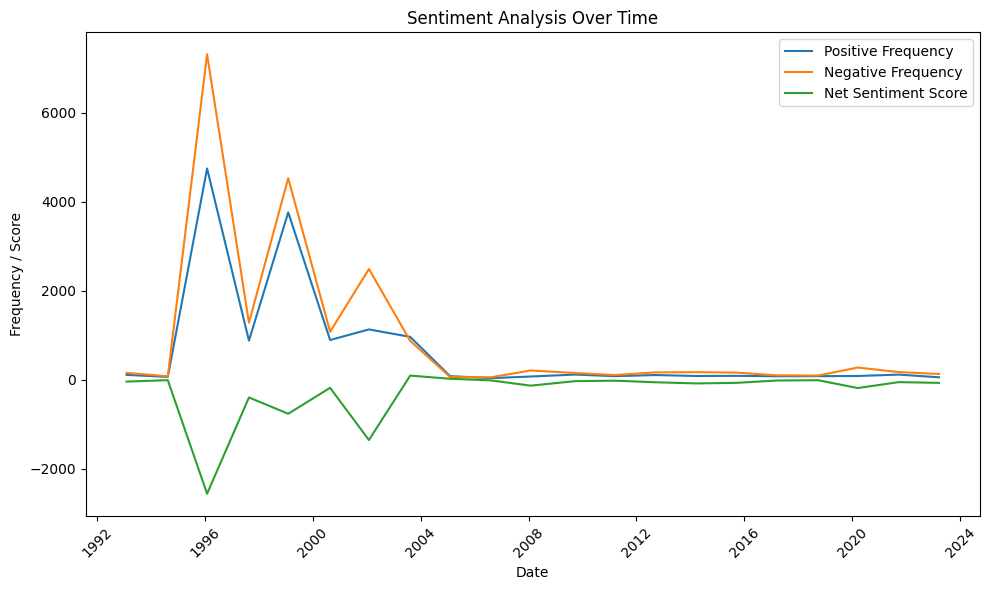

In [557]:
# Filter dataset to include every 12th date
filtered_dataset = dataset[::12]

# Extract the required data
dates = filtered_dataset['Date']
positive_frequency = filtered_dataset['Positive Frequency']
negative_frequency = filtered_dataset['Negative Frequency']
net_sentiment_score = filtered_dataset['Net Sentiment Score']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, positive_frequency, label='Positive Frequency')
plt.plot(dates, negative_frequency, label='Negative Frequency')
plt.plot(dates, net_sentiment_score, label='Net Sentiment Score')

plt.xlabel('Date')
plt.ylabel('Frequency / Score')
plt.title('Sentiment Analysis Over Time')
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

In [558]:
combined_df = pd.concat([dataset['Positive Frequency'][-20:], dataset['Negative Frequency'][-20:], dataset['Net Sentiment Score'][-20:]], axis=1)
combined_df

Positive Frequency  Negative Frequency  Net Sentiment Score
224                 126                 122                    4
225                 118                 139                  -21
226                 127                 123                    4
227                 142                 174                  -32
228                 112                 169                  -57
229                 112                 145                  -33
230                 116                 137                  -21
231                  67                 130                  -63
232                 133                 165                  -32
233                  70                 132                  -62
234                  69                 166                  -97
235                  85                 185                 -100
236                  71                 168                  -97
237                  69                 184                 -115
238                  77                 184                 -107
239                  80                 174                  -94
240                  52                 126                  -74
241                  67                 202                 -135
242                  56                 118                  -62
243                  65                 127                  -62

#### Word Frequency Analysis

In [559]:
# Create dictionaries to store positive and negative word frequencies per row
positive_word_frequencies = {}
negative_word_frequencies = {}

# Iterate over each row in the preprocessed text
for index, datapoint in dataset['Preprocessed Text'].iteritems():
    words = datapoint.lower().split()  # Tokenize the text into words

    # Iterate over each word and check its sentiment
    for word in words:
        if word in sentiment_word_list:
            sentiment = sentiment_word_list[word]
            if sentiment == 1:
                positive_word_frequencies[word] = positive_word_frequencies.get(word, 0) + 1
            elif sentiment == -1:
                negative_word_frequencies[word] = negative_word_frequencies.get(word, 0) + 1

# Get the 10 most frequent positive words
top_positive_words = sorted(positive_word_frequencies, key=positive_word_frequencies.get, reverse=True)[:10]

# Get the 10 most frequent negative words
top_negative_words = sorted(negative_word_frequencies, key=negative_word_frequencies.get, reverse=True)[:10]

print("Top 10 Positive Words:")
for word in top_positive_words:
    print(f"{word}: {positive_word_frequencies[word]}")

print("\nTop 10 Negative Words:")
for word in top_negative_words:
    print(f"{word}: {negative_word_frequencies[word]}")

iteritems is deprecated and will be removed in a future version. Use .items instead.


Top 10 Positive Words:
stability: 10654
good: 9720
gain: 9386
strong: 8158
strength: 6553
favorable: 5629
despite: 4941
positive: 3459
strengthening: 3210
progress: 2815

Top 10 Negative Words:
decline: 12643
easing: 6644
weakness: 6419
concern: 6295
declined: 5845
unemployment: 5596
tightening: 5559
slowed: 3894
slowing: 3761
deficit: 3446


#### Word Sentiment Data Feature Engineering

In [560]:
# Create an empty list to store the word counts
word_count = []

# Iterate over each row in the preprocessed text
for datapoint in dataset['Preprocessed Text']:
    words = datapoint.lower().split()  # Tokenize the text into words
    num_words = len(words)  # Calculate the number of words in the row
    word_count.append(num_words)  # Add the word count to the list

# Print the word counts
print("Word Count:")
for count in word_count:
    print(count)

Word Count:
6085
3520
3059
4268
2859
3045
3582
3502
6108
3871
2994
4022
2971
3108
3368
3443
4827
4603
3060
4141
2692
2950
3022
2988
231389
15282
16975
19898
20140
19655
20164
19933
56259
51364
52203
71523
49348
42634
55571
25738
246599
48807
78222
62890
57291
65547
91559
55537
165012
49878
80203
49642
86734
49837
46980
57213
171840
55604
43086
49728
44928
46097
38459
59216
59216
56314
57865
55999
61388
42042
151379
48213
50670
51825
40665
94274
85917
65178
108403
63792
138615
35229
3984
60628
42010
43634
40003
48103
15460
34608
3132
2964
35611
2625
2327
2533
4381
2730
2612
2725
2139
2296
2368
2317
4099
2845
3011
35981
2397
2397
2792
2701
4647
2614
2622
2841
2828
3542
48062
7057
6996
3793
3252
8166
2869
4968
4736
18119
4015
3906
5095
4318
4457
8600
4879
6507
4025
4247
4849
4034
3627
4338
4042
6191
4080
4664
4240
4010
4979
4619
4576
3998
6732
4539
4914
4421
4821
4181
4641
6671
4633
4439
5180
4624
4835
4459
7247
5414
5145
3746
4871
5107
5140
5335
4183
7768
5288
4918
5201
5447
4806
5251
49

In [561]:
# Calculate the proportions of positive words per minute for each row
positive_words_per_minute = dataset['Positive Frequency'] / word_count

# Calculate the proportions of negative words per minute for each row
negative_words_per_minute = dataset['Negative Frequency'] / word_count

# Add the calculated columns to the dataset
dataset['Proportion Positive Words'] = positive_words_per_minute
dataset['Proportion Negative Words'] = negative_words_per_minute
dataset['Word Count'] = word_count

#### Sentiment Score Standardization

In [563]:
# Create an instance of the MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Reshape the Net Sentiment Score column
net_sentiment_scores = dataset["Net Sentiment Score"].values.reshape(-1, 1)

# Scale the scores to the range of -1 to 1
scaled_scores = scaler.fit_transform(net_sentiment_scores)

# Add a new column for the scaled scores
dataset["Standardized Sentiment Score"] = scaled_scores

### Correlation Analysis

In [564]:
# Create a copy of the dataset
clean_data_numeric = dataset.copy()

# Remove 'Federal_Reserve_Mins' and 'Preprocessed Text' columns
clean_data_numeric = clean_data_numeric.drop(['Federal_Reserve_Mins', 'Preprocessed Text'], axis=1)

#### Correlation Matrix

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


                       Date  Difference  Increase  Decrease  Level    CPI  \
count                   244       244.0     244.0     244.0  244.0  244.0   
unique                  244         NaN       NaN       NaN    NaN    NaN   
top     1993-02-03 00:00:00         NaN       NaN       NaN    NaN    NaN   
freq                      1         NaN       NaN       NaN    NaN    NaN   
first   1993-02-03 00:00:00         NaN       NaN       NaN    NaN    NaN   
last    2023-07-26 00:00:00         NaN       NaN       NaN    NaN    NaN   
mean                    NaN         0.0       0.1       0.0    2.5  209.4   
std                     NaN         0.2       0.2       0.1    2.2   41.6   
min                     NaN        -1.0       0.0       0.0    0.2  142.8   
25%                     NaN         0.0       0.0       0.0    0.2  173.4   
50%                     NaN         0.0       0.0       0.0    1.9  212.1   
75%                     NaN         0.0       0.0       0.0    5.0  237.8   

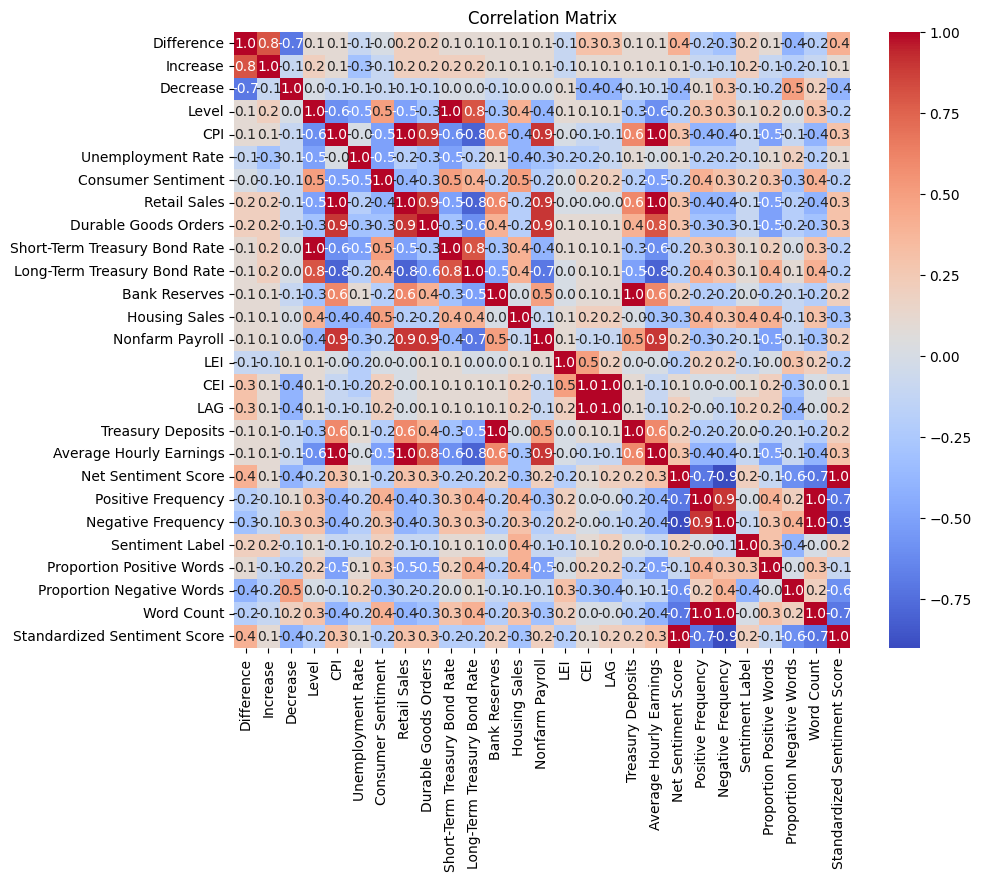

In [565]:
summary_stats = clean_data_numeric.describe(include='all')
summary_stats = summary_stats.round(1)  # Round to one decimal place
print(summary_stats)

correlation_matrix = clean_data_numeric.corr().round(1)  # Round to one decimal place
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", square=True)  # Format to one decimal place
plt.title('Correlation Matrix')
plt.show()

#### Correlation Analysis -- Highest levels of correlation

In [566]:
# Calculate the correlation matrix
correlation_matrix = dataset.corr()

# Get the absolute correlation values and sort them in descending order
correlation_values = correlation_matrix.abs().unstack().sort_values(ascending=False)

# Filter out the diagonal elements (self-correlations) and duplicate pairs
correlation_values = correlation_values[correlation_values.index.get_level_values(0) < correlation_values.index.get_level_values(1)]

# Get the top 20 highest correlation coefficients
top_20_correlations = correlation_values[correlation_values >= 0.8].head(50)

# Display the filtered correlations
print(top_20_correlations)

Net Sentiment Score           Standardized Sentiment Score     1.000000
Level                         Short-Term Treasury Bond Rate    0.996611
Average Hourly Earnings       CPI                              0.996386
Bank Reserves                 Treasury Deposits                0.994763
Positive Frequency            Word Count                       0.986351
Average Hourly Earnings       Retail Sales                     0.984795
CPI                           Retail Sales                     0.981418
Negative Frequency            Word Count                       0.961431
CEI                           LAG                              0.955394
Negative Frequency            Positive Frequency               0.949909
Nonfarm Payroll               Retail Sales                     0.923750
CPI                           Nonfarm Payroll                  0.915047
Average Hourly Earnings       Nonfarm Payroll                  0.909158
Durable Goods Orders          Retail Sales                     0

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


#### Correlation Analysis -- Lowest levels of correlation

In [567]:
# Calculate the correlation matrix
correlation_matrix = dataset.corr()

# Get the absolute correlation values and sort them in ascending order
correlation_values = correlation_matrix.abs().unstack().sort_values(ascending=True)

# Filter out the diagonal elements (self-correlations) and duplicate pairs
correlation_values = correlation_values[correlation_values.index.get_level_values(0) < correlation_values.index.get_level_values(1)]

# Get the 20 lowest correlation coefficients
lowest_correlations = correlation_values[correlation_values <= 0.1].head(30)

# Display the filtered correlations
print(lowest_correlations)

Positive Frequency         Sentiment Label                  0.001040
LEI                        Proportion Positive Words        0.002563
                           Retail Sales                     0.003251
Decrease                   Nonfarm Payroll                  0.003388
Housing Sales              Treasury Deposits                0.004103
Proportion Negative Words  Proportion Positive Words        0.005362
Bank Reserves              Housing Sales                    0.005692
Proportion Negative Words  Short-Term Treasury Bond Rate    0.007221
Consumer Sentiment         Difference                       0.010452
Decrease                   Long-Term Treasury Bond Rate     0.013472
CEI                        Negative Frequency               0.015552
                           Retail Sales                     0.017977
LAG                        Retail Sales                     0.018828
Decrease                   Housing Sales                    0.020102
Sentiment Label            Treasur

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


#### Autocorrelational Analysis

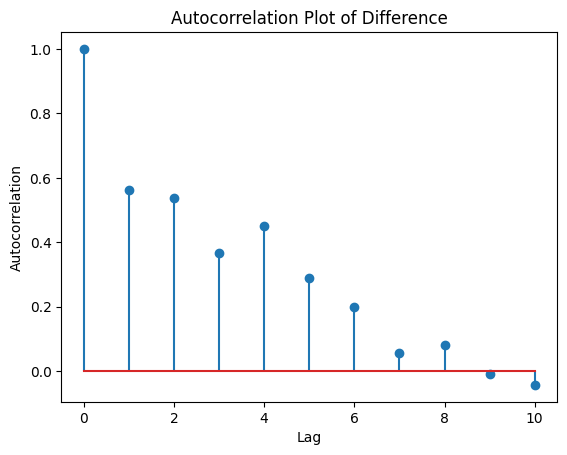

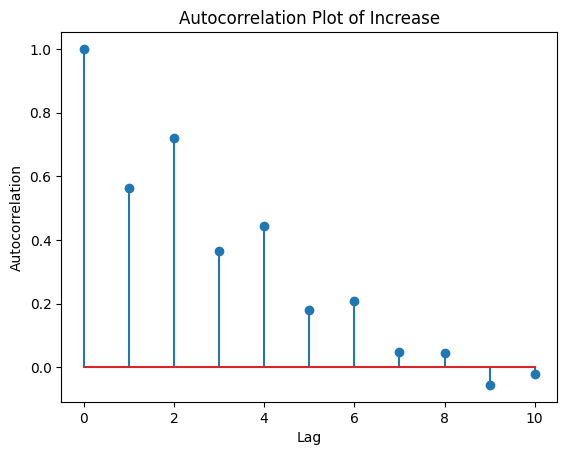

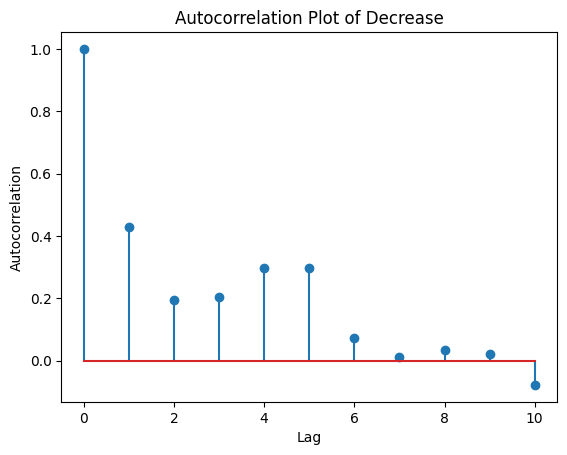

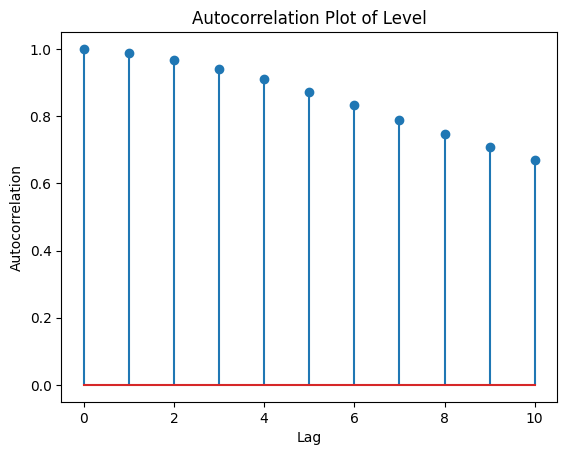

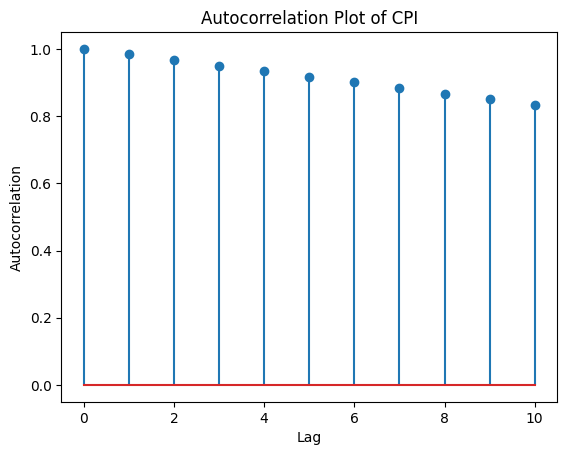

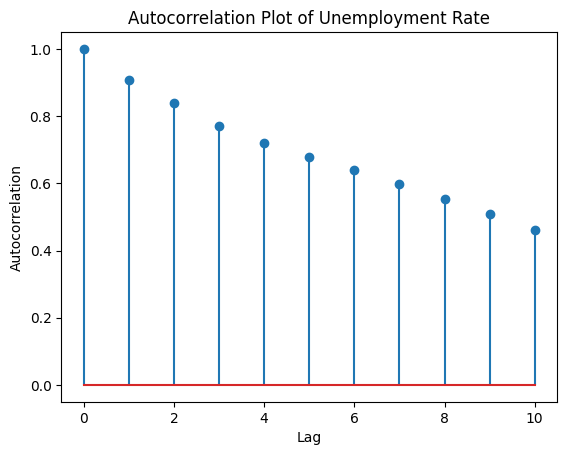

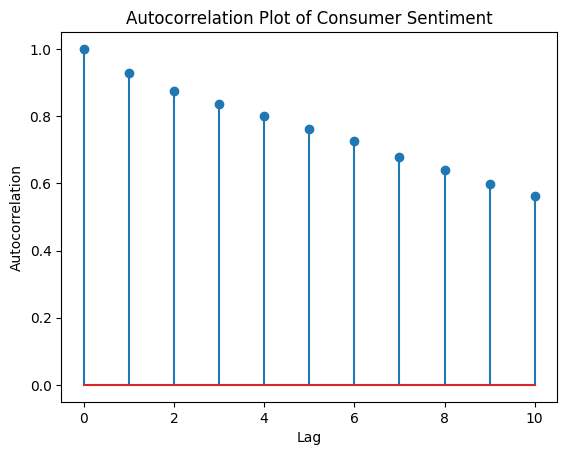

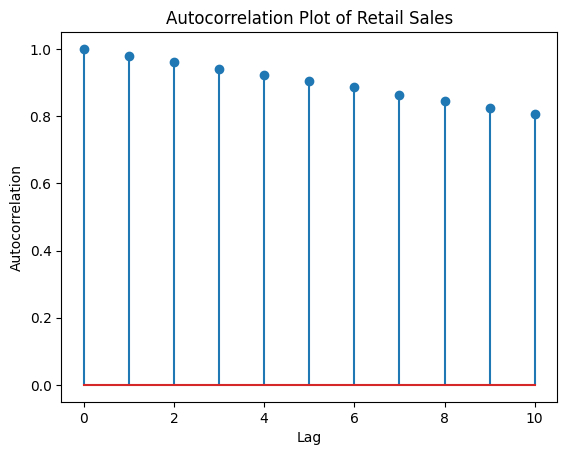

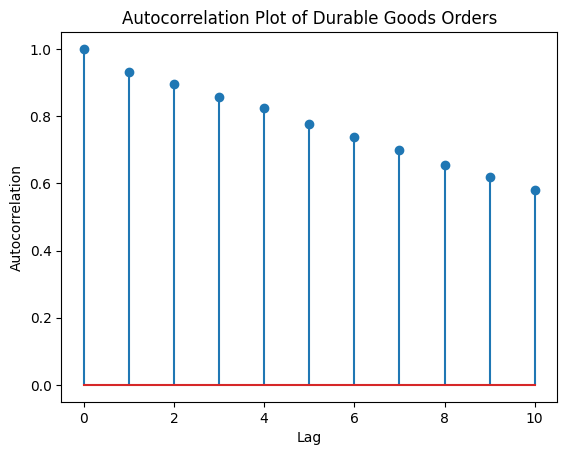

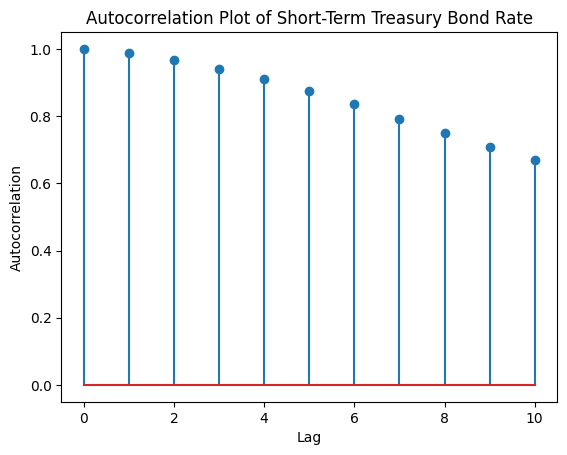

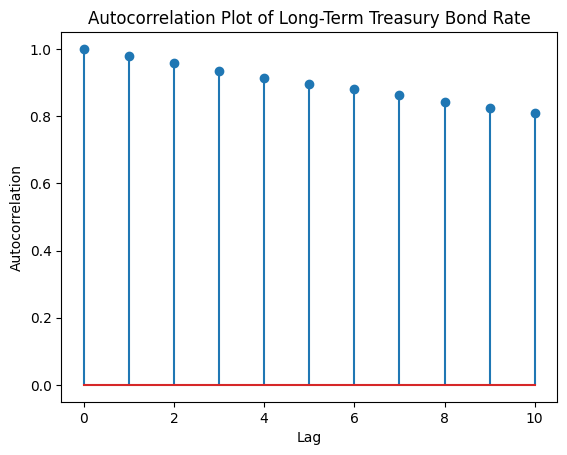

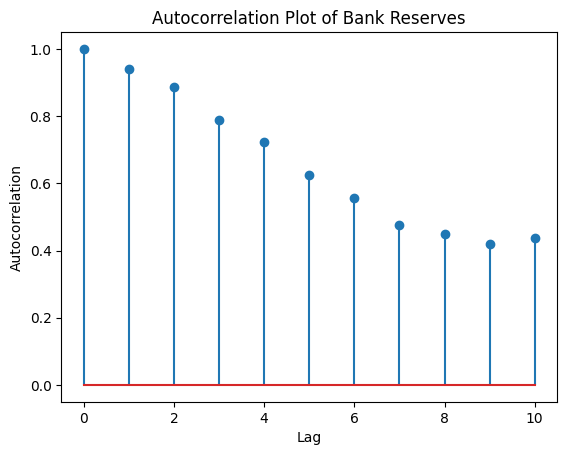

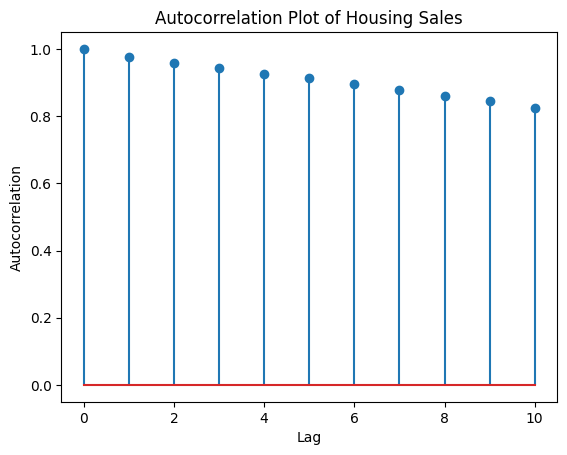

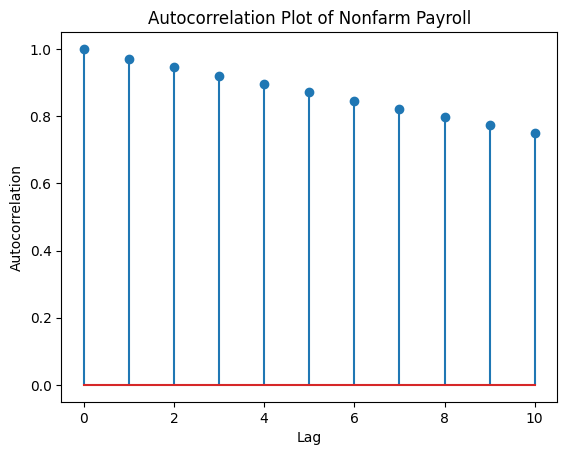

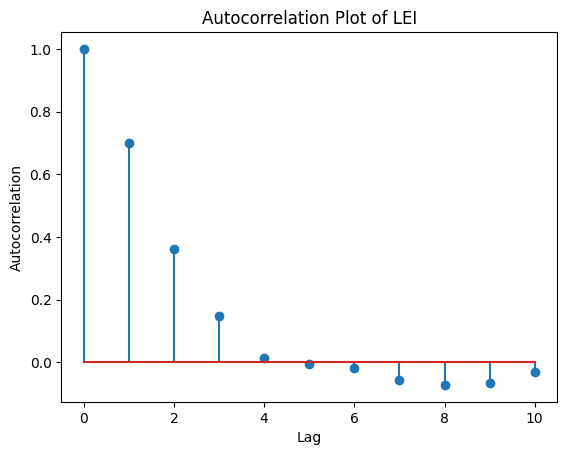

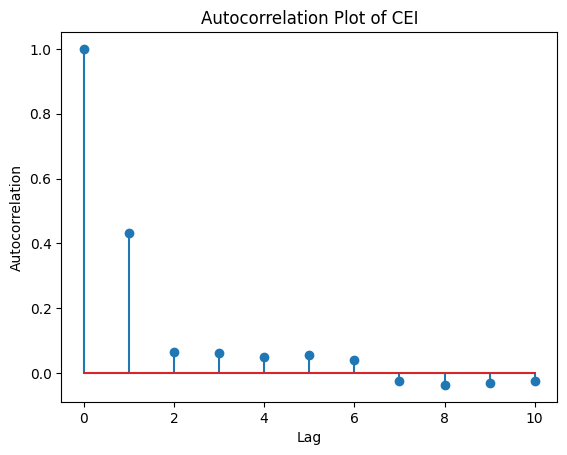

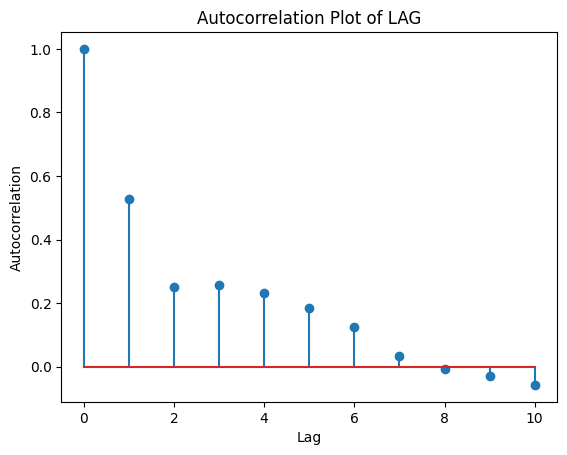

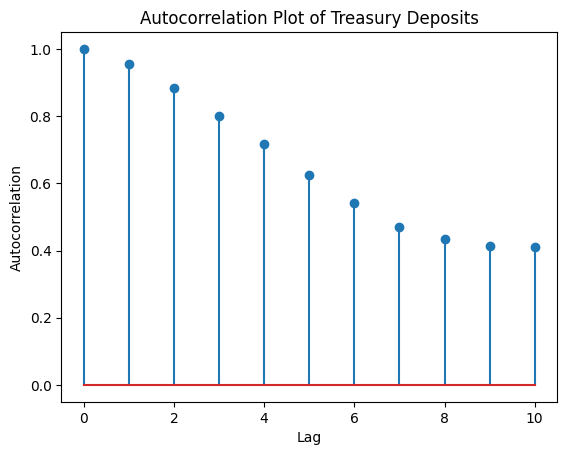

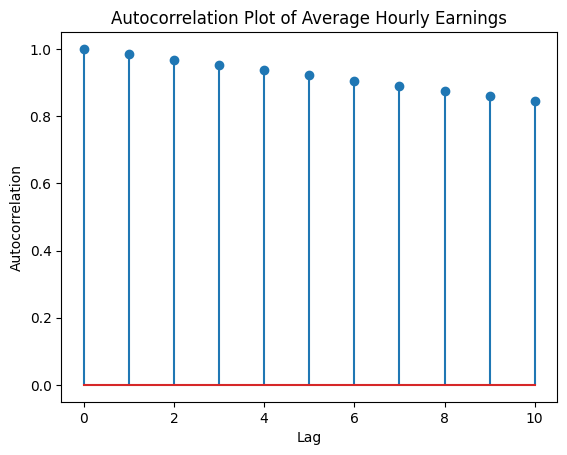

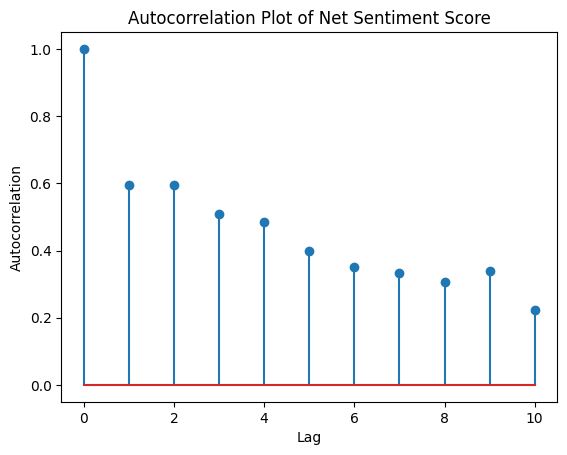

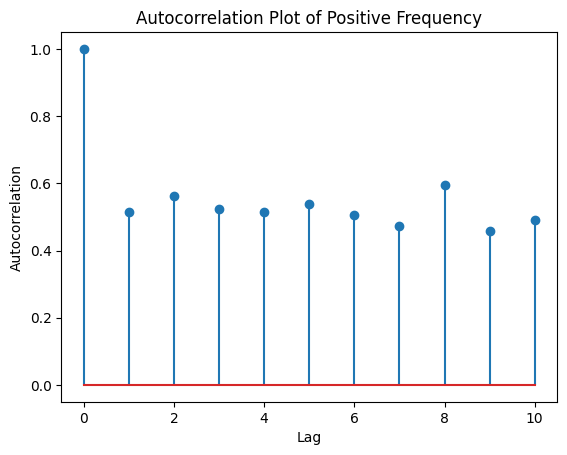

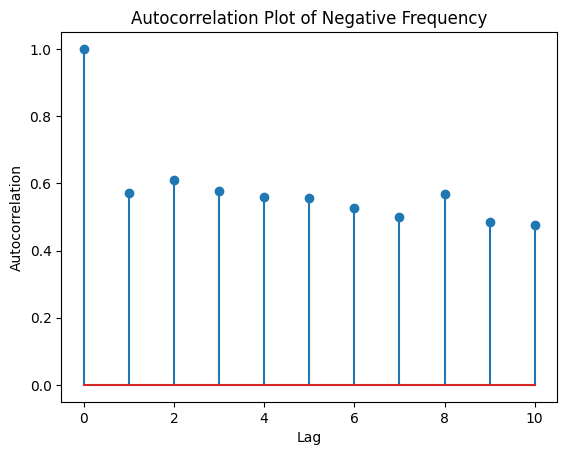

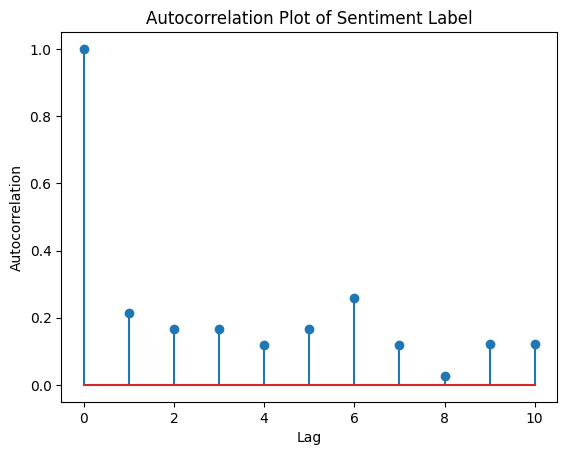

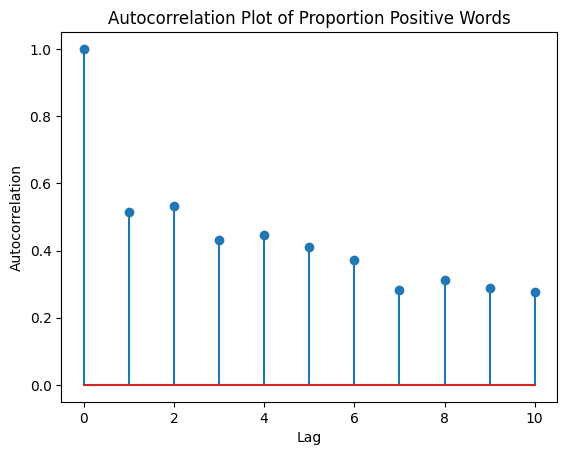

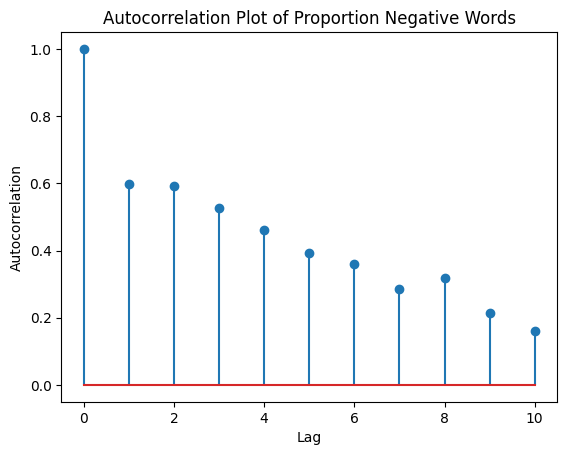

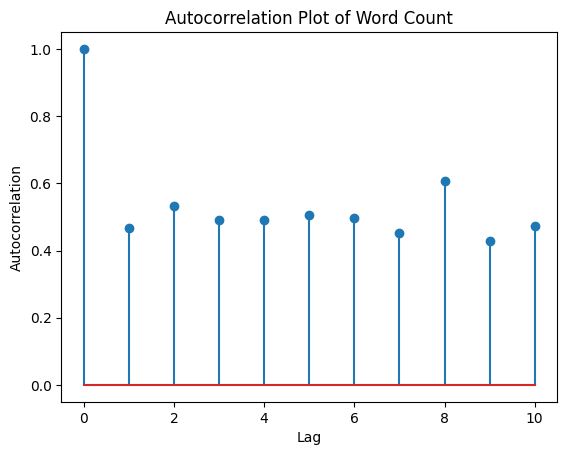

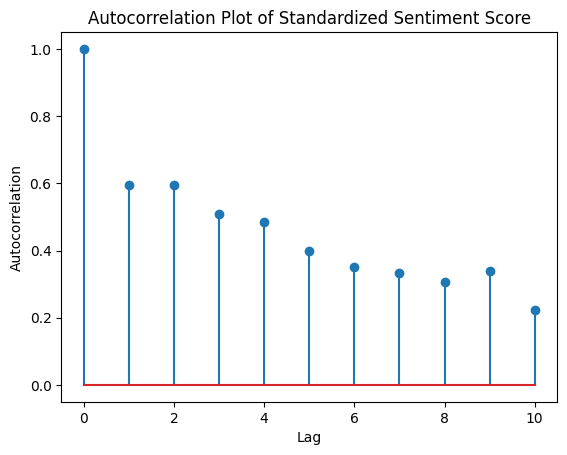

In [568]:
# Iterate over each column (excluding 'Date' and 'Sentiment Label', 'Positive Words', 'Negative Words')
for column in clean_data_numeric.columns:
    if column not in ['Date', 'Positive Words', 'Negative Words']:
        # Compute the autocorrelation
        acf = sm.tsa.acf(clean_data_numeric[column], nlags=10)
        
        # Plot the autocorrelation
        plt.stem(range(len(acf)), acf)
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.title(f'Autocorrelation Plot of {column}')
        plt.show()

#### Skewness Analysis -- Z-score, Kurtosis

In [569]:
# Select only numeric columns
numeric_columns = clean_data_numeric.select_dtypes(include=np.number).columns

# Calculate z-scores for each numeric column in the dataset
z_scores = stats.zscore(clean_data_numeric[numeric_columns])

# Create a new DataFrame with z-scores
z_scores_df = pd.DataFrame(z_scores, columns=numeric_columns)

z_scores

z_scores_df

Difference  Increase  Decrease     Level       CPI  Unemployment Rate  \
0     -0.091840  -0.43940 -0.320685  0.559554 -1.604387           0.892914   
1     -0.091840  -0.43940 -0.320685  0.559554 -1.592338           0.725750   
2     -0.091840  -0.43940 -0.320685  0.559554 -1.570649           0.781471   
3     -2.332731  -0.43940  3.156966  0.327555 -1.563420           0.670028   
4     -0.091840  -0.43940 -0.320685  0.327555 -1.556190           0.614307   
..          ...       ...       ...       ...       ...                ...   
239    1.028606   1.21004 -0.320685  1.023550  2.196827          -1.280224   
240    1.028606   1.21004 -0.320685  1.139550  2.227481          -1.224503   
241    1.028606   1.21004 -0.320685  1.255549  2.254230          -1.280224   
242   -0.091840  -0.43940 -0.320685  1.255549  2.276473          -1.168781   
243   -0.091840  -0.43940 -0.320685  1.255549  2.288691          -1.224503   

     Consumer Sentiment  Retail Sales  Durable Goods Orders  \
0              0.200462     -1.553040             -2.166286   
1             -0.055468     -1.578099             -2.028937   
2             -0.476999     -1.525773             -2.035181   
3             -0.725401     -1.506007             -1.992784   
4             -0.702819     -1.508778             -1.958829   
..                  ...           ...                   ...   
239           -1.636209      2.431108              2.034188   
240           -1.854502      2.351275              2.073450   
241           -1.741592      2.373875              2.166552   
242           -1.673846      2.415213              2.669478   
243           -1.673846      2.448988              2.669478   

     Short-Term Treasury Bond Rate  ...  Treasury Deposits  \
0                         0.293000  ...          -0.462513   
1                         0.317230  ...          -0.469036   
2                         0.307538  ...          -0.467355   
3                         0.317230  ...          -0.466228   
4                         0.346305  ...          -0.467829   
..                             ...  ...                ...   
239                       1.102270  ...           0.872523   
240                       1.000505  ...           0.442622   
241                       1.286415  ...           0.128141   
242                       1.363950  ...           0.193370   
243                       1.441485  ...           1.188205   

     Average Hourly Earnings  Net Sentiment Score  Positive Frequency  \
0                  -1.510278             0.398692           -0.438019   
1                  -1.497539             0.419510           -0.460484   
2                  -1.493292             0.409101           -0.496163   
3                  -1.484799             0.442410           -0.461806   
4                  -1.480553             0.444492           -0.497485   
..                       ...                  ...                 ...   
239                 2.175607             0.296684           -0.472377   
240                 2.224441             0.338320           -0.509378   
241                 2.243549             0.211329           -0.489556   
242                 2.290260             0.363302           -0.504092   
243                 2.317862             0.363302           -0.492199   

     Negative Frequency  Sentiment Label  Proportion Positive Words  \
0             -0.459992        -0.330289                  -0.312684   
1             -0.483740        -0.330289                   1.519927   
2             -0.503091        -0.330289                   0.351032   
3             -0.494295        -0.330289                   0.432708   
4             -0.518923        -0.330289                   0.599926   
..                  ...              ...                        ...   
239           -0.439762        -0.330289                  -1.056073   
240           -0.481981        -0.330289                  -1.878215   
241           -0.415135        -0.330289          

In [570]:
def calculate_z_scores(data):
    n = len(data)
    if data.dtype.kind in ['i', 'f']:  # Check if data is numeric
        observed_skewness = skew(data)
        observed_kurtosis = kurtosis(data)

        expected_skewness = 0
        expected_kurtosis = 0

        standard_error_skewness = np.sqrt(6 / n)
        standard_error_kurtosis = np.sqrt(24 / n)

        z_score_skewness = (observed_skewness - expected_skewness) / standard_error_skewness
        z_score_kurtosis = (observed_kurtosis - expected_kurtosis) / standard_error_kurtosis

        return z_score_skewness, z_score_kurtosis
    else:
        return None, None


# Calculate z-scores for skewness and kurtosis for each column in the dataset
z_scores = {}
for column in dataset.columns:
    z_score_skewness, z_score_kurtosis = calculate_z_scores(dataset[column])
    if z_score_skewness is not None and z_score_kurtosis is not None:
        z_scores[column] = (z_score_skewness, z_score_kurtosis)

# Print the z-scores for each column
for column, (z_score_skewness, z_score_kurtosis) in z_scores.items():
    print("Column:", column)
    print("Z-score for skewness:", z_score_skewness)
    print("Z-score for kurtosis:", z_score_kurtosis)
    print()

Column: Difference
Z-score for skewness: -1.467840841176392
Z-score for kurtosis: 13.85603273452358

Column: Increase
Z-score for skewness: 16.972540114223378
Z-score for kurtosis: 23.84195784903442

Column: Decrease
Z-score for skewness: 22.921538201237784
Z-score for kurtosis: 44.572002816865094

Column: Level
Z-score for skewness: 2.242059092223376
Z-score for kurtosis: -4.689904696685071

Column: CPI
Z-score for skewness: 1.4994605243377432
Z-score for kurtosis: -2.6030616766866532

Column: Unemployment Rate
Z-score for skewness: 8.63137055310053
Z-score for kurtosis: 7.191007335970016

Column: Consumer Sentiment
Z-score for skewness: -3.191371111442492
Z-score for kurtosis: -1.370001455119578

Column: Retail Sales
Z-score for skewness: 3.997584805190799
Z-score for kurtosis: -0.36351025556857286

Column: Durable Goods Orders
Z-score for skewness: 0.8851383128162509
Z-score for kurtosis: -1.2285717869478228

Column: Short-Term Treasury Bond Rate
Z-score for skewness: 2.163321021141

#### Time Plot Analysis

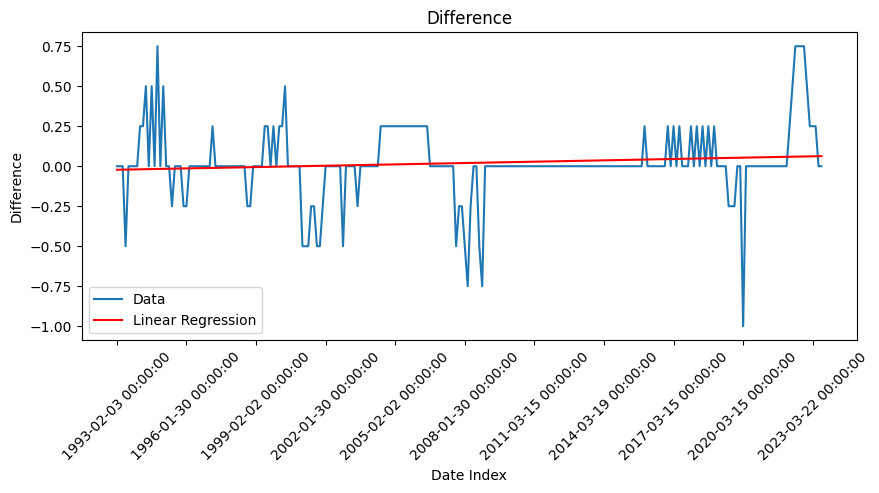

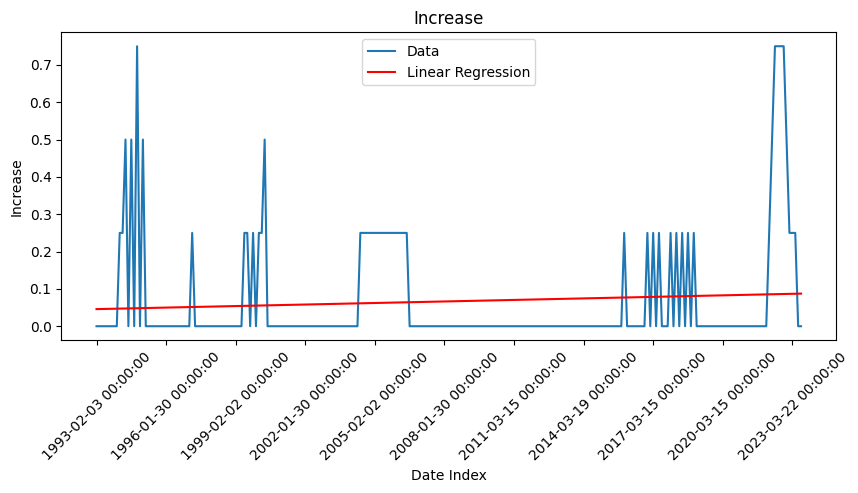

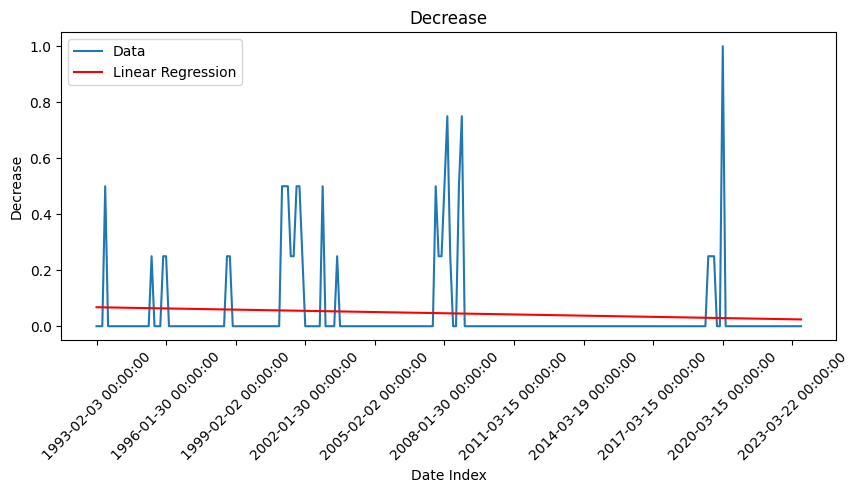

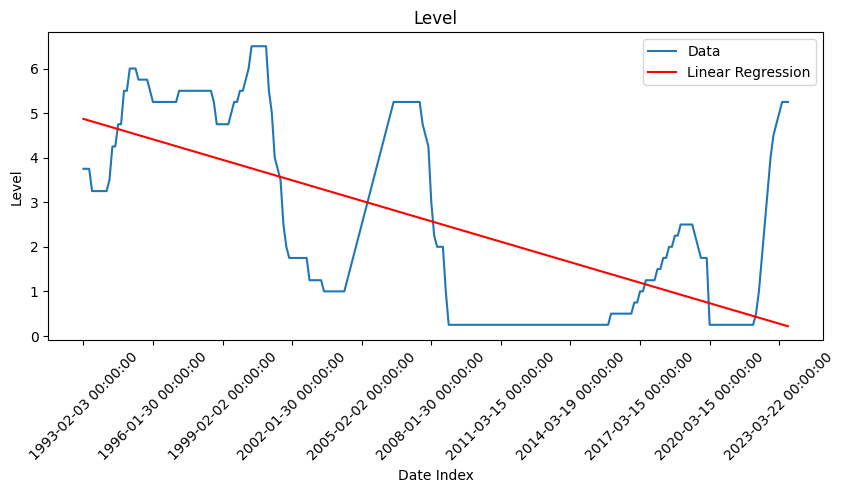

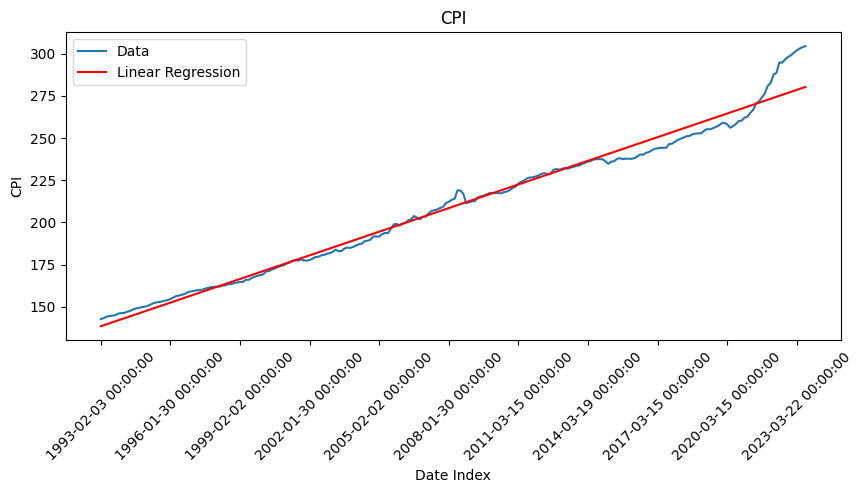

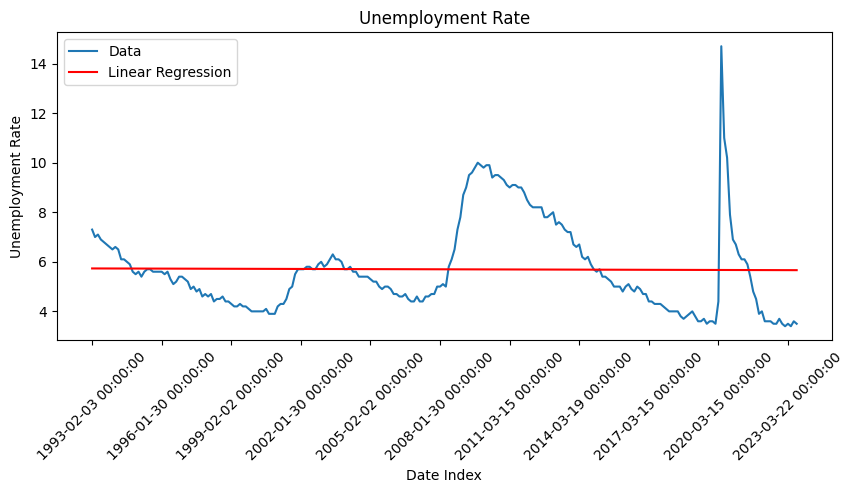

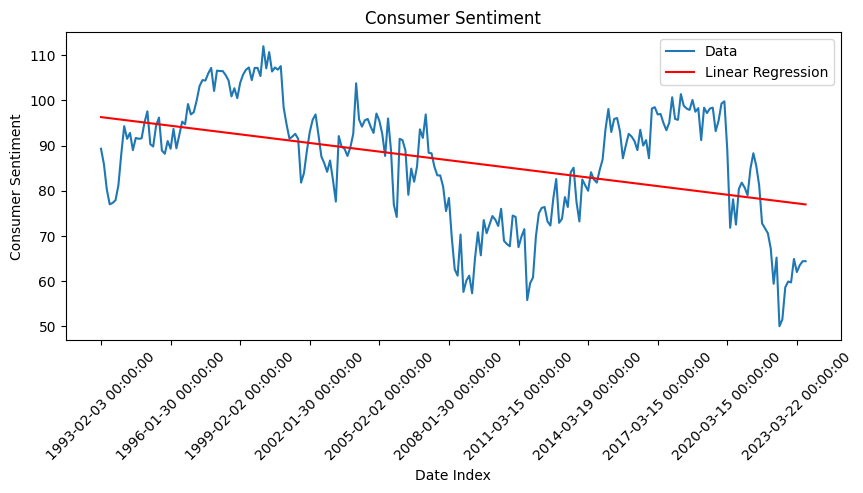

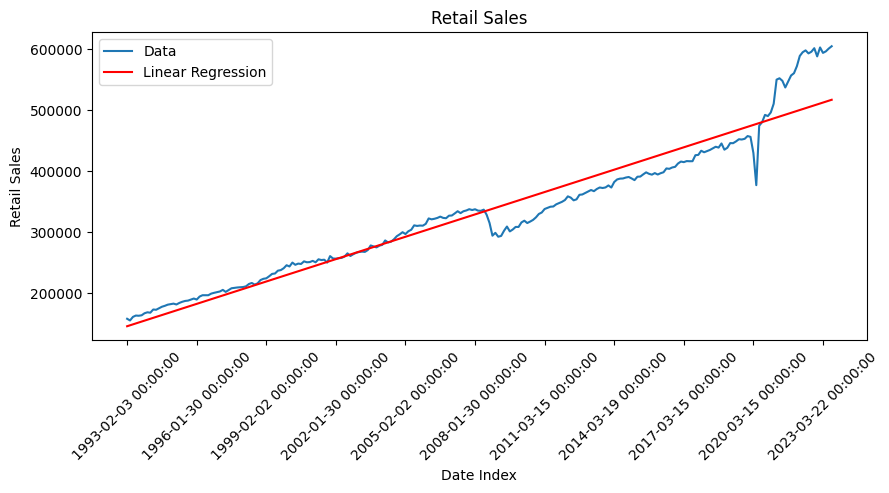

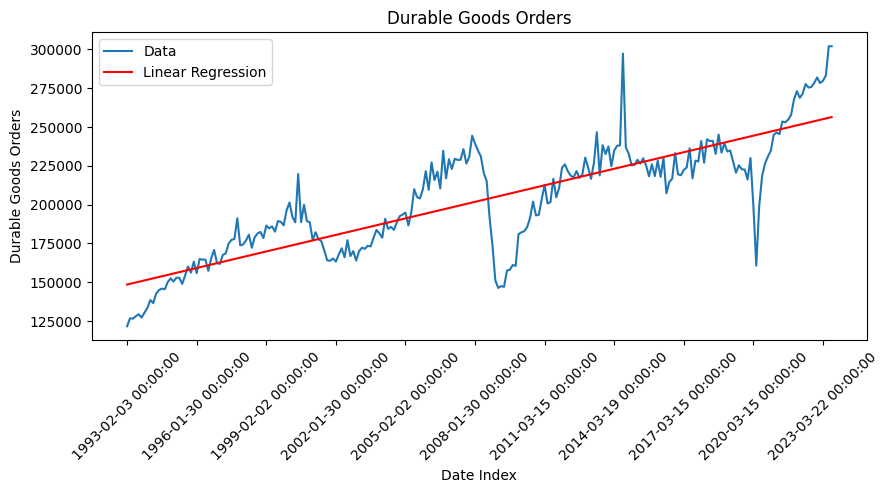

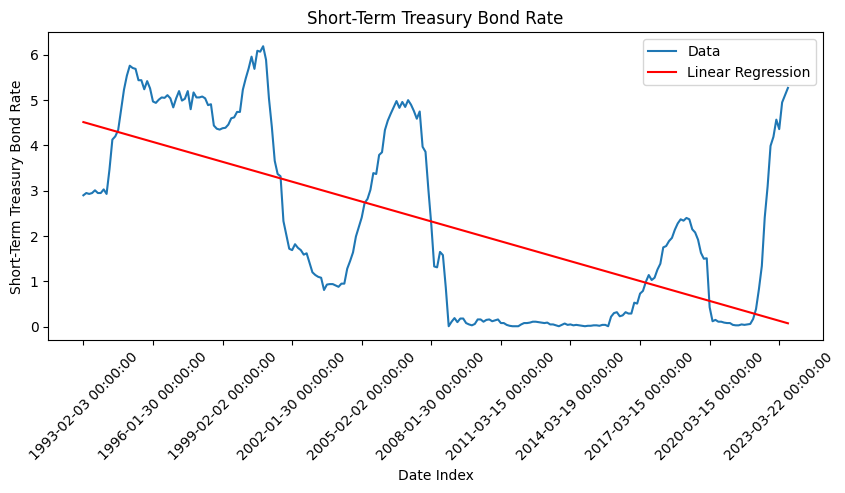

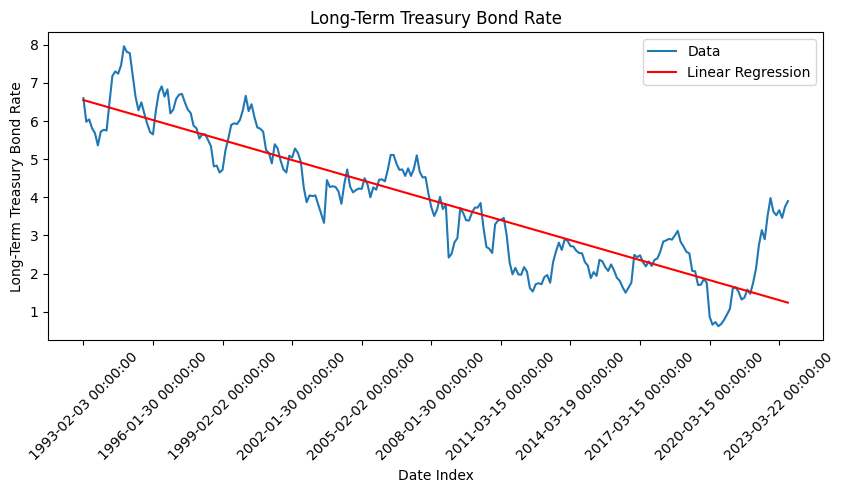

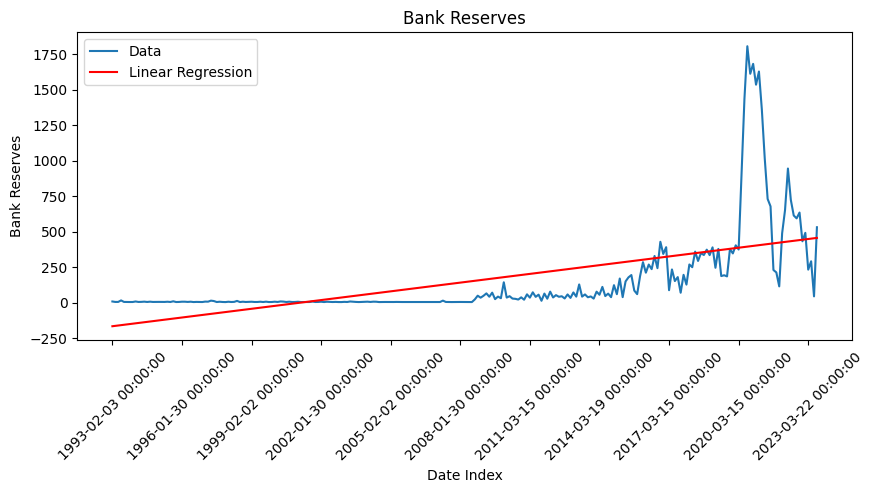

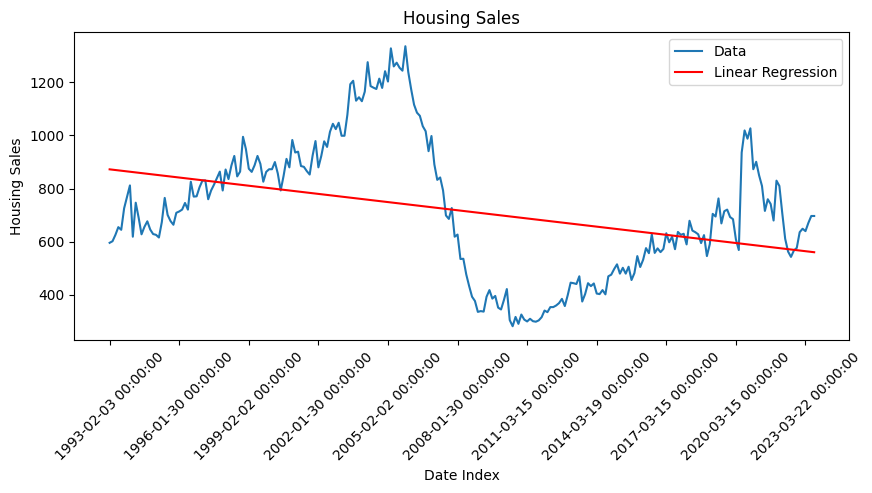

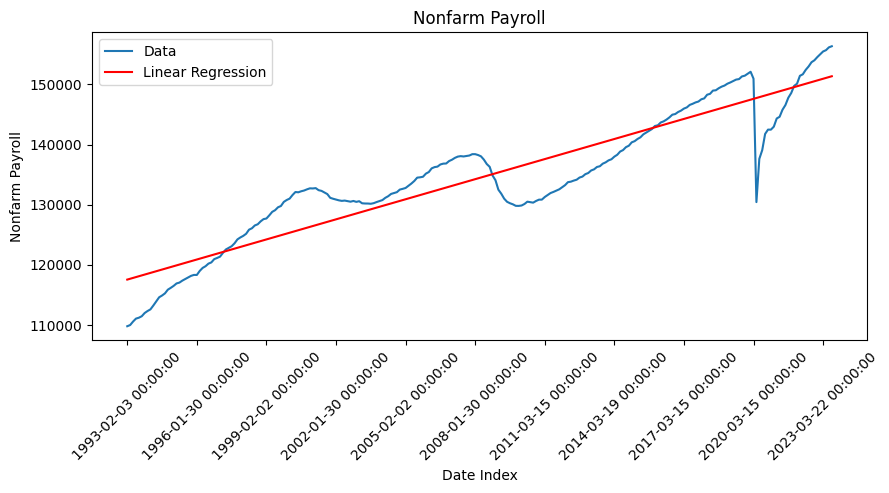

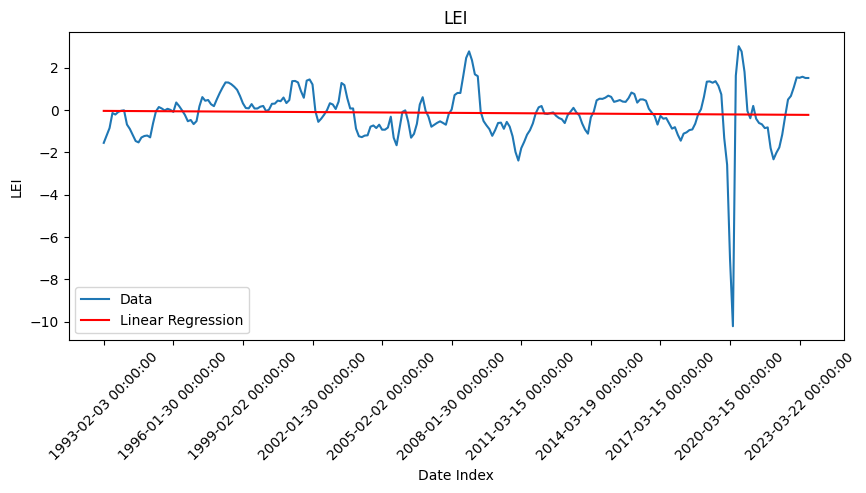

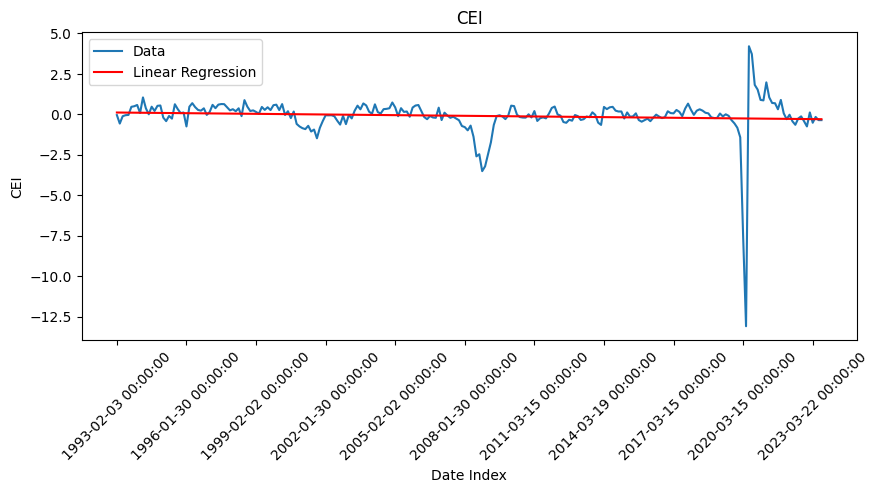

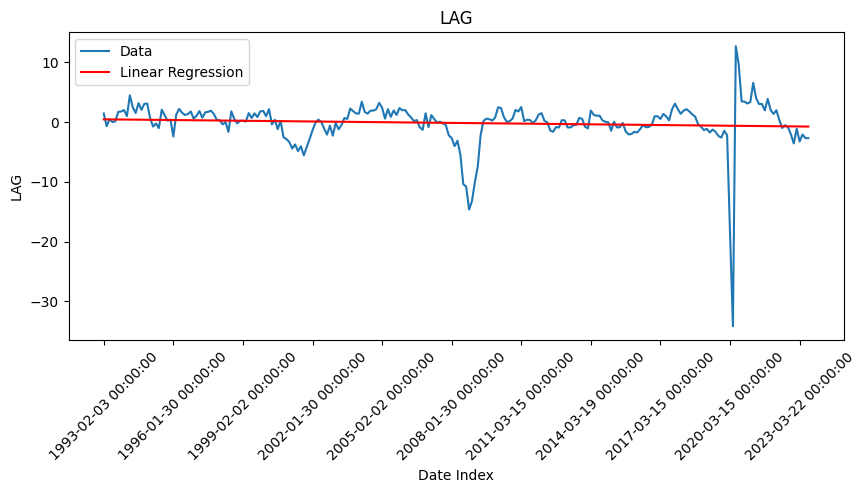

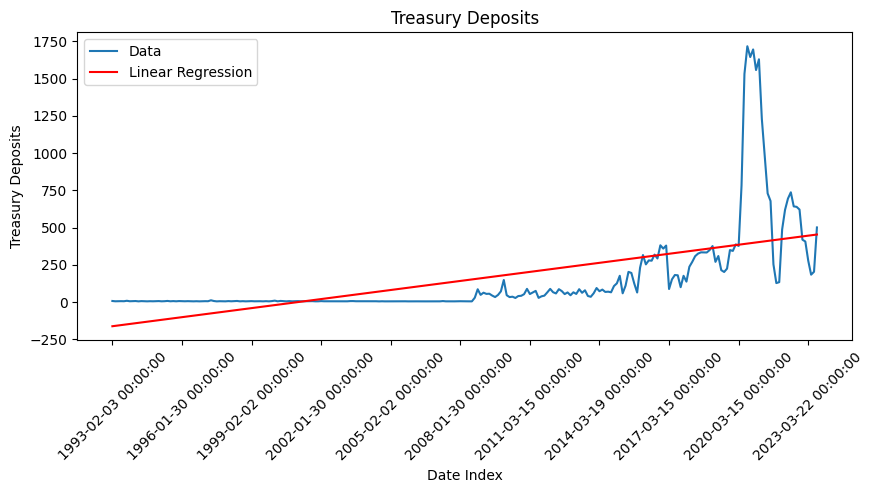

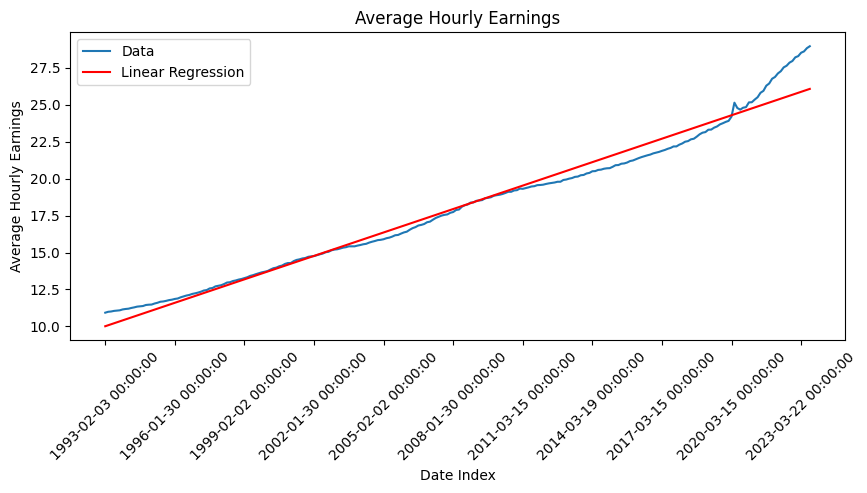

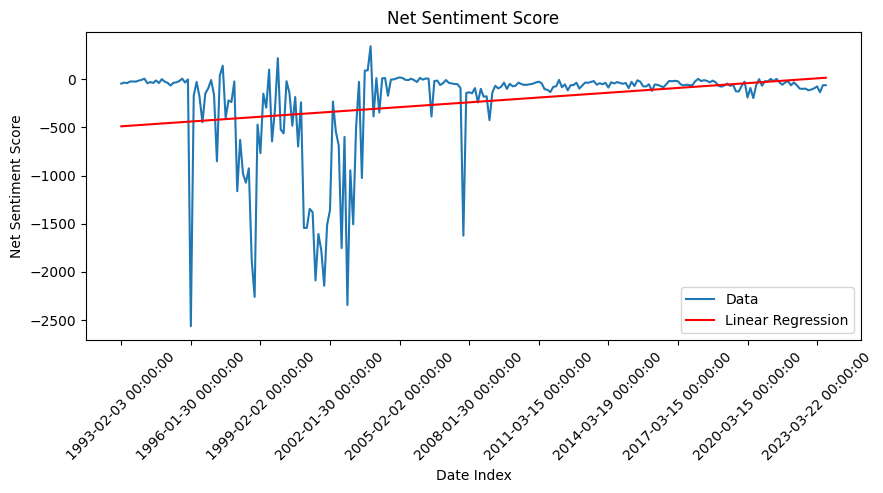

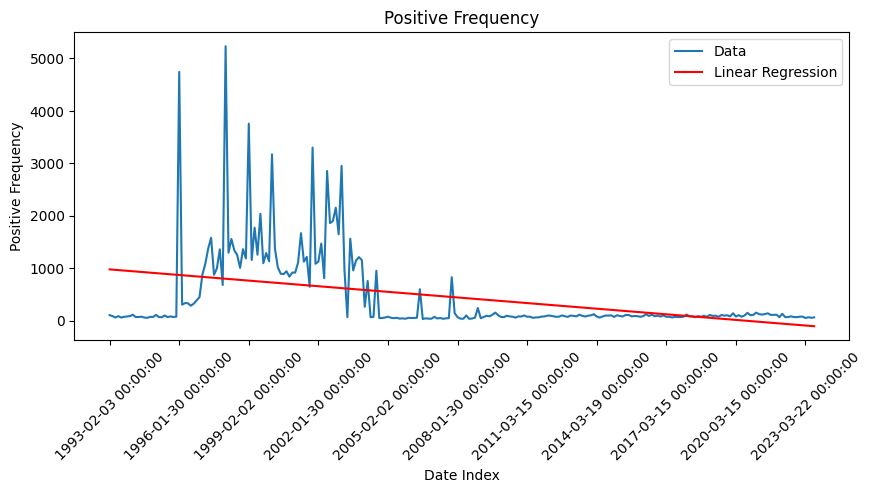

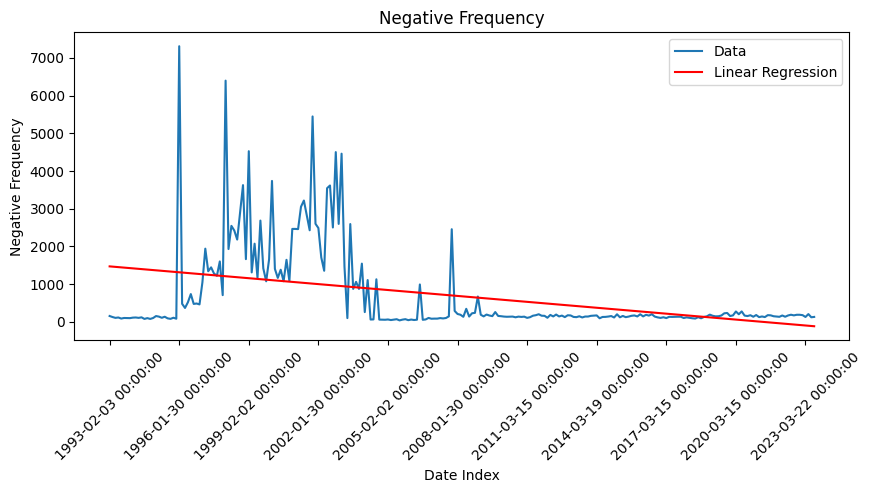

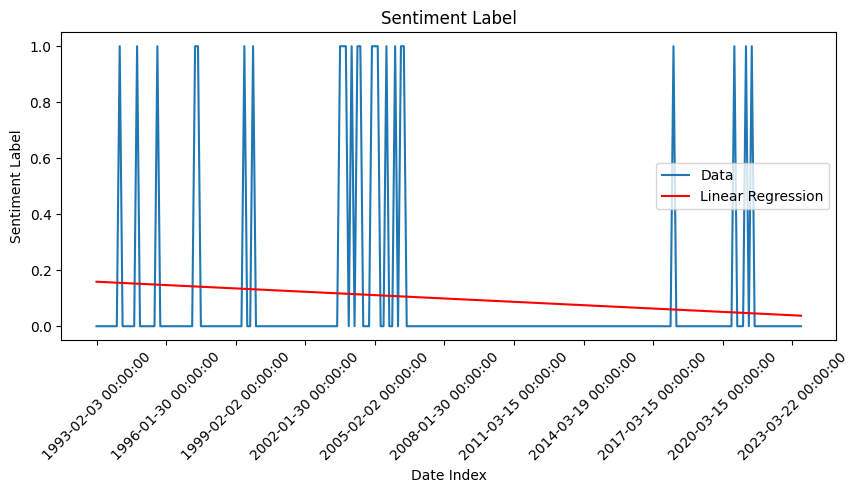

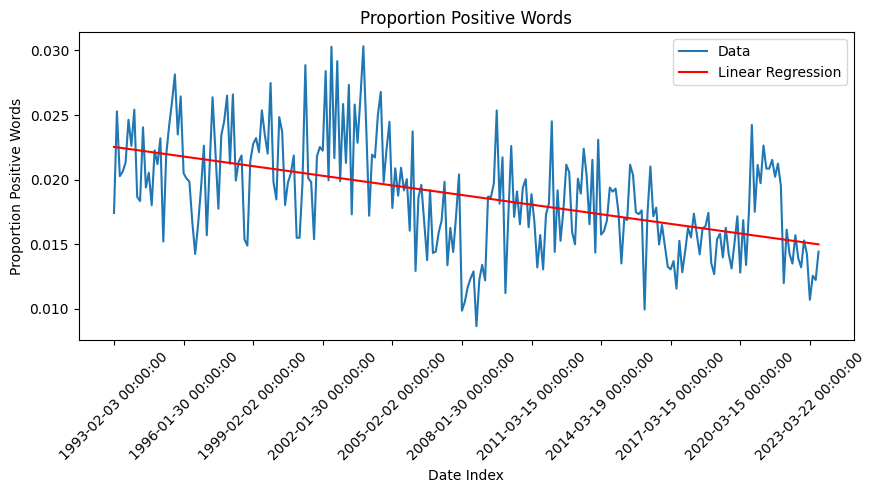

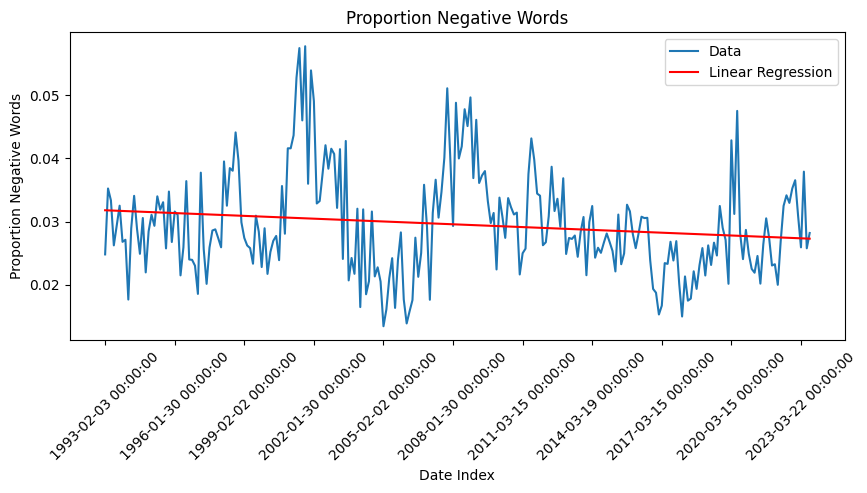

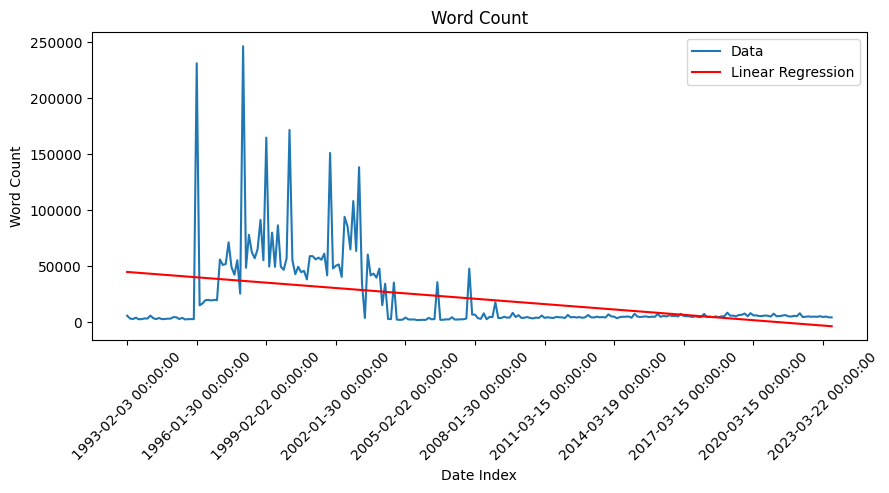

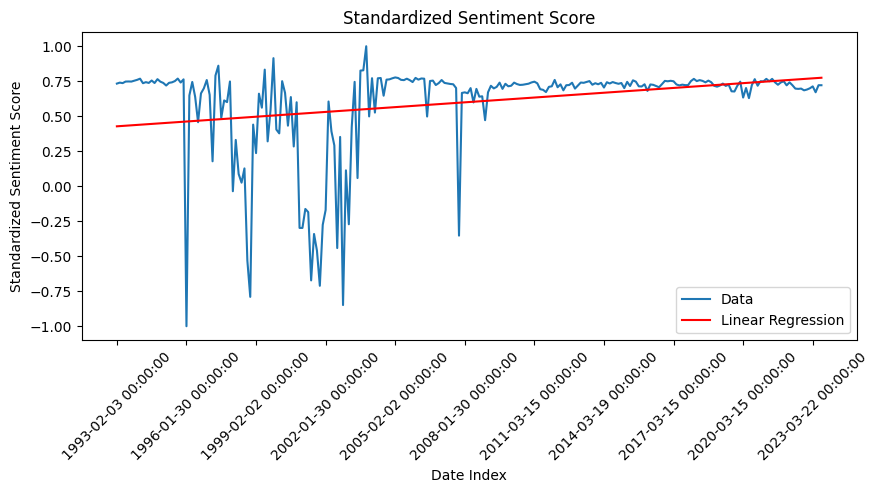

In [571]:
for column in clean_data_numeric.columns:
    if column != 'Date' and column != 'Positive Words' and column != 'Negative Words':
        plt.figure(figsize=(10, 4))
        
        # Convert column values to numeric
        y = pd.to_numeric(clean_data_numeric[column], errors='coerce')

        # Calculate the line of best fit
        x = np.arange(len(clean_data_numeric['Date']))
        slope, intercept, _, _, _ = linregress(x, y)
        line = slope * x + intercept
        
        plt.plot(x, y, label='Data')
        plt.plot(x, line, color='red', label='Linear Regression')
        
        plt.title(column)
        plt.xlabel('Date Index')
        plt.ylabel(column)
        
        # Reduce the number of x-axis tick labels
        num_ticks = 10
        step = len(x) // num_ticks
        plt.xticks(x[::step], clean_data_numeric['Date'][::step], rotation=45)
        
        plt.legend()
        plt.show()

## Feature Engineering, Data augmentation, Dimensionality Reduction

In [572]:
dataset

Federal_Reserve_Mins  \
0    A meeting of the Federal Open Market Committee...   
1    A meeting of the Federal Open Market Committee...   
2    A meeting of the Federal Open Market Committee...   
3    A meeting of the Federal Open Market Committee...   
4    A meeting of the Federal Open Market Committee...   
..                                                 ...   
239  The Federal Reserve, the central bank of the U...   
240  The Federal Reserve, the central bank of the U...   
241  The Federal Reserve, the central bank of the U...   
242  The Federal Reserve, the central bank of the U...   
243  The Federal Reserve, the central bank of the U...   

                                     Preprocessed Text       Date  Difference  \
0    meeting federal open market committee held off... 1993-02-03        0.00   
1    meeting federal open market committee held off... 1993-03-23        0.00   
2    meeting federal open market committee held off... 1993-05-18        0.00   
3    meeting federal open market committee held off... 1993-07-07       -0.50   
4    meeting federal open market committee held off... 1993-08-17        0.00   
..                                                 ...        ...         ...   
239  federal reserve central bank united state prov... 2023-02-01        0.25   
240  federal reserve central bank united state prov... 2023-03-22        0.25   
241  federal reserve central bank united state prov... 2023-05-03        0.25   
242  federal reserve central bank united state prov... 2023-06-14        0.00   
243  federal reserve central bank united state prov... 2023-07-26        0.00   

     Increase  Decrease  Level      CPI  Unemployment Rate  \
0        0.00       0.0   3.75  142.800                7.3   
1        0.00       0.0   3.75  143.300                7.0   
2        0.00       0.0   3.75  144.200                7.1   
3        0.00       0.5   3.25  144.500                6.9   
4        0.00       0.0   3.25  144.800                6.8   
..        ...       ...    ...      ...                ...   
239      0.25       0.0   4.75  300.536                3.4   
240      0.25       0.0   5.00  301.808                3.5   
241      0.25       0.0   5.25  302.918                3.4   
242      0.00       0.0   5.25  303.841                3.6   
243      0.00       0.0   5.25  304.348                3.5   

     Consumer Sentiment  ...  Treasury Deposits  Average Hourly Earnings  \
0                  89.3  ...              7.400                    10.93   
1                  85.9  ...              5.449                    10.99   
2                  80.3  ...              5.952                    11.01   
3                  77.0  ...              6.289                    11.05   
4                  77.3  ...              5.810                    11.07   
..                  ...  ...                ...                      ...   
239                64.9  ...            406.708                    28.29   
240                62.0  ...            278.125                    28.52   
241                63.5  ...            184.064                    28.61   
242                64.4  ...            203.574                    28.83   
243                64.4  ...            501.128                    28.96   

     Net Sentiment Score  Positive Frequency  Negative Frequency  \
0                    -45                 106                 151   
1                    -35                  89                 124   
2                    -40                  62                 102   
3                    -24                  88                 112   
4                    -23                  61                  84   
..                   ...                 ...                 ...   
239                  -94                  80                 174   
240                  -74                  52                 126   
241                 -135                  67                 202   
242                  -62  

### Macroeconomic Data Augmentation -- Moving Averages

In [573]:
dataset['Short-Term Treasury Diff'] = dataset['Short-Term Treasury Bond Rate'].diff()
dataset['LEI_RollingMean'] = dataset['LEI'].rolling(window=3).mean()
dataset['CEI_RollingMean'] = dataset['CEI'].rolling(window=3).mean()
dataset['LAG_RollingMean'] = dataset['LAG'].rolling(window=3).mean()
dataset['Retail Sales_RollingMean'] = dataset['Retail Sales'].rolling(window=3).mean()
dataset['Durable Goods Orders_RollingMean'] = dataset['Durable Goods Orders'].rolling(window=3).mean()

In [575]:
###Re-merge the 'Date' column and reduce the rows that are eliminated due to the rolling average
dataset['Date'] = dataset['Date']
dataset = dataset.iloc[2:]

#### FOMC minutes and their subsequent variables such as positive/negative word frequency will not be available before the policy action is enacted, so these variables need to be shifted up as if they were concurrent with the last FOMC meeting if they are to be used for forecasting purposes. This will make it so that FOMC minutes from the last meeting become predictive variables for the upcoming one, since we won't have access to the minutes until after the meeting is over and the action has already taken place. The policy action itself is also obviously unknown before it is made public, so the 'Increase' and 'Decrease' variables are also shifted up to analyze their predictive power.

In [577]:
# Shift up the rows in the specified columns
columns_to_shift = ['Net Sentiment Score', 'Positive Frequency', 'Negative Frequency', 'Sentiment Label', 'Proportion Positive Words', 'Proportion Negative Words', 'Word Count', 'Standardized Sentiment Score', 'Increase', 'Decrease']

for column in columns_to_shift:
    dataset.loc[:, column] = dataset[column].shift(-1)

# Remove the last row
dataset_adjusted = dataset[:-1]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Dimensionality Reduction -- Univariate Variable Selection

In [579]:
# Subset numerical columns
numerical_columns = dataset.select_dtypes(include='number')

# Remove 'Difference', 'Increase', and 'Decrease' from numerical columns
columns_to_exclude = ['Difference', 'Increase', 'Decrease']
numerical_columns_subset = numerical_columns.drop(columns_to_exclude, axis=1)

# Fill missing values with the mean in numerical columns
numerical_columns_subset.fillna(numerical_columns_subset.mean(), inplace=True)

# Fill missing values with the mean in 'Difference'
difference_mean = dataset['Difference'].mean()
dataset['Difference'].fillna(difference_mean, inplace=True)

# Define the number of features to select
k = 30

# Perform univariate selection using f_regression
selector = SelectKBest(score_func=f_regression, k=k)
selected_features = selector.fit_transform(numerical_columns_subset, dataset['Difference'])

# Get the selected feature indices
selected_indices = selector.get_support(indices=True)

# Get the selected feature names
selected_features_names = numerical_columns_subset.columns[selected_indices]

# Get the feature scores
feature_scores = selector.scores_[selected_indices]

# Standardize the feature scores
scaler = StandardScaler()
scaled_scores = scaler.fit_transform(feature_scores.reshape(-1, 1)).flatten()

# Create a new dataframe with the selected features and 'Difference'
selected_dataset_loughran = pd.concat([numerical_columns_subset[selected_features_names], dataset['Difference']], axis=1)

# Print the selected features and their standardized scores
print("Selected Features:")
for feature, score in zip(selected_features_names, scaled_scores):
    print(f"{feature}: {score}")

Selected Features:
Level: -0.2782407253117916
CPI: -0.25035004449042736
Unemployment Rate: -0.26385503913933706
Consumer Sentiment: -0.3124144178615892
Retail Sales: -0.20071270007818384
Durable Goods Orders: -0.20172149527519764
Short-Term Treasury Bond Rate: -0.26751930187477546
Long-Term Treasury Bond Rate: -0.28135377648219745
Bank Reserves: -0.2627548282976201
Housing Sales: -0.2916672275540933
Nonfarm Payroll: -0.2851930964968087
LEI: -0.2665395132351041
CEI: -0.09458594581409951
LAG: 0.05328994797294879
Treasury Deposits: -0.26611780134587687
Average Hourly Earnings: -0.2534972718288993
Net Sentiment Score: 0.025205763633713286
Positive Frequency: -0.2244759951118575
Negative Frequency: -0.11791640932189434
Sentiment Label: -0.28879270392219264
Proportion Positive Words: -0.302343255424373
Proportion Negative Words: 0.12981848390879652
Word Count: -0.21820153403581977
Standardized Sentiment Score: 0.025205763633713085
Short-Term Treasury Diff: 5.343495413780444
LEI_RollingMean: 


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Given that there are other dictionaries specifically for assigning sentiment to economic vocabulary, it is worth feature engineering this dataset as well, repeating the process from EDA and performing univariate variable selection again to see if anything is different. This dictionary comes from the Joint Research Centre Data Catalogue, found at: https://data.jrc.ec.europa.eu/dataset/1c054ef4-561a-464a-9077-3f6b09630da2

In [580]:
###Create a temporary dataset
dataset_el = clean_data

In [582]:
# The URL of the raw dataset on GitHub
url = "https://raw.githubusercontent.com/abactat/BC-Project/main/data/external/Economic_Lexicon.csv?token=GHSAT0AAAAAACC4ZCNK2G4EC27D6D46LASYZG54EAA"

# Send an HTTP GET request to fetch the content of the raw dataset
response = requests.get(url)

# Check if the request was successful (status code 200 means success)
if response.status_code == 200:
    # Read the content as a pandas DataFrame
    lexicon = pd.read_csv(StringIO(response.text))
    
    # Save the DataFrame as a CSV file in the Downloads folder
    downloads_folder = os.path.expanduser("~\\Downloads")
    csv_file_path_lexicon = os.path.join(downloads_folder, "lexicon.csv")
    lexicon.to_csv(csv_file_path, index=False)
    
    print(f"Dataset downloaded and saved to {csv_file_path}.")
else:
    print(f"Failed to download the dataset. Status code: {response.status_code}")

Dataset downloaded and saved to C:\Users\abact\Downloads\lexicon.csv.


In [583]:
# Load Joint Research Centre Data Catalogue
sentiment_word_list = {}

with open(csv_file_path_lexicon, 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header line

    for values in csv_reader:
        # Extract the necessary values
        word = values[0].lower()
        sentiment = float(values[1])  # Column index for sentiment value

        # Assign the sentiment value to the word
        sentiment_word_list[word] = sentiment

# Calculate total positive sentiment, total negative sentiment, and net sentiment score for each datapoint
total_positive_sentiment = []
total_negative_sentiment = []
net_sentiment_scores = []

for datapoint in dataset_el['Preprocessed Text']:
    words = datapoint.lower().split()  # Tokenize the text into words
    word_sentiments = [sentiment_word_list.get(word, 0) for word in words]
    word_frequencies = Counter(words)
    positive_sentiment = sum(score * word_frequencies[word] for word, score in zip(words, word_sentiments) if score > 0)
    negative_sentiment = sum(score * word_frequencies[word] for word, score in zip(words, word_sentiments) if score < 0)
    total_positive_sentiment.append(positive_sentiment)
    total_negative_sentiment.append(negative_sentiment)
    net_sentiment_scores.append(positive_sentiment + negative_sentiment)

# Add 'Total Positive Sentiment', 'Total Negative Sentiment', and 'Net Sentiment Score' as new columns in the dataset
dataset_el['Total Positive Sentiment'] = total_positive_sentiment
dataset_el['Total Negative Sentiment'] = total_negative_sentiment
dataset_el['Net Sentiment Score'] = net_sentiment_scores

In [585]:
# Create dictionaries to store positive and negative word frequencies per row
positive_word_frequencies = {}
negative_word_frequencies = {}

# Iterate over each row in the preprocessed text
for index, datapoint in dataset_el['Preprocessed Text'].iteritems():
    words = datapoint.lower().split()  # Tokenize the text into words

    # Iterate over each word and check its sentiment
    for word in words:
        if word in sentiment_word_list:
            sentiment = sentiment_word_list[word]
            if sentiment > 0:
                positive_word_frequencies[word] = positive_word_frequencies.get(word, 0) + 1
            elif sentiment < 0:
                negative_word_frequencies[word] = negative_word_frequencies.get(word, 0) + 1

# Get the 10 most frequent positive words
top_positive_words = sorted(positive_word_frequencies, key=positive_word_frequencies.get, reverse=True)[:10]

# Get the 10 most frequent negative words
top_negative_words = sorted(negative_word_frequencies, key=negative_word_frequencies.get, reverse=True)[:10]

print("Top 10 Positive Words:")
for word in top_positive_words:
    print(f"{word}: {positive_word_frequencies[word]}")

print("\nTop 10 Negative Words:")
for word in top_negative_words:
    print(f"{word}: {negative_word_frequencies[word]}")


iteritems is deprecated and will be removed in a future version. Use .items instead.


Top 10 Positive Words:
expansion: 18763
consistent: 10324
directive: 10254
information: 10012
good: 9720
gain: 9386
strong: 8158
prospect: 6604
strength: 6553
resource: 6323

Top 10 Negative Words:
risk: 19078
pressure: 14619
decline: 12643
uncertainty: 8077
weakness: 6419
concern: 6295
lower: 6151
unemployment: 5596
anecdotal: 5267
despite: 4941


In [586]:
# Create dictionaries to store positive and negative word frequencies per row
positive_word_frequencies = []
negative_word_frequencies = []
total_word_counts = []
proportion_positive_words = []
proportion_negative_words = []

# Iterate over each row in the preprocessed text
for datapoint in dataset_el['Preprocessed Text']:
    words = datapoint.lower().split()  # Tokenize the text into words
    word_counts = Counter(words)
    positive_frequency = sum(word_counts.get(word, 0) for word in sentiment_word_list if sentiment_word_list[word] > 0)
    negative_frequency = sum(word_counts.get(word, 0) for word in sentiment_word_list if sentiment_word_list[word] < 0)
    total_word_count = sum(word_counts.values())

    positive_word_frequencies.append(positive_frequency)
    negative_word_frequencies.append(negative_frequency)
    total_word_counts.append(total_word_count)
    proportion_positive_words.append(positive_frequency / total_word_count if total_word_count > 0 else 0)
    proportion_negative_words.append(negative_frequency / total_word_count if total_word_count > 0 else 0)

# Add 'Positive Word Frequency', 'Negative Word Frequency', 'Total Word Count',
# 'Proportion Positive Words', and 'Proportion Negative Words' as new columns in the dataset_el
dataset_el['Positive Word Frequency'] = positive_word_frequencies
dataset_el['Negative Word Frequency'] = negative_word_frequencies
dataset_el['Total Word Count'] = total_word_counts
dataset_el['Proportion Positive Words'] = proportion_positive_words
dataset_el['Proportion Negative Words'] = proportion_negative_words

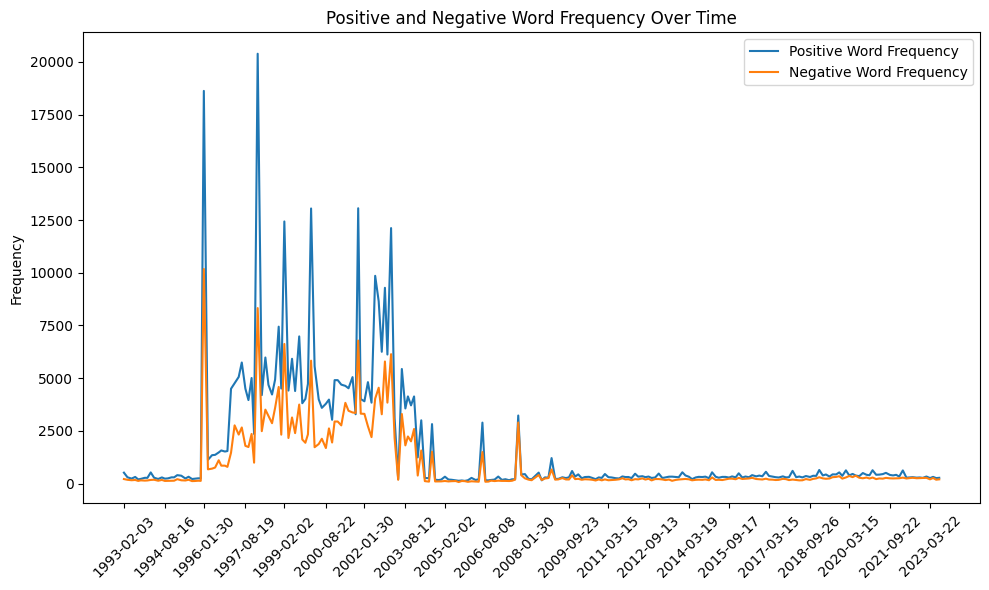

In [587]:
# Plotting the Positive Word Frequency and Negative Word Frequency
plt.figure(figsize=(10, 6))
plt.plot(dataset_el['Date'], dataset_el['Positive Word Frequency'], label='Positive Word Frequency')
plt.plot(dataset_el['Date'], dataset_el['Negative Word Frequency'], label='Negative Word Frequency')
plt.ylabel('Frequency')
plt.title('Positive and Negative Word Frequency Over Time')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Show only the 12th x-variable
x_ticks = dataset_el['Date'].iloc[::12]  # Select every 12th value
plt.xticks(x_ticks, rotation=45)

plt.tight_layout()  # Adjust the spacing of plot elements
plt.show()

In [588]:
# Assuming your dataset is stored in a DataFrame called 'dataset_el'
column_names = dataset_el.columns

# Print all the column names
for column in column_names:
    print(column)

Federal_Reserve_Mins
Preprocessed Text
Date
Difference
Increase
Decrease
Level
CPI
Unemployment Rate
Consumer Sentiment
Retail Sales
Durable Goods Orders
Short-Term Treasury Bond Rate
Long-Term Treasury Bond Rate
Bank Reserves
Housing Sales
Nonfarm Payroll
LEI
CEI
LAG
Treasury Deposits
Average Hourly Earnings
Net Sentiment Score
Positive Frequency
Negative Frequency
Sentiment Label
Proportion Positive Words
Proportion Negative Words
Word Count
Standardized Sentiment Score
Short-Term Treasury Diff
LEI_RollingMean
CEI_RollingMean
LAG_RollingMean
Retail Sales_RollingMean
Durable Goods Orders_RollingMean
Total Positive Sentiment
Total Negative Sentiment
Positive Word Frequency
Negative Word Frequency
Total Word Count


In [589]:
dataset_el['Short-Term Treasury Diff'] = dataset_el['Short-Term Treasury Bond Rate'].diff()
dataset_el['LEI_RollingMean'] = dataset_el['LEI'].rolling(window=3).mean()
dataset_el['CEI_RollingMean'] = dataset_el['CEI'].rolling(window=3).mean()
dataset_el['LAG_RollingMean'] = dataset_el['LAG'].rolling(window=3).mean()
dataset_el['Retail Sales_RollingMean'] = dataset_el['Retail Sales'].rolling(window=3).mean()
dataset_el['Durable Goods Orders_RollingMean'] = dataset_el['Durable Goods Orders'].rolling(window=3).mean()

# Shift up the rows in the specified columns
columns_to_shift = ['Total Positive Sentiment', 'Total Negative Sentiment', 'Net Sentiment Score', 'Positive Word Frequency', 'Negative Word Frequency', 'Total Word Count', 'Proportion Positive Words', 'Proportion Negative Words', 'Increase', 'Decrease']

for column in columns_to_shift:
    dataset_el.loc[:, column] = dataset_el[column].shift(-1)

# Remove the last row
dataset_el = dataset_el[:-1]

In [590]:
dataset_el

Federal_Reserve_Mins  \
0    A meeting of the Federal Open Market Committee...   
1    A meeting of the Federal Open Market Committee...   
2    A meeting of the Federal Open Market Committee...   
3    A meeting of the Federal Open Market Committee...   
4    A meeting of the Federal Open Market Committee...   
..                                                 ...   
238  The Federal Reserve, the central bank of the U...   
239  The Federal Reserve, the central bank of the U...   
240  The Federal Reserve, the central bank of the U...   
241  The Federal Reserve, the central bank of the U...   
242  The Federal Reserve, the central bank of the U...   

                                     Preprocessed Text       Date  Difference  \
0    meeting federal open market committee held off... 1993-02-03        0.00   
1    meeting federal open market committee held off... 1993-03-23        0.00   
2    meeting federal open market committee held off... 1993-05-18        0.00   
3    meeting federal open market committee held off... 1993-07-07       -0.50   
4    meeting federal open market committee held off... 1993-08-17        0.00   
..                                                 ...        ...         ...   
238  federal reserve central bank united state prov... 2022-12-14        0.50   
239  federal reserve central bank united state prov... 2023-02-01        0.25   
240  federal reserve central bank united state prov... 2023-03-22        0.25   
241  federal reserve central bank united state prov... 2023-05-03        0.25   
242  federal reserve central bank united state prov... 2023-06-14        0.00   

     Increase  Decrease  Level      CPI  Unemployment Rate  \
0        0.00       0.0   3.75  142.800                7.3   
1        0.00       0.5   3.75  143.300                7.0   
2        0.00       0.0   3.75  144.200                7.1   
3        0.00       0.0   3.25  144.500                6.9   
4        0.00       0.0   3.25  144.800                6.8   
..        ...       ...    ...      ...                ...   
238      0.25       0.0   4.50  298.990                3.5   
239      0.25       0.0   4.75  300.536                3.4   
240      0.00       0.0   5.00  301.808                3.5   
241      0.00       0.0   5.25  302.918                3.4   
242       NaN       NaN   5.25  303.841                3.6   

     Consumer Sentiment  ...  LEI_RollingMean  CEI_RollingMean  \
0                  89.3  ...              NaN              NaN   
1                  85.9  ...              NaN              NaN   
2                  80.3  ...        -1.202185        -0.241204   
3                  77.0  ...        -0.732514        -0.243730   
4                  77.3  ...        -0.403922        -0.065700   
..                  ...  ...              ...              ...   
238                59.7  ...         0.740169        -0.429712   
239                64.9  ...         1.089120        -0.349047   
240                62.0  ...         1.374926        -0.380924   
241                63.5  ...         1.542278        -0.185359   
242                64.4  ...         1.532658        -0.343737   

     LAG_RollingMean  Retail Sales_RollingMean  \
0                NaN                       NaN   
1                NaN                       NaN   
2           0.384181             157637.333333   
3          -0.094047             159391.000000   
4           0.180436             161975.666667   
..               ...                       ...   
238        -2.196739             595559.666667   
239        -2.272438             597911.333333   
240        -2.666227             595344.000000   
241        -2.171107             598100.333333   
242        -2.697990             597507.666667   

     Durable Goods Orders_RollingMean  Total Positive Sentiment  \
0                                 NaN                   692.525   
1                                 NaN                   375.450   
2                       

In [591]:
# Subset numerical columns
numerical_columns = dataset_el.select_dtypes(include='number')

# Remove 'Difference' from numerical columns
numerical_columns_subset = numerical_columns.drop('Difference', axis=1)

# Fill missing values with the mean in numerical columns
numerical_columns_subset.fillna(numerical_columns_subset.mean(), inplace=True)

# Define the dependent variable ('Difference')
y = dataset_el['Difference']

# Define the number of features to select
k = 15

# Perform univariate selection using f_regression
selector = SelectKBest(score_func=f_regression, k=k)
selected_features = selector.fit_transform(numerical_columns_subset, y)

# Get the selected feature indices
selected_indices = selector.get_support(indices=True)

# Get the selected feature names
selected_features_names = numerical_columns_subset.columns[selected_indices]

# Create a new dataframe with the selected features and 'Difference'
selected_dataset_lexicon = pd.concat([numerical_columns_subset[selected_features_names], y], axis=1)

# Get the feature scores
feature_scores = selector.scores_[selected_indices]

# Standardize the feature scores
scaler = StandardScaler()
standardized_scores = scaler.fit_transform(feature_scores.reshape(-1, 1))

# Print the selected features and their standardized relevance scores
print("Selected Features and Standardized Relevance Scores:")
for feature, score in zip(selected_features_names, standardized_scores):
    print(f"{feature}: {score[0]}")

Selected Features and Standardized Relevance Scores:
Increase: 0.5445948173765515
Decrease: -0.3707772416919083
Retail Sales: -0.39047283745398526
Durable Goods Orders: -0.3917897457803291
CEI: -0.3157828344247772
LAG: -0.2088861694087429
Negative Frequency: -0.33072257777498626
Proportion Negative Words: -0.3332977736528402
Standardized Sentiment Score: -0.2298385391811674
Short-Term Treasury Diff: 3.6460969113485633
LEI_RollingMean: -0.38136722816937985
CEI_RollingMean: -0.31731745166088926
LAG_RollingMean: -0.1894572742136499
Total Negative Sentiment: -0.3730478241594526
Negative Word Frequency: -0.35793423115300654


### Returning to the previous Lexicon, begin text vectorization

In [592]:
dataset = dataset_adjusted

In [606]:
# Define the CountVectorizer object
count_vectorizer = CountVectorizer()

vectorized_text = count_vectorizer.fit_transform(dataset['Preprocessed Text'])

# Get the feature names from the count_vectorizer instance
feature_names = count_vectorizer.get_feature_names_out()

# Create a DataFrame from the vectorized text
vectorized_df = pd.DataFrame(vectorized_text.toarray(), columns=["vectorized_text_" + feature_name for feature_name in feature_names])

# Reset index for both vectorized_df and dataset
vectorized_df_reset = vectorized_df.reset_index(drop=True)
dataset_reset = dataset.reset_index(drop=True)

# Concatenate the vectorized DataFrame with the original dataset
merged_dataset = pd.concat([dataset_reset, vectorized_df_reset], axis=1)

In [608]:
# Create a new dataset without the prefix
dataset_words = vectorized_df.rename(columns=lambda x: x.replace('vectorized_text_', ''))

#### The positivity and negativity from the Loughran McDonald Master Dictionary can then be applied to these vectorized words, giving each vector its own sentiment score as well. Variables with no sentiment are taken out, as some of them are just words like 

In [609]:
sentiment_word_list = {}

with open(csv_file_path, 'r') as file:
    # Skip the header line
    next(file)

    for line in file:
        # Split the line by comma
        values = line.strip().split(',')

        # Extract the necessary values
        word = values[0].lower()
        positive = float(values[8])  # Positive column index is 8
        negative = float(values[7])  # Negative column index is 7

        # Assign the word as positive or negative based on the positive or negative values
        if positive > 0:
            sentiment_word_list[word] = 1
        elif negative > 0:
            sentiment_word_list[word] = -1

# Remove 'vectorized_text_' prefix temporarily for searching sentiment words
prefix_len = len('vectorized_text_')

# Multiply sentiment values to the vectorized text columns
for column in merged_dataset.columns:
    if column.startswith('vectorized_text_'):  # Assuming vectorized text column names start with 'vectorized_text_'
        column_sentiment = column[prefix_len:]  # Extract the column sentiment name without the prefix
        column_sentiment = column_sentiment.lower()
        sentiment_value = sentiment_word_list.get(column_sentiment, 0)
        if sentiment_value == 1:
            merged_dataset[column] = merged_dataset[column] * 1  # Multiply by 1 for positive sentiment
        elif sentiment_value == -1:
            merged_dataset[column] = merged_dataset[column] * -1  # Multiply by -1 for negative sentiment
        else:
            merged_dataset[column] = merged_dataset[column] * 0  # Multiply by 0 for unknown sentiment

#### Univariate Variable Selection -- Dimensionality Reduction

In [610]:
# Subset numerical columns
numerical_columns = merged_dataset.select_dtypes(include='number')

# Remove 'Difference' from numerical columns
numerical_columns_subset = numerical_columns.drop('Difference', axis=1)

# Fill missing values with the mean in numerical columns
numerical_columns_subset.fillna(numerical_columns_subset.mean(), inplace=True)

# Fill missing values with the mean in 'Difference'
difference_mean = merged_dataset['Difference'].mean()
merged_dataset['Difference'].fillna(difference_mean, inplace=True)

# Define the number of features to select
k = 100

# Perform univariate selection using f_regression
selector = SelectKBest(score_func=f_regression, k=k)
selected_features = selector.fit_transform(numerical_columns_subset, merged_dataset['Difference'])

# Get the selected feature indices
selected_indices = selector.get_support(indices=True)

# Get the selected feature names
selected_features_names = numerical_columns_subset.columns[selected_indices]

# Create a new dataframe with the selected features and 'Difference'
selected_dataset = pd.concat([numerical_columns_subset[selected_features_names], merged_dataset['Difference']], axis=1)

# Get the feature scores
feature_scores = selector.scores_[selected_indices]

# Standardize the feature scores
scaler = StandardScaler()
standardized_scores = scaler.fit_transform(feature_scores.reshape(-1, 1))

# Print the selected features and their standardized relevance scores
print("Selected Features and Standardized Relevance Scores:")
for feature, score in zip(selected_features_names, standardized_scores):
    print(f"{feature}: {score[0]}")

Selected Features and Standardized Relevance Scores:
Increase: 2.074414705016199
Decrease: -0.13431005314341937
Retail Sales: -0.18881730039606284
Durable Goods Orders: -0.18934085876464504
CEI: -0.010014206859713473
LAG: 0.2499198991322759
Net Sentiment Score: 0.20034728866993826
Positive Frequency: -0.2377470841448331
Negative Frequency: -0.05077679975954744
Proportion Negative Words: 0.38390275547805053
Word Count: -0.22673787968753994
Standardized Sentiment Score: 0.2003472886699369
Short-Term Treasury Diff: 9.588382854059482
LEI_RollingMean: -0.16861248474212437
CEI_RollingMean: -0.013582391809559995
LAG_RollingMean: 0.2959004817911058
Retail Sales_RollingMean: -0.2026726793042671
Durable Goods Orders_RollingMean: -0.2546635938462207
vectorized_text_adverse: -0.04894586487620222
vectorized_text_attain: -0.0297241665309452
vectorized_text_breaching: -0.16995416429507632
vectorized_text_ceased: -0.1737600150523035
vectorized_text_concern: -0.24633267075497495
vectorized_text_contrac

#### Spot check to make sure that negative-sounding words have negative values

In [611]:
unique_weakness_values = selected_dataset['vectorized_text_weakness'].unique()
print(unique_weakness_values)

[  -5   -4   -1   -2    0 -365  -13  -14  -12  -26  -40  -24  -32   -8
  -23 -120  -33 -118  -94  -20 -151  -54 -137  -16  -29   -9  -15  -85
   -6  -52 -255 -168 -249 -345 -293 -233 -396 -341 -211  -61  -79 -245
 -144 -236 -153 -146  -58  -81  -55  -38  -56  -27   -3  -65  -19  -76
  -11]


In [612]:
# Count the occurrences of 'prosperity'
total_count = selected_dataset['vectorized_text_weakness'].sum()

# Print the total count
print(f"Total count of 'weakness': {total_count}")

Total count of 'weakness': -6406


In [613]:
# Create a new dataset without the prefix
final_dataset = selected_dataset.rename(columns=lambda x: x.replace('vectorized_text_', ''))

# Print the column names of the new dataset
print(final_dataset.columns)

Index(['Increase', 'Decrease', 'Retail Sales', 'Durable Goods Orders', 'CEI',
       'LAG', 'Net Sentiment Score', 'Positive Frequency',
       'Negative Frequency', 'Proportion Negative Words',
       ...
       'unwilling', 'upturn', 'volatile', 'weak', 'weaken', 'weakened',
       'weakening', 'weaker', 'weakness', 'Difference'],
      dtype='object', length=101)


#### Spot Check that all variables have meaningful data

In [614]:
selected_columns = final_dataset.columns[26:]

# Iterate over the selected columns
for column in selected_columns:
    # Get the unique values and their frequencies
    value_counts = final_dataset[column].value_counts()
    
    # Print the column name
    print(f"Column: {column}")
    
    # Print the unique values and frequencies
    for value, frequency in value_counts.items():
        print(f"Value: {value}, Frequency: {frequency}")
    
    print()  

Column: cut
Value: 0, Frequency: 133
Value: -1, Frequency: 46
Value: -2, Frequency: 17
Value: -3, Frequency: 7
Value: -4, Frequency: 4
Value: -5, Frequency: 4
Value: -7, Frequency: 3
Value: -15, Frequency: 2
Value: -41, Frequency: 2
Value: -17, Frequency: 1
Value: -39, Frequency: 1
Value: -12, Frequency: 1
Value: -32, Frequency: 1
Value: -19, Frequency: 1
Value: -100, Frequency: 1
Value: -8, Frequency: 1
Value: -29, Frequency: 1
Value: -30, Frequency: 1
Value: -37, Frequency: 1
Value: -23, Frequency: 1
Value: -31, Frequency: 1
Value: -86, Frequency: 1
Value: -44, Frequency: 1
Value: -66, Frequency: 1
Value: -24, Frequency: 1
Value: -25, Frequency: 1
Value: -52, Frequency: 1
Value: -48, Frequency: 1
Value: -50, Frequency: 1
Value: -6, Frequency: 1
Value: -33, Frequency: 1
Value: -46, Frequency: 1

Column: cutback
Value: 0, Frequency: 194
Value: -1, Frequency: 27
Value: -2, Frequency: 6
Value: -4, Frequency: 3
Value: -40, Frequency: 2
Value: -3, Frequency: 1
Value: -111, Frequency: 1
Val

In [615]:
final_dataset['Date'] = dataset['Date']

In [617]:
final_dataset

Increase  Decrease  Retail Sales  Durable Goods Orders       CEI  \
0    0.000000  0.000000      160605.0              126529.0 -0.112893   
1    0.000000  0.000000      162816.0              128111.0 -0.050447   
2    0.000000  0.000000      162506.0              129378.0 -0.033761   
3    0.000000  0.000000      163258.0              127233.0  0.466864   
4    0.250000  0.000000      166594.0              130391.0  0.503218   
..        ...       ...           ...                   ...       ...   
236  0.250000  0.000000      588540.0              281966.0 -0.745184   
237  0.250000  0.000000      603211.0              278372.0  0.120006   
238  0.000000  0.000000      594281.0              279837.0 -0.517594   
239  0.000000  0.000000      596809.0              283311.0 -0.158490   
240  0.067708  0.044792      601433.0              302077.0 -0.355128   

          LAG  Net Sentiment Score  Positive Frequency  Negative Frequency  \
0    0.469678                -24.0                88.0               112.0   
1   -0.028876                -23.0                61.0                84.0   
2    0.100506                -24.0                75.0                99.0   
3    1.673479                -15.0                81.0                96.0   
4    1.740168                 -6.0                89.0                95.0   
..        ...                  ...                 ...                 ...   
236 -3.592363                -94.0                80.0               174.0   
237 -1.132914                -74.0                52.0               126.0   
238 -3.273404               -135.0                67.0               202.0   
239 -2.107003                -62.0                56.0               118.0   
240 -2.713564                -62.0                65.0               127.0   

     Proportion Negative Words  ...  upturn  volatile  weak  weaken  weakened  \
0                     0.026242  ...       2         0    -3       0         0   
1                     0.029381  ...       2         0    -3       0         0   
2                     0.032512  ...       0         0    -1      -1         0   
3                     0.026801  ...       0        -1    -2       0         0   
4                     0.027127  ...       0        -1    -2       0         0   
..                         ...  ...     ...       ...   ...     ...       ...   
236                   0.030950  ...       0         0    -2       0         0   
237                   0.025931  ...       0        -1     0      -1         0   
238                   0.037892  ...       0        -1     0       0         0   
239                   0.025781  ...       0        -2    -4      -1         0   
240                   0.028197  ...       0        -1    -3      -1         0   

     weakening  weaker  weakness  Difference       Date  
0            0       0        -5        0.00        NaT  
1            0      -2        -4       -0.50        NaT  
2            0       0        -1        0.00 1993-05-18  
3            0       0        -4        0.00 1993-07-07  
4            0      -1        -1        0.00 1993-08-17  
..         ...     ...       ...         ...        ...  
236         -2      -2         0        0.50 2022-09-21  
237          0      -3        -1        0.25 2022-11-02  
238         -2       0         0        0.25 2022-12-14  
239          0       0        -1        0.25 2023-02-01  
240          0      -1        -1        0.00 2023-03-22  

[241 rows x 102 columns]

In [616]:
possible_values = [-1.00, -0.75, -0.50, -0.25, 0.00, 0.25, 0.50, 0.75, 1.00]
prep_df = final_dataset[final_dataset['Difference'].isin(possible_values)]
possible_values = [0.00, 0.25, 0.50, 0.75, 1.00]
prep_df = prep_df[
    (prep_df['Increase'].isin(possible_values)) &
    (prep_df['Decrease'].isin(possible_values))
]

In [968]:
# Split into training, validation, and test sets
train_data, val_test_data = train_test_split(prep_df, test_size=0.2, shuffle=False)

# Split the combined set into validation and test sets
val_data, test_data = train_test_split(val_test_data, test_size=0.5, shuffle=False)

# Verify the sizes of each set
print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))

Training set size: 192
Validation set size: 24
Test set size: 24


In [969]:
train = train_data
valid = val_data
test = test_data

## Model Creation -- Preparation

In [970]:
# Convert variables to numeric in the train dataset
variables_to_convert = train.columns.drop('Date')
train[variables_to_convert] = train[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the valid dataset
valid[variables_to_convert] = valid[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the test dataset
test[variables_to_convert] = test[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Prepare the data for the model
X_train = train.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_train = train['Difference']  # Use the 'Difference' variable as the target

X_valid = valid.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_valid = valid['Difference']  # Use the 'Difference' variable as the target

X_test = test.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_test = test['Difference']  # Use the 'Difference' variable as the target

possible_values = [-1.00, -0.75, -0.50, -0.25, 0.00, 0.25, 0.50, 0.75, 1.00]

def round_to_nearest(value, possible_values):
    return min(possible_values, key=lambda x: abs(x - value))

def calculate_accuracy(y_true, y_pred):
    correct_predictions = 0
    total_predictions = len(y_true)
    
    for true_val, pred_val in zip(y_true, y_pred):
        if true_val == pred_val:
            correct_predictions += 1
            
    accuracy = correct_predictions / total_predictions
    return accuracy

# Function to select top features based on feature importances
def select_top_features(feature_importances, max_features):
    # Get indices of top features based on feature importances
    top_feature_indices = np.argsort(feature_importances)[::-1][:max_features]
    return top_feature_indices

In [971]:
def calculate_metrics(y_train, y_train_pred, y_valid, y_valid_pred, X_train, X_valid, calculate_accuracy):
    # Calculate Mean Squared Error (MSE) for training set
    mse_train = mean_squared_error(y_train, y_train_pred)

    # Calculate Mean Squared Error (MSE) for validation set
    mse_valid = mean_squared_error(y_valid, y_valid_pred)

    # Calculate Root Mean Squared Error (RMSE) for training set
    rmse_train = np.sqrt(mse_train)

    # Calculate Root Mean Squared Error (RMSE) for validation set
    rmse_valid = np.sqrt(mse_valid)

    # Calculate R-squared (R^2) for training set
    r2_train = r2_score(y_train, y_train_pred)

    # Calculate R-squared (R^2) for validation set
    r2_valid = r2_score(y_valid, y_valid_pred)

    # Calculate adjusted R-squared for training set
    n_train = X_train.shape[0]
    p_train = X_train.shape[1]
    adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

    # Calculate adjusted R-squared for validation set
    n_valid = X_valid.shape[0]
    p_valid = X_valid.shape[1]
    adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

    # Calculate accuracy for training and validation sets
    accuracy_train = calculate_accuracy(y_train, y_train_pred)
    accuracy_valid = calculate_accuracy(y_valid, y_valid_pred)

    # Prepare the data for the table
    data = [
        ["MSE", mse_train, mse_valid],
        ["RMSE", rmse_train, rmse_valid],
        ["R^2", r2_train, r2_valid],
        ["Adjusted R^2", adj_r2_train, adj_r2_valid],
        ["Accuracy", accuracy_train, accuracy_valid],
    ]

    # Prepare the headers for the table
    headers = ["Metric", "Training Set", "Validation Set"]

    # Display the table
    table = tabulate(data, headers=headers, tablefmt="grid")
    print(table)

## First Modeling Approach -- Ordinary Least Squares

### Subset Selection OLS

In [636]:
# Create a copy of the 'train' DataFrame
test_data = train.copy()

# Create an empty DataFrame to store the results
variable_selection_results = pd.DataFrame(columns=['Variable', 't-statistic', 'p-value'])

# Iterate over each predictor variable in the 'test_data' dataset
for predictor_variable in test_data.columns:
    if predictor_variable != 'Difference' and predictor_variable != 'Date':
        # Convert predictor variable to numeric type
        test_data[predictor_variable] = pd.to_numeric(test_data[predictor_variable], errors='coerce')
        
        # Perform the t-test
        t_stat, p_value = stats.ttest_ind(test_data[predictor_variable], test_data['Difference'], nan_policy='omit')
        
        # Store the results in the DataFrame
        variable_selection_results = pd.concat([
            variable_selection_results,
            pd.DataFrame({
                'Variable': [predictor_variable],
                't-statistic': [t_stat],
                'p-value': [p_value]
            })
        ], ignore_index=True)

# Sort the results by p-value in ascending order
variable_selection_results = variable_selection_results.sort_values(by='p-value', ascending=True)

top_15_variable_names = variable_selection_results['Variable'].head(15)

In [637]:
print(top_15_variable_names)

17    Durable Goods Orders_RollingMean
3                 Durable Goods Orders
2                         Retail Sales
16            Retail Sales_RollingMean
11        Standardized Sentiment Score
10                          Word Count
8                   Negative Frequency
7                   Positive Frequency
22                             concern
28                             decline
46                           favorable
29                            declined
6                  Net Sentiment Score
41                             dropped
66                            positive
Name: Variable, dtype: object


In [638]:
# Add the selected independent variables to the model
X = sm.add_constant(test_data[top_15_variable_names])

# Fit the OLS model and rename it as 'ols_model_1'
ols_model_1 = sm.OLS(test_data['Difference'], X).fit()

In [639]:
# Add the selected independent variables to the model
X = sm.add_constant(test_data[top_15_variable_names])

# Fit the OLS model and rename it as 'ols_model_1'
ols_model_1 = sm.OLS(test_data['Difference'], X).fit()

# Get the fitted values from the model for the training set
y_train_pred = ols_model_1.fittedvalues

# Convert fitted values to the closest allowed values for the training set
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Make predictions on the validation set
X_valid = sm.add_constant(valid[top_15_variable_names])
y_valid_pred = ols_model_1.predict(X_valid)

# Convert fitted values to the closest allowed values for the validation set
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

In [640]:
# Call the function with appropriate arguments
calculate_metrics(y_train, y_train_pred, y_valid, y_valid_pred, X_train, X_valid, calculate_accuracy)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |      0.0345052 |        0.0703125 |
+--------------+----------------+------------------+
| RMSE         |      0.185756  |        0.265165  |
+--------------+----------------+------------------+
| R^2          |      0.138175  |       -0.081803  |
+--------------+----------------+------------------+
| Adjusted R^2 |     -0.769985  |       -2.5545    |
+--------------+----------------+------------------+
| Accuracy     |      0.666667  |        0.541667  |
+--------------+----------------+------------------+


### All Variables OLS

In [641]:
# Convert variables to numeric in the train dataset
variables_to_convert = train.columns.drop('Date')
train[variables_to_convert] = train[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the valid dataset
valid[variables_to_convert] = valid[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Prepare the data for the model
X_train = train.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_train = train['Difference']  # Use the 'Difference' variable as the target

X_valid = valid.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_valid = valid['Difference']  # Use the 'Difference' variable as the target

In [642]:
# Add the selected independent variables to the model
X_train = sm.add_constant(X_train)  # Add constant for the intercept term
ols_model_2 = sm.OLS(y_train, X_train).fit()

# Get the fitted values from the model for the training set
y_train_pred = ols_model_2.fittedvalues

# Convert fitted values to the closest allowed values for the training set
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Make predictions on the validation set
X_valid = sm.add_constant(X_valid)  # Add constant for the intercept term
y_valid_pred = ols_model_2.predict(X_valid)

# Convert fitted values to the closest allowed values for the validation set
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

In [643]:
# Call the function with appropriate arguments
calculate_metrics(y_train, y_train_pred, y_valid, y_valid_pred, X_train, X_valid, calculate_accuracy)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |     0.00716146 |        0.0598958 |
+--------------+----------------+------------------+
| RMSE         |     0.0846254  |        0.244736  |
+--------------+----------------+------------------+
| R^2          |     0.821131   |        0.0784641 |
+--------------+----------------+------------------+
| Adjusted R^2 |     0.628652   |        1.27889   |
+--------------+----------------+------------------+
| Accuracy     |     0.901042   |        0.5       |
+--------------+----------------+------------------+


### Reverse Variable Selection (p-value) OLS

In [644]:
def perform_reverse_variable_selection(X, y, threshold):
    model = sm.OLS(y, sm.add_constant(X)).fit()
    
    while True:
        p_values = model.pvalues[1:]  # Exclude the constant term
        
        # Find the predictor variable with the highest p-value
        max_p_value = p_values.max()
        if max_p_value <= threshold:
            break
        
        # Remove the predictor variable with the highest p-value
        max_p_var = p_values.idxmax()
        X = X.drop(max_p_var, axis=1)
        
        # Fit the model with the updated set of predictor variables
        model = sm.OLS(y, sm.add_constant(X)).fit()
    
    return model

# Perform reverse variable selection with a threshold of 0.05
threshold = 0.05
ols_model_3 = perform_reverse_variable_selection(X_train, y_train, threshold)

In [645]:
# Extract the remaining variables in X_train after variable selection
selected_variables = ols_model_3.model.exog_names[1:]  # Exclude the constant term
X_train = train[selected_variables]

# Add the selected independent variables to the model
X_train = sm.add_constant(X_train)  # Add constant for the intercept term
ols_model_3 = sm.OLS(y_train, X_train).fit()

# Get the fitted values from the model for the training set
y_train_pred = ols_model_3.fittedvalues

# Convert fitted values to the closest allowed values for the training set
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Make predictions on the validation set
X_valid = valid[selected_variables]  # Use the selected variables in the validation set
X_valid = sm.add_constant(X_valid)  # Add constant for the intercept term
y_valid_pred = ols_model_3.predict(X_valid)

# Convert fitted values to the closest allowed values for the validation set
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

y_valid = valid['Difference']  # Use the 'Difference' variable as the target

In [646]:
# Call the function with appropriate arguments
calculate_metrics(y_train, y_train_pred, y_valid, y_valid_pred, X_train, X_valid, calculate_accuracy)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |      0.0120443 |        0.0494792 |
+--------------+----------------+------------------+
| RMSE         |      0.109746  |        0.222439  |
+--------------+----------------+------------------+
| R^2          |      0.699174  |        0.238731  |
+--------------+----------------+------------------+
| Adjusted R^2 |      0.677204  |       -0.750918  |
+--------------+----------------+------------------+
| Accuracy     |      0.822917  |        0.666667  |
+--------------+----------------+------------------+


### Reverse Variable Selection (AICc) OLS

In [648]:
def perform_reverse_variable_selection(X, y, threshold):
    model = sm.OLS(y, sm.add_constant(X)).fit()
    
    while True:
        p_values = model.pvalues[1:]  # Exclude the constant term
        
        # Find the predictor variable with the highest p-value
        max_p_value = p_values.max()
        if max_p_value <= threshold:
            break
        
        # Remove the predictor variable with the highest p-value
        max_p_var = p_values.idxmax()
        X = X.drop(max_p_var, axis=1)
        
        # Fit the model with the updated set of predictor variables
        model = sm.OLS(y, sm.add_constant(X)).fit()
    
    return model

# Perform reverse variable selection with a threshold of 0.05
threshold = 0.05
ols_model_4 = perform_reverse_variable_selection(X_train, y_train, threshold)

In [649]:
# Extract the remaining variables in X_train after variable selection based on AICc
selected_variables = ols_model_4.model.exog_names[1:]  # Exclude the constant term
X_train_ridge = train[selected_variables]
y_train_ridge = train['Difference']  # Use the 'Difference' variable as the target

# Add the constant term for the intercept (if needed)
X_train_ridge = sm.add_constant(X_train_ridge)

# Initialize and fit the Ridge Regression model with the selected variables
ridge_alpha = 1.0  # The regularization strength (alpha parameter)
ridge_model = Ridge(alpha=ridge_alpha)
ridge_model.fit(X_train_ridge, y_train_ridge)

# Get the fitted values from the model for the training set
y_train_pred_ridge = ridge_model.predict(X_train_ridge)

# Convert fitted values to the closest allowed values for the training set
y_train_pred_ridge = [round_to_nearest(pred, possible_values) for pred in y_train_pred_ridge]

# Make predictions on the validation set
X_valid_ridge = valid[selected_variables]  # Use the selected variables in the validation set
X_valid_ridge = sm.add_constant(X_valid_ridge)  # Add constant for the intercept term
y_valid_pred_ridge = ridge_model.predict(X_valid_ridge)

# Convert fitted values to the closest allowed values for the validation set
y_valid_pred_ridge = [round_to_nearest(pred, possible_values) for pred in y_valid_pred_ridge]

y_valid_ridge = valid['Difference']  # Use the 'Difference' variable as the target

In [650]:
# Call the function with appropriate arguments
calculate_metrics(y_train, y_train_pred, y_valid, y_valid_pred, X_train, X_valid, calculate_accuracy)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |      0.0120443 |        0.0494792 |
+--------------+----------------+------------------+
| RMSE         |      0.109746  |        0.222439  |
+--------------+----------------+------------------+
| R^2          |      0.699174  |        0.238731  |
+--------------+----------------+------------------+
| Adjusted R^2 |      0.677204  |       -0.750918  |
+--------------+----------------+------------------+
| Accuracy     |      0.822917  |        0.666667  |
+--------------+----------------+------------------+


## Second Modeling Approach -- Random Forest

### Manual Hyperparameter Selection Random Forest

In [972]:
# Create a random forest regressor with 100 trees
rf_model_1 = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model_1.fit(X_train, y_train)

# Predict y_train_pred on the training set
y_train_pred = rf_model_1.predict(X_train)

# Predict y_valid_pred on the validation set
y_valid_pred = rf_model_1.predict(X_valid)

# Round the predicted values to the nearest possible value
y_train_pred = [round_to_nearest(val, possible_values) for val in y_train_pred]
y_valid_pred = [round_to_nearest(val, possible_values) for val in y_valid_pred]

# Get the feature importances from the best model
feature_importances = rf_model_1.feature_importances_

# Get the number of features used (non-zero feature importances)
num_features_used = np.sum(feature_importances > 0)

num_features_used

76

In [973]:
# Call the function with appropriate arguments
calculate_metrics(y_train, y_train_pred, y_valid, y_valid_pred, X_train, X_valid, calculate_accuracy)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |     0.00227865 |        0.0286458 |
+--------------+----------------+------------------+
| RMSE         |     0.0477352  |        0.169251  |
+--------------+----------------+------------------+
| R^2          |     0.943087   |        0.559265  |
+--------------+----------------+------------------+
| Adjusted R^2 |     0.883114   |        1.13516   |
+--------------+----------------+------------------+
| Accuracy     |     0.963542   |        0.666667  |
+--------------+----------------+------------------+


### Optimal Hyperparameter Selection Random Forest

In [705]:
param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 65, 70],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Create GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model_1, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the model to the training data and find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best model with optimal hyperparameters
rf_model_2 = grid_search.best_estimator_

# Predict y_train_pred on the training set
y_train_pred = rf_model_2.predict(X_train)

# Predict y_valid_pred on the validation set
y_valid_pred = rf_model_2.predict(X_valid)

# Round the predicted values to the nearest possible value
y_train_pred = [round_to_nearest(val, possible_values) for val in y_train_pred]
y_valid_pred = [round_to_nearest(val, possible_values) for val in y_valid_pred]

# Get the feature importances from the best model
feature_importances = rf_model_2.feature_importances_

# Get the number of features used (non-zero feature importances)
num_features_used = np.sum(feature_importances > 0)

# Print the number of features used in the last iteration
print("Number of Featurees Used:", num_features_used)

# Extract the random seed from the last element of the random_seeds list
random_seed_used = random_seeds[-1]

# Print the random seed used in the last iteration
print("Random Seed Used:", random_seed_used)

Number of Featurees Used: 51
Random Seed Used: 1073137954


In [706]:
# Call the function with appropriate arguments
calculate_metrics(y_train, y_train_pred, y_valid, y_valid_pred, X_train, X_valid, calculate_accuracy)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |     0.00358073 |        0.0182292 |
+--------------+----------------+------------------+
| RMSE         |     0.0598392  |        0.135015  |
+--------------+----------------+------------------+
| R^2          |     0.910565   |        0.719533  |
+--------------+----------------+------------------+
| Adjusted R^2 |     0.816322   |        1.08601   |
+--------------+----------------+------------------+
| Accuracy     |     0.942708   |        0.708333  |
+--------------+----------------+------------------+


In [684]:
# List to store random seeds used in each iteration
random_seeds = []

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

best_accuracy = -1.0
optimal_cv = None
best_y_train_pred = None
best_y_valid_pred = None

for cv in range(2, 11):  # Try cross-validation folds from 2 to 10
    grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get the best model with optimal hyperparameters
    best_rf_model_3 = grid_search.best_estimator_

    # Predict y_train_pred on the training set
    y_train_pred = best_rf_model_3.predict(X_train)

    # Predict y_valid_pred on the validation set
    y_valid_pred = best_rf_model_3.predict(X_valid)

    # Round the predicted values to the nearest possible value
    y_train_pred = [round_to_nearest(val, possible_values) for val in y_train_pred]
    y_valid_pred = [round_to_nearest(val, possible_values) for val in y_valid_pred]

    # Calculate accuracy for training and validation sets after rounding
    accuracy_train = calculate_accuracy(y_train, y_train_pred)
    accuracy_valid = calculate_accuracy(y_valid, y_valid_pred)
    
    # Check if the accuracy after rounding is higher than the best accuracy so far
    if accuracy_valid > best_accuracy:
        best_accuracy = accuracy_valid
        optimal_cv = cv
        best_y_train_pred = y_train_pred
        best_y_valid_pred = y_valid_pred

    # Store the random seed used in this iteration
    random_seeds.append(np.random.get_state()[1][0])

# Use the optimal number of folds in GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=optimal_cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model with optimal hyperparameters
rf_model_3 = grid_search.best_estimator_

# Get the feature importances from the best model
feature_importances = rf_model_3.feature_importances_

# Get the number of features used (non-zero feature importances)
num_features_used = np.sum(feature_importances > 0)

# Print the number of features used in the last iteration
print("Number of Featurees Used:", num_features_used)

# Extract the random seed from the last element of the random_seeds list
random_seed_used = random_seeds[-1]

# Print the random seed used in the last iteration
print("Random Seed Used:", random_seed_used)

Number of Featurees Used: 11
Random Seed Used: 1073137954


In [685]:
# Call the function with appropriate arguments
calculate_metrics(y_train, y_train_pred, y_valid, y_valid_pred, X_train, X_valid, calculate_accuracy)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |     0.00585938 |         0.03125  |
+--------------+----------------+------------------+
| RMSE         |     0.0765466  |         0.176777 |
+--------------+----------------+------------------+
| R^2          |     0.853652   |         0.519199 |
+--------------+----------------+------------------+
| Adjusted R^2 |     0.842964   |        -0.105843 |
+--------------+----------------+------------------+
| Accuracy     |     0.90625    |         0.625    |
+--------------+----------------+------------------+


## Third Modeling Approach -- XGBoost

### All Variables XGBoost

In [686]:
# Initialize and train the XGBoost model
xgb_model_1 = xgb.XGBRegressor()
xgb_model_1.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = xgb_model_1.predict(X_train)

# Make predictions on the validation set
y_valid_pred = xgb_model_1.predict(X_valid)

# Example usage for y_train_pred
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Example usage for y_valid_pred
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

num_variables = len(X_train)
print("Number of variables in selected_features:", num_variables)

Number of variables in selected_features: 192


In [687]:
# Call the function with appropriate arguments
calculate_metrics(y_train, y_train_pred, y_valid, y_valid_pred, X_train, X_valid, calculate_accuracy)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |              0 |         0.03125  |
+--------------+----------------+------------------+
| RMSE         |              0 |         0.176777 |
+--------------+----------------+------------------+
| R^2          |              1 |         0.519199 |
+--------------+----------------+------------------+
| Adjusted R^2 |              1 |        -0.105843 |
+--------------+----------------+------------------+
| Accuracy     |              1 |         0.75     |
+--------------+----------------+------------------+


### Reverse Variable Selection XGBoost

In [688]:
# Initialize and train the XGBoost model
xgb_model_2 = xgb.XGBRegressor()
xgb_model_2.fit(X_train, y_train)

# Step 1: Evaluate initial model performance
best_model_score = xgb_model_2.score(X_valid, y_valid)

# Step 2 to 6: Reverse variable selection loop
selected_features = list(X_train.columns)
for feature in X_train.columns:
    # Temporarily remove the feature
    X_train_subset = X_train.drop(feature, axis=1)
    X_valid_subset = X_valid.drop(feature, axis=1)
    
    # Retrain the model without the removed feature
    xgb_model_subset = xgb.XGBRegressor()
    xgb_model_subset.fit(X_train_subset, y_train)
    
    # Evaluate the model performance on the validation set
    model_score = xgb_model_subset.score(X_valid_subset, y_valid)
    
    # Check if the model performance improved
    if model_score > best_model_score:
        best_model_score = model_score
        xgb_model_2 = xgb_model_subset  # Update the best model

print("Best Model Score:", best_model_score)

num_variables = len(selected_features)
print("Number of variables in selected_features:", num_variables)

Best Model Score: 0.6250171448739491
Number of variables in selected_features: 13


In [689]:
# Assuming 'selected_features' contains the list of best selected features
selected_X_train = X_train[selected_features]
selected_X_valid = X_valid[selected_features]

# Initialize and train the XGBoost model with the best selected features
xgb_model_2 = xgb.XGBRegressor()
xgb_model_2.fit(selected_X_train, y_train)

# Make predictions on the training set with the best selected features
y_train_pred = xgb_model_2.predict(selected_X_train)

# Make predictions on the validation set with the best selected features
y_valid_pred = xgb_model_2.predict(selected_X_valid)

# Example usage for y_train_pred
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Example usage for y_valid_pred
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

In [690]:
# Call the function with appropriate arguments
calculate_metrics(y_train, y_train_pred, y_valid, y_valid_pred, X_train, X_valid, calculate_accuracy)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |              0 |         0.03125  |
+--------------+----------------+------------------+
| RMSE         |              0 |         0.176777 |
+--------------+----------------+------------------+
| R^2          |              1 |         0.519199 |
+--------------+----------------+------------------+
| Adjusted R^2 |              1 |        -0.105843 |
+--------------+----------------+------------------+
| Accuracy     |              1 |         0.75     |
+--------------+----------------+------------------+


### Subset Selection XGBoost

In [691]:
# Extract feature importance
feature_importance = xgb_model_1.feature_importances_

# Create a dictionary to map feature names to their importance scores
feature_importance_dict = {feature_name: importance_score for feature_name, importance_score in zip(X_train.columns, feature_importance)}

# Sort the feature importance dictionary in descending order based on importance scores
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

# Filter features with importance greater than 0.01
selected_features = [feature_name for feature_name, importance_score in feature_importance_dict.items() if importance_score > 0.01]

# Create new datasets with selected features
selected_X_train = X_train[selected_features]
selected_X_valid = X_valid[selected_features]

# Initialize and train the XGBoost model with the selected features
xgb_model = xgb.XGBRegressor()
xgb_model.fit(selected_X_train, y_train)

# Make predictions on the training set with the selected features
y_train_pred = xgb_model.predict(selected_X_train)

# Make predictions on the validation set with the selected features
y_valid_pred = xgb_model.predict(selected_X_valid)

# Example usage for y_train_pred
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Example usage for y_valid_pred
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

num_variables = len(selected_features)
print("Number of variables in selected_features:", num_variables)

Number of variables in selected_features: 10


In [692]:
# Call the function with appropriate arguments
calculate_metrics(y_train, y_train_pred, y_valid, y_valid_pred, X_train, X_valid, calculate_accuracy)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |              0 |        0.0364583 |
+--------------+----------------+------------------+
| RMSE         |              0 |        0.190941  |
+--------------+----------------+------------------+
| R^2          |              1 |        0.439065  |
+--------------+----------------+------------------+
| Adjusted R^2 |              1 |       -0.29015   |
+--------------+----------------+------------------+
| Accuracy     |              1 |        0.666667  |
+--------------+----------------+------------------+


## Best Model Selection and Performance

### The second Random Forest Model, which optimized over hyperparameters, had the highest accuracy score. Thus, it will be used going forward

In [974]:
# Get predictions for the training set
best_y_train_pred = rf_model_2.predict(X_train)

# Get predictions for the validation set
best_y_valid_pred = rf_model_2.predict(X_valid)

# Get predictions for the test set
best_y_test_pred = rf_model_2.predict(X_test)

# Round the predicted values to the nearest possible value
best_y_train_pred = [round_to_nearest(val, possible_values) for val in best_y_train_pred]
best_y_valid_pred = [round_to_nearest(val, possible_values) for val in best_y_valid_pred]
best_y_test_pred = [round_to_nearest(val, possible_values) for val in best_y_test_pred]

In [975]:
# Function to calculate accuracy based on a threshold
def calculate_accuracy(y_true, y_pred):
    num_samples = len(y_true)
    correct_predictions = sum(abs(y_true - y_pred) <= threshold)
    return correct_predictions / num_samples

# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, best_y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, best_y_valid_pred)

# Calculate Mean Squared Error (MSE) for test set
mse_test = mean_squared_error(y_test, best_y_test_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate Root Mean Squared Error (RMSE) for test set
rmse_test = np.sqrt(mse_test)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, best_y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, best_y_valid_pred)

# Calculate R-squared (R^2) for test set
r2_test = r2_score(y_test, best_y_test_pred)

# Calculate adjusted R-squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid.shape[0]
p_valid = X_valid.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate adjusted R-squared for test set
n_test = X_test.shape[0]
p_test = X_test.shape[1]
adj_r2_test = 1 - ((1 - r2_test) * (n_test - 1) / (n_test - p_test - 1))

# Calculate accuracy for training, validation, and test sets with the threshold
accuracy_train = calculate_accuracy(y_train, best_y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, best_y_valid_pred)
accuracy_test = calculate_accuracy(y_test, best_y_test_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid, mse_test],
    ["RMSE", rmse_train, rmse_valid, rmse_test],
    ["R^2", r2_train, r2_valid, r2_test],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid, adj_r2_test],
    ["Accuracy", accuracy_train, accuracy_valid, accuracy_test],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set", "Test Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+------------+
| Metric       |   Training Set |   Validation Set |   Test Set |
+==============+================+==================+============+
| MSE          |     0.00358073 |        0.0182292 |  0.0494792 |
+--------------+----------------+------------------+------------+
| RMSE         |     0.0598392  |        0.135015  |  0.222439  |
+--------------+----------------+------------------+------------+
| R^2          |     0.910565   |        0.719533  |  0.393617  |
+--------------+----------------+------------------+------------+
| Adjusted R^2 |     0.816322   |        1.08601   |  1.18596   |
+--------------+----------------+------------------+------------+
| Accuracy     |     0.942708   |        0.708333  |  0.708333  |
+--------------+----------------+------------------+------------+


### Residual Plot

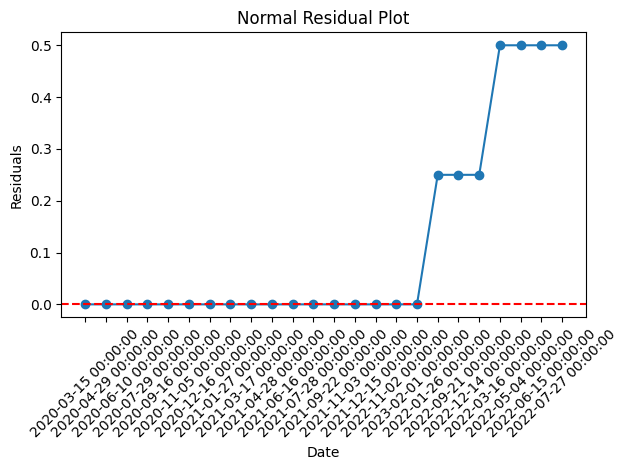

In [881]:
# Calculate the residuals (differences between predicted and true values)
residuals = y_test - best_y_test_pred

# Create a list of tuples with (residual, date) pairs
residual_date_pairs = list(zip(residuals, test['Date']))

# Sort the pairs based on the residuals
residual_date_pairs.sort()

# Unpack the sorted pairs into separate lists
sorted_residuals, sorted_dates = zip(*residual_date_pairs)

# Convert Timestamp objects to strings for x-axis labels
sorted_dates = [str(date) for date in sorted_dates]

# Create the residual plot with sorted residuals and 'Date' on the x-axis
plt.plot(sorted_dates, sorted_residuals, marker='o')
plt.axhline(y=0, color='r', linestyle='--')  # Add a red dashed line at y=0 for reference
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.title("Normal Residual Plot")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

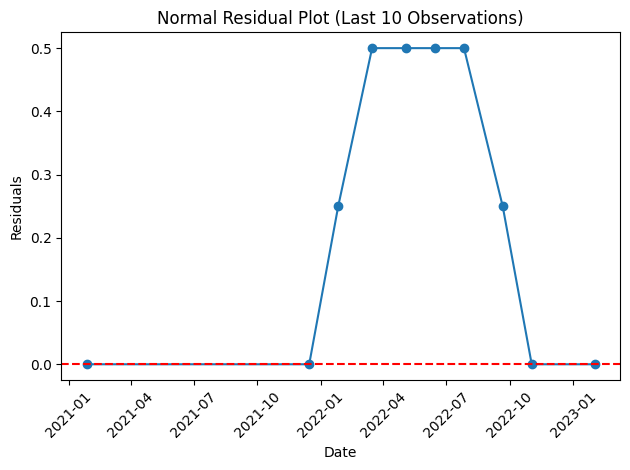

In [882]:
# Convert the lists to NumPy arrays
y_test = np.array(y_test)
best_y_test_pred = np.array(best_y_test_pred)

# Calculate the residuals (differences between predicted and true values)
residuals = y_test - best_y_test_pred

# Sort the residuals and 'Date' based on the predicted values
sorted_indices = best_y_test_pred.argsort()
sorted_residuals = residuals[sorted_indices]
sorted_dates = test['Date'].iloc[sorted_indices]

# Select the last 10 observations
last_10_residuals = sorted_residuals[-10:]
last_10_dates = sorted_dates[-10:]

# Create the residual plot with last 10 observations and 'Date' on the x-axis
plt.plot(last_10_dates, last_10_residuals, marker='o')
plt.axhline(y=0, color='r', linestyle='--')  # Add a red dashed line at y=0 for reference
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.title("Normal Residual Plot (Last 10 Observations)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

## Data-Centric AI

### Revisiting Bias in the proportion of words over time and under different Fed Chairs

In [741]:
dataset_words

000  01  010  015  01percent  02  025  03  04  040  ...  zlate  zobel  \
0      0   0    0    0          0   0    0   0   0    0  ...      0      0   
1      0   0    0    0          0   0    0   0   0    0  ...      0      0   
2      0   0    0    0          0   0    0   0   0    0  ...      0      0   
3      0   0    0    0          0   0    0   0   0    0  ...      0      0   
4      0   0    0    0          0   0    0   0   0    0  ...      0      0   
..   ...  ..  ...  ...        ...  ..  ...  ..  ..  ...  ...    ...    ...   
236    0   0    0    0          0   2    0   1   0    0  ...      0      1   
237    0   0    0    0          0   1    0   1   0    0  ...      0      2   
238    0   0    0    0          0   0    0   0   0    0  ...      0      0   
239    0   0    0    0          0   0    0   0   0    0  ...      0      0   
240    0   0    0    0          0   0    0   0   0    0  ...      0      0   

     zobel2  zobel3  zobel7  zoebel1  zone  ï½  òscar  şahin  
0         0       0       0        0     0   0      0      0  
1         0       0       0        0     0   0      0      0  
2         0       0       0        0     0   0      0      0  
3         0       0       0        0     0   0      0      0  
4         0       0       0        0     0   0      0      0  
..      ...     ...     ...      ...   ...  ..    ...    ...  
236       0       0       0        0     0   0      0      0  
237       0       0       0        0     0   0      0      0  
238       0       0       0        0     0   0      0      0  
239       0       0       0        0     0   0      0      0  
240       0       0       0        0     0   0      0      0  

[241 rows x 11480 columns]

#### Given how many words were included, subsetting the words to only those with sentiment derived from the Loughran-McDonald Master Dictionary reduces dimensionality while retaining the important data

In [1113]:
words = dataset_words

In [1114]:
# Load the sentiment word list from the CSV file into a dictionary
sentiment_word_list = {}
with open(csv_file_path, 'r') as file:
    # Skip the header line
    next(file)

    for line in file:
        values = line.strip().split(',')

        # Extract the necessary values
        word = values[0].lower()
        positive = float(values[8])  # Positive column index is 8
        negative = float(values[7])  # Negative column index is 7

        # Assign the word as positive or negative based on the positive or negative values
        if positive == 2009:
            sentiment_word_list[word] = 1
        elif negative == 2009:
            sentiment_word_list[word] = -1

# Convert the sentiment word list keys to lowercase
selected_words = set(sentiment_word_list.keys())

# Filter the 'words' DataFrame to include only columns that are present in both 'selected_words' and 'words'
common_columns = selected_words.intersection(words.columns)
subset_words = words[list(common_columns)].copy()

# Multiply sentiment values to the vectorized text columns in the 'subset_words' DataFrame
for column in subset_words.columns:
    sentiment_value = sentiment_word_list.get(column, 0)
    if sentiment_value == 1:
        subset_words.loc[:, column] = subset_words[column] * 1  # Multiply by 1 for positive sentiment
    elif sentiment_value == -1:
        subset_words.loc[:, column] = subset_words[column] * -1  # Multiply by -1 for negative sentiment
    else:
        subset_words.loc[:, column] = subset_words[column] * 0  # Multiply by 0 for unknown sentiment

In [1115]:
# Reset index for both vectorized_df and dataset
subset_words_reset = subset_words.reset_index(drop=True)
dataset_adjusted_reset = dataset_adjusted.reset_index(drop=True)

# Concatenate the vectorized DataFrame with the original dataset
full_dataset = pd.concat([dataset_adjusted_reset, subset_words_reset], axis=1)

full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])

# Calculate the time difference in days from the first date
full_dataset['Date'] = (full_dataset['Date'] - full_dataset['Date'].min()).dt.days

In [1116]:
# Check for the number of missing values in 'train' DataFrame
missing_values_count = full_dataset.isna().sum()

# Filter columns with missing values
columns_with_missing_values = missing_values_count[missing_values_count > 0]

# Print columns with missing values and their counts
print("Columns with Missing Values:")
for column, count in columns_with_missing_values.items():
    print(f"{column}: {count}")

Columns with Missing Values:
Increase: 1
Decrease: 1


In [1117]:
# Drop the last row from the DataFrame
full_dataset.drop(full_dataset.index[-1], inplace=True)

### Prepare to run the best model with new data

In [1118]:
# Split into training, validation, and test sets
train, valid = train_test_split(full_dataset, test_size=0.2, shuffle=False)

# Split the combined set into validation and test sets
valid, test = train_test_split(valid, test_size=0.5, shuffle=False)

# Verify the sizes of each set
print("Training set size:", len(train))
print("Validation set size:", len(valid))
print("Test set size:", len(test))

Training set size: 192
Validation set size: 24
Test set size: 24


In [1119]:
# Convert variables to numeric in the train dataset
variables_to_convert = train.columns.drop('Date')
train[variables_to_convert] = train[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the valid dataset
valid[variables_to_convert] = valid[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the test dataset
test[variables_to_convert] = test[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Prepare the data for the model
X_train = train.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_train = train['Difference']  # Use the 'Difference' variable as the target

X_valid = valid.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_valid = valid['Difference']  # Use the 'Difference' variable as the target

X_test = test.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_test = test['Difference']  # Use the 'Difference' variable as the target

In [1120]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = 0
    total_predictions = len(y_true)
    
    for true_val, pred_val in zip(y_true, y_pred):
        if true_val == pred_val:
            correct_predictions += 1
            
    accuracy = correct_predictions / total_predictions
    return accuracy

possible_values = [-1.00, -0.75, -0.50, -0.25, 0.00, 0.25, 0.50, 0.75, 1.00]

def round_to_nearest(value, possible_values):
    return min(possible_values, key=lambda x: abs(x - value))

In [1121]:
# Check for the number of missing values in 'train' DataFrame
missing_values_count = train.isna().sum()

# Print the count of missing values for each column
print(missing_values_count)

# Filter columns with missing values
columns_with_missing_values = missing_values_count[missing_values_count > 0]

# Print columns with missing values and their counts
print("Columns with Missing Values:")
for column, count in columns_with_missing_values.items():
    print(f"{column}: {count}")

Federal_Reserve_Mins    192
Preprocessed Text       192
Date                      0
Difference                0
Increase                  0
                       ... 
cancel                    0
enhancing                 0
nonconforming             0
inappropriately           0
prolonged                 0
Length: 834, dtype: int64
Columns with Missing Values:
Federal_Reserve_Mins: 192
Preprocessed Text: 192


In [1122]:
columns_to_remove = ['Federal_Reserve_Mins', 'Preprocessed Text']

# Remove columns from 'train'
train.drop(columns=columns_to_remove, inplace=True)

# Remove columns from 'valid'
valid.drop(columns=columns_to_remove, inplace=True)

# Remove columns from 'test'
test.drop(columns=columns_to_remove, inplace=True)

In [1123]:
# Convert variables to numeric in the train dataset
variables_to_convert = train.columns.drop('Date')
train[variables_to_convert] = train[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the valid dataset
valid[variables_to_convert] = valid[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the test dataset
test[variables_to_convert] = test[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Prepare the data for the model
X_train = train.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_train = train['Difference']  # Use the 'Difference' variable as the target

X_valid = valid.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_valid = valid['Difference']  # Use the 'Difference' variable as the target

X_test = test.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_test = test['Difference']  # Use the 'Difference' variable as the target

### Run the Model

In [1124]:
param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 65, 70],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Create GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model_1, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the model to the training data and find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best model with optimal hyperparameters
rf_model_ai = grid_search.best_estimator_

# Predict y_train_pred on the training set
y_train_pred = rf_model_ai.predict(X_train)

# Predict y_valid_pred on the validation set
y_valid_pred = rf_model_ai.predict(X_valid)

# Get predictions for the test set
y_test_pred = rf_model_ai.predict(X_test)

# Round the predicted values to the nearest possible value
y_train_pred = [round_to_nearest(val, possible_values) for val in y_train_pred]
y_valid_pred = [round_to_nearest(val, possible_values) for val in y_valid_pred]
y_test_pred = [round_to_nearest(val, possible_values) for val in y_test_pred]

# Get the feature importances from the best model
feature_importances = rf_model_ai.feature_importances_

# Get the number of features used (non-zero feature importances)
num_features_used = np.sum(feature_importances > 0)

# Print the number of features used in the last iteration
print("Number of Features Used:", num_features_used)

# Extract the random seed from the last element of the random_seeds list
random_seed_used = random_seeds[-1]

# Print the random seed used in the last iteration
print("Random Seed Used:", random_seed_used)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Number of Features Used: 186
Random Seed Used: 1073137954


In [1125]:
# Call the function with appropriate arguments
calculate_metrics(y_train, y_train_pred, y_valid, y_valid_pred, X_train, X_valid, calculate_accuracy)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |     0.00325521 |        0.0364583 |
+--------------+----------------+------------------+
| RMSE         |     0.0570544  |        0.190941  |
+--------------+----------------+------------------+
| R^2          |     0.918696   |        0.439065  |
+--------------+----------------+------------------+
| Adjusted R^2 |     1.02438    |        1.01603   |
+--------------+----------------+------------------+
| Accuracy     |     0.947917   |        0.666667  |
+--------------+----------------+------------------+


### Further Data Augmentation -- Word Prevalence Preference

In [1126]:
# Calculate the mean of each column in the 'subset_words' DataFrame
column_means = subset_words.mean()

# Create a subset of columns with mean >= |3|
selected_columns = column_means[column_means.abs() >= 3].index

# Create a new DataFrame with only the selected columns
subset_words_mean_3 = subset_words[selected_columns]

In [1127]:
# Reset index for both vectorized_df and dataset
subset_words_mean_3_reset = subset_words_mean_3.reset_index(drop=True)
dataset_adjusted_reset = dataset_adjusted.reset_index(drop=True)

# Concatenate the vectorized DataFrame with the original dataset
second_dataset = pd.concat([dataset_adjusted_reset, subset_words_mean_3_reset], axis=1)

second_dataset['Date'] = pd.to_datetime(second_dataset['Date'])

# Calculate the time difference in days from the first date
second_dataset['Date'] = (second_dataset['Date'] - second_dataset['Date'].min()).dt.days

# Drop the last row from the DataFrame
second_dataset.drop(full_dataset.index[-1], inplace=True)

In [1128]:
# Split into training, validation, and test sets
train, valid = train_test_split(second_dataset, test_size=0.2, shuffle=False)

# Split the combined set into validation and test sets
valid, test = train_test_split(valid, test_size=0.5, shuffle=False)

# Verify the sizes of each set
print("Training set size:", len(train))
print("Validation set size:", len(valid))
print("Test set size:", len(test))

Training set size: 192
Validation set size: 24
Test set size: 24


In [1129]:
# Convert variables to numeric in the train dataset
variables_to_convert = train.columns.drop('Date')
train[variables_to_convert] = train[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the valid dataset
valid[variables_to_convert] = valid[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the test dataset
test[variables_to_convert] = test[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Prepare the data for the model
X_train = train.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_train = train['Difference']  # Use the 'Difference' variable as the target

X_valid = valid.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_valid = valid['Difference']  # Use the 'Difference' variable as the target

X_test = test.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_test = test['Difference']  # Use the 'Difference' variable as the target

In [1130]:
# Check for missing values in 'train' DataFrame
missing_values_count = train.isna().sum()

# Get the list of columns with missing values
columns_with_missing_values = missing_values_count[missing_values_count > 0].index.tolist()

# Drop columns with missing values from 'train'
train = train.drop(columns=columns_with_missing_values)

# Prepare the data for the model
X_train_ai_3 = train.drop(columns=['Difference', 'Increase', 'Decrease'])
y_train = train['Difference']  # Use the 'Difference' variable as the target

# Check for missing values in 'valid' DataFrame
missing_values_count = valid.isna().sum()

# Get the list of columns with missing values
columns_with_missing_values = missing_values_count[missing_values_count > 0].index.tolist()

# Drop columns with missing values from 'valid'
valid = valid.drop(columns=columns_with_missing_values)

# Prepare the data for the model
X_valid_ai_3 = valid.drop(columns=['Difference', 'Increase', 'Decrease'])
y_valid = valid['Difference']  # Use the 'Difference' variable as the target

# Check for missing values in 'test' DataFrame
missing_values_count = test.isna().sum()

# Get the list of columns with missing values
columns_with_missing_values = missing_values_count[missing_values_count > 0].index.tolist()

# Drop columns with missing values from 'test'
test = test.drop(columns=columns_with_missing_values)

# Prepare the data for the model
X_test_ai_3 = test.drop(columns=['Difference'])
y_test = test['Difference']  # Use the 'Difference' variable as the target

In [1131]:
param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 65, 70],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Create GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model_1, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the model to the training data and find the best hyperparameters
grid_search.fit(X_train_ai_3, y_train)

# Get the best model with optimal hyperparameters
rf_model_ai_3 = grid_search.best_estimator_

# Predict y_train_pred on the training set
y_train_pred = rf_model_ai_3.predict(X_train_ai_3)

# Predict y_valid_pred on the validation set
y_valid_pred = rf_model_ai_3.predict(X_valid_ai_3)

# Get predictions for the test set
y_test_pred = rf_model_ai_3.predict(X_test_ai_3)

# Round the predicted values to the nearest possible value
y_train_pred = [round_to_nearest(val, possible_values) for val in y_train_pred]
y_valid_pred = [round_to_nearest(val, possible_values) for val in y_valid_pred]
y_test_pred = [round_to_nearest(val, possible_values) for val in y_test_pred]

# Get the feature importances from the best model
feature_importances = rf_model_ai_3.feature_importances_

# Get the number of features used (non-zero feature importances)
num_features_used = np.sum(feature_importances > 0)

# Print the number of features used in the last iteration
print("Number of Features Used:", num_features_used)

# Extract the random seed from the last element of the random_seeds list
random_seed_used = random_seeds[-1]

# Print the random seed used in the last iteration
print("Random Seed Used:", random_seed_used)

Number of Features Used: 62
Random Seed Used: 1073137954


In [1132]:
# Call the function with appropriate arguments
calculate_metrics(y_train, y_train_pred, y_valid, y_valid_pred, X_train, X_valid, calculate_accuracy)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |     0.00455729 |         0.015625 |
+--------------+----------------+------------------+
| RMSE         |     0.0675077  |         0.125    |
+--------------+----------------+------------------+
| R^2          |     0.886174   |         0.759599 |
+--------------+----------------+------------------+
| Adjusted R^2 |     0.721272   |         1.06144  |
+--------------+----------------+------------------+
| Accuracy     |     0.927083   |         0.75     |
+--------------+----------------+------------------+


In [1134]:
# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, y_valid_pred)

# Calculate Mean Squared Error (MSE) for test set
mse_test = mean_squared_error(y_test, y_test_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate Root Mean Squared Error (RMSE) for test set
rmse_test = np.sqrt(mse_test)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, y_valid_pred)

# Calculate R-squared (R^2) for test set
r2_test = r2_score(y_test, y_test_pred)

# Calculate adjusted R-squared for training set
n_train = X_train_ai_3.shape[0]
p_train = X_train_ai_3.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid_ai_3.shape[0]
p_valid = X_valid_ai_3.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate adjusted R-squared for test set
n_test = X_test_ai_3.shape[0]
p_test = X_test_ai_3.shape[1]
adj_r2_test = 1 - ((1 - r2_test) * (n_test - 1) / (n_test - p_test - 1))

# Calculate accuracy for training, validation, and test sets with the threshold
accuracy_train = calculate_accuracy(y_train, y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, y_valid_pred)
accuracy_test = calculate_accuracy(y_test, y_test_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid, mse_test],
    ["RMSE", rmse_train, rmse_valid, rmse_test],
    ["R^2", r2_train, r2_valid, r2_test],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid, adj_r2_test],
    ["Accuracy", accuracy_train, accuracy_valid, accuracy_test],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set", "Test Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+------------+
| Metric       |   Training Set |   Validation Set |   Test Set |
+==============+================+==================+============+
| MSE          |     0.00455729 |         0.015625 |  0.0859375 |
+--------------+----------------+------------------+------------+
| RMSE         |     0.0675077  |         0.125    |  0.293151  |
+--------------+----------------+------------------+------------+
| R^2          |     0.886174   |         0.759599 | -0.0325945 |
+--------------+----------------+------------------+------------+
| Adjusted R^2 |     0.724801   |         1.06213  |  1.26685   |
+--------------+----------------+------------------+------------+
| Accuracy     |     0.927083   |         0.75     |  0.666667  |
+--------------+----------------+------------------+------------+


### Feature Importance Subsetting

In [789]:
# Subset numerical columns
numerical_columns = second_dataset.select_dtypes(include='number')

# Remove 'Difference', 'Increase', and 'Decrease' from numerical columns
columns_to_exclude = ['Difference', 'Increase', 'Decrease']
numerical_columns_subset = numerical_columns.drop(columns_to_exclude, axis=1)

# Fill missing values with the mean in numerical columns
numerical_columns_subset.fillna(numerical_columns_subset.mean(), inplace=True)

# Fill missing values with the mean in 'Difference'
difference_mean = second_dataset['Difference'].mean()
second_dataset['Difference'].fillna(difference_mean, inplace=True)

# Define the number of features to select
k = 112

# Perform univariate selection using f_regression
selector = SelectKBest(score_func=f_regression, k=k)
selected_features = selector.fit_transform(numerical_columns_subset, second_dataset['Difference'])

# Get the selected feature indices
selected_indices = selector.get_support(indices=True)

# Get the selected feature names
selected_features_names = numerical_columns_subset.columns[selected_indices]

# Get the feature scores
feature_scores = selector.scores_[selected_indices]

# Standardize the feature scores
scaler = StandardScaler()
standardized_scores = scaler.fit_transform(feature_scores.reshape(-1, 1))

# Combine selected feature names and their standardized scores
selected_features_with_scores = list(zip(selected_features_names, standardized_scores))

# Sort the selected features by the absolute value of standardized scores in descending order
selected_features_with_scores.sort(key=lambda x: abs(x[1]), reverse=True)

# Print the selected features and their standardized relevance scores in descending order
print("Selected Features and Absolute Standardized Relevance Scores (Descending Order):")
for feature, score in selected_features_with_scores:
    print(f"{feature}: {score[0]}")

Selected Features and Absolute Standardized Relevance Scores (Descending Order):
Short-Term Treasury Diff: 10.345620263816308
easing: 0.611482025732858
Proportion Negative Words: 0.5489001009773654
LAG_RollingMean: 0.48001240449588206
weaker: 0.43840138899371384
LAG: 0.4264278020852612
weakness: 0.4189140416854103
Standardized Sentiment Score: 0.3564221571019031
Net Sentiment Score: 0.35642215710190206
Consumer Sentiment: -0.267871372143926
boosted: -0.2664463105588793
volatility: -0.26436473239323505
gain: -0.26207289586873345
boost: -0.2584149105695665
better: -0.25407013661071365
Proportion Positive Words: -0.2523173382067708
diminishing: -0.24899219593367908
turmoil: -0.24714057262075279
strong: -0.2453888120381005
improve: -0.24342572458322553
imbalance: -0.24246007094247485
favored: -0.23924329869725225
slowing: -0.23907647847396532
strengthened: -0.2387770274341427
desired: -0.23745704014324664
difficult: -0.23740692622195106
slow: -0.23511210180779946
stable: -0.232264686714970

In [790]:
# Extract features with importance greater than the absolute value of 0.15
selected_features_greater_than_0_15 = [feature for feature, score in selected_features_with_scores if abs(score[0]) > 0.15]

# Include the 'Difference' variable in the selected features
selected_features_greater_than_0_15.append('Difference')

# Create a subset of 'second_dataset' with the specified variables
subset_second_dataset = second_dataset[selected_features_greater_than_0_15]

In [792]:
# Split into training, validation, and test sets
train, valid = train_test_split(subset_second_dataset, test_size=0.2, shuffle=False)

# Split the combined set into validation and test sets
valid, test = train_test_split(valid, test_size=0.5, shuffle=False)

# Verify the sizes of each set
print("Training set size:", len(train))
print("Validation set size:", len(valid))
print("Test set size:", len(test))

Training set size: 192
Validation set size: 24
Test set size: 24


In [793]:
# Prepare the data for the model
X_train_ai_4 = train.drop(columns=['Difference'])
y_train = train['Difference']  # Use the 'Difference' variable as the target

X_valid_ai_4 = valid.drop(columns=['Difference'])
y_valid = valid['Difference']  # Use the 'Difference' variable as the target

X_test_ai_4 = test.drop(columns=['Difference'])
y_test = test['Difference']  # Use the 'Difference' variable as the target

In [802]:
param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 65, 70],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Create GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model_1, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the model to the training data and find the best hyperparameters
grid_search.fit(X_train_ai_4, y_train)

# Get the best model with optimal hyperparameters
rf_model_ai_4 = grid_search.best_estimator_

# Predict y_train_pred on the training set
y_train_pred = rf_model_ai_4.predict(X_train_ai_4)

# Predict y_valid_pred on the validation set
y_valid_pred = rf_model_ai_4.predict(X_valid_ai_4)

# Get predictions for the test set
y_test_pred = rf_model_ai_4.predict(X_test_ai_4)

# Round the predicted values to the nearest possible value
y_train_pred = [round_to_nearest(val, possible_values) for val in y_train_pred]
y_valid_pred = [round_to_nearest(val, possible_values) for val in y_valid_pred]
y_test_pred = [round_to_nearest(val, possible_values) for val in y_test_pred]

# Get the feature importances from the best model
feature_importances = rf_model_ai_4.feature_importances_

# Get the number of features used (non-zero feature importances)
num_features_used = np.sum(feature_importances > 0)

# Print the number of features used in the last iteration
print("Number of Features Used:", num_features_used)

# Extract the random seed from the last element of the random_seeds list
random_seed_used = random_seeds[-1]

# Print the random seed used in the last iteration
print("Random Seed Used:", random_seed_used)

Number of Features Used: 47
Random Seed Used: 1073137954


In [803]:
# Call the function with appropriate arguments
calculate_metrics(y_train, y_train_pred, y_valid, y_valid_pred, X_train, X_valid, calculate_accuracy)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |     0.00553385 |        0.0182292 |
+--------------+----------------+------------------+
| RMSE         |     0.0743899  |        0.135015  |
+--------------+----------------+------------------+
| R^2          |     0.861783   |        0.719533  |
+--------------+----------------+------------------+
| Adjusted R^2 |     0.665829   |        1.07248   |
+--------------+----------------+------------------+
| Accuracy     |     0.911458   |        0.708333  |
+--------------+----------------+------------------+


### Interaction Effects Model

In [805]:
# Create a third subset incorporating designated variables from subset_second_dataset
third_subset = subset_second_dataset[['Short-Term Treasury Diff', 'LAG_RollingMean', 'LAG', 'Nonfarm Payroll', 'Long-Term Treasury Bond Rate', 'Level', 'Date', 'Difference']].copy()

# List of vectorized terms (previously sentiment columns)
vectorized_terms = [col for col in subset_second_dataset.columns if col not in ['Short-Term Treasury Diff', 'LAG_RollingMean', 'LAG', 'Nonfarm Payroll', 'Long-Term Treasury Bond Rate', 'Level', 'Date', 'Difference']]

# Create a list to store DataFrames of new columns
new_columns_dfs = []

# Introduce new variables by computing the product of vectorized terms with specified columns
for term in vectorized_terms:
    for column in ['Short-Term Treasury Diff', 'LAG_RollingMean', 'LAG', 'Nonfarm Payroll', 'Level']:
        new_column_name = f'{term}_x_{column.replace(" ", "_")}'
        if term in subset_second_dataset.columns:
            new_column = subset_second_dataset[term] * subset_second_dataset[column]
            new_columns_dfs.append(pd.DataFrame({new_column_name: new_column}))

# Concatenate the new columns DataFrames along the columns axis
new_columns_df = pd.concat(new_columns_dfs, axis=1)

# Combine the new columns DataFrame with the existing 'third_subset'
third_subset = pd.concat([third_subset, new_columns_df], axis=1)

# Append the 'Date' variable from subset_second_dataset at this stage
third_subset['Date'] = subset_second_dataset['Date']

In [806]:
# Split into training, validation, and test sets
train, valid = train_test_split(third_subset, test_size=0.2, shuffle=False)

# Split the combined set into validation and test sets
valid, test = train_test_split(valid, test_size=0.5, shuffle=False)

# Verify the sizes of each set
print("Training set size:", len(train))
print("Validation set size:", len(valid))
print("Test set size:", len(test))

Training set size: 192
Validation set size: 24
Test set size: 24


In [807]:
# Prepare the data for the model
X_train_ai_5 = train.drop(columns=['Difference'])
y_train = train['Difference']  # Use the 'Difference' variable as the target

X_valid_ai_5 = valid.drop(columns=['Difference'])
y_valid = valid['Difference']  # Use the 'Difference' variable as the target

X_test_ai_5 = test.drop(columns=['Difference'])
y_test = test['Difference']  # Use the 'Difference' variable as the target

In [809]:
param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 65, 70],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Create GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model_1, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the model to the training data and find the best hyperparameters
grid_search.fit(X_train_ai_5, y_train)

# Get the best model with optimal hyperparameters
rf_model_ai_5 = grid_search.best_estimator_

# Predict y_train_pred on the training set
y_train_pred = rf_model_ai_5.predict(X_train_ai_5)

# Predict y_valid_pred on the validation set
y_valid_pred = rf_model_ai_5.predict(X_valid_ai_5)

# Get predictions for the test set
y_test_pred = rf_model_ai_5.predict(X_test_ai_5)

# Round the predicted values to the nearest possible value
y_train_pred = [round_to_nearest(val, possible_values) for val in y_train_pred]
y_valid_pred = [round_to_nearest(val, possible_values) for val in y_valid_pred]
y_test_pred = [round_to_nearest(val, possible_values) for val in y_test_pred]

# Get the feature importances from the best model
feature_importances = rf_model_ai_5.feature_importances_

# Get the number of features used (non-zero feature importances)
num_features_used = np.sum(feature_importances > 0)

# Print the number of features used in the last iteration
print("Number of Features Used:", num_features_used)

# Extract the random seed from the last element of the random_seeds list
random_seed_used = random_seeds[-1]

# Print the random seed used in the last iteration
print("Random Seed Used:", random_seed_used)

Number of Features Used: 212
Random Seed Used: 1073137954


In [810]:
# Call the function with appropriate arguments
calculate_metrics(y_train, y_train_pred, y_valid, y_valid_pred, X_train, X_valid, calculate_accuracy)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |     0.00358073 |        0.0260417 |
+--------------+----------------+------------------+
| RMSE         |     0.0598392  |        0.161374  |
+--------------+----------------+------------------+
| R^2          |     0.910565   |        0.599332  |
+--------------+----------------+------------------+
| Adjusted R^2 |     0.783772   |        1.10354   |
+--------------+----------------+------------------+
| Accuracy     |     0.942708   |        0.708333  |
+--------------+----------------+------------------+


### Interaction Effects Dimension Reduction

In [812]:
# Get the feature importances from the best model
feature_importances = rf_model_ai_5.feature_importances_

# Get the selected feature indices
selected_indices = np.where(feature_importances > 0)[0]

# Get the selected feature names
selected_features_names = X_train_ai_5.columns[selected_indices]

# Extract features with importance greater than the absolute value of 0.2
selected_features_greater_than_0_2 = [feature for feature, score in selected_features_with_scores if abs(score[0]) > 0.2]

# Include the 'Difference' variable in the selected features
selected_features_greater_than_0_2.append('Difference')

# Create a subset of 'second_dataset' with the specified variables
subset_second_dataset = second_dataset[selected_features_greater_than_0_2]

In [814]:
# Split into training, validation, and test sets
train, valid = train_test_split(subset_second_dataset, test_size=0.2, shuffle=False)

# Split the combined set into validation and test sets
valid, test = train_test_split(valid, test_size=0.5, shuffle=False)

# Verify the sizes of each set
print("Training set size:", len(train))
print("Validation set size:", len(valid))
print("Test set size:", len(test))

Training set size: 192
Validation set size: 24
Test set size: 24


In [817]:
# Prepare the data for the model
X_train_ai_6 = train.drop(columns=['Difference'])
y_train = train['Difference']  # Use the 'Difference' variable as the target

X_valid_ai_6 = valid.drop(columns=['Difference'])
y_valid = valid['Difference']  # Use the 'Difference' variable as the target

X_test_ai_6 = test.drop(columns=['Difference'])
y_test = test['Difference']  # Use the 'Difference' variable as the target

In [819]:
param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 65, 70],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Create GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model_1, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the model to the training data and find the best hyperparameters
grid_search.fit(X_train_ai_6, y_train)

# Get the best model with optimal hyperparameters
rf_model_ai_6 = grid_search.best_estimator_

# Predict y_train_pred on the training set
y_train_pred = rf_model_ai_6.predict(X_train_ai_6)

# Predict y_valid_pred on the validation set
y_valid_pred = rf_model_ai_6.predict(X_valid_ai_6)

# Get predictions for the test set
y_test_pred = rf_model_ai_6.predict(X_test_ai_6)

# Round the predicted values to the nearest possible value
y_train_pred = [round_to_nearest(val, possible_values) for val in y_train_pred]
y_valid_pred = [round_to_nearest(val, possible_values) for val in y_valid_pred]
y_test_pred = [round_to_nearest(val, possible_values) for val in y_test_pred]

# Get the feature importances from the best model
feature_importances = rf_model_ai_6.feature_importances_

# Get the number of features used (non-zero feature importances)
num_features_used = np.sum(feature_importances > 0)

# Print the number of features used in the last iteration
print("Number of Features Used:", num_features_used)

# Extract the random seed from the last element of the random_seeds list
random_seed_used = random_seeds[-1]

# Print the random seed used in the last iteration
print("Random Seed Used:", random_seed_used)

Number of Features Used: 45
Random Seed Used: 1073137954


In [820]:
# Call the function with appropriate arguments
calculate_metrics(y_train, y_train_pred, y_valid, y_valid_pred, X_train, X_valid, calculate_accuracy)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |     0.00292969 |        0.0208333 |
+--------------+----------------+------------------+
| RMSE         |     0.0541266  |        0.144338  |
+--------------+----------------+------------------+
| R^2          |     0.926826   |        0.679466  |
+--------------+----------------+------------------+
| Adjusted R^2 |     0.823086   |        1.08283   |
+--------------+----------------+------------------+
| Accuracy     |     0.953125   |        0.666667  |
+--------------+----------------+------------------+


### Save new best model

In [993]:
best_model = rf_model_ai_3
X_train = X_train_ai_3
X_valid = X_valid_ai_3
X_test = X_valid_ai_3

In [994]:
# Predict y_train_pred on the training set
y_train_pred = rf_model_ai_3.predict(X_train_ai_3)

# Predict y_valid_pred on the validation set
y_valid_pred = rf_model_ai_3.predict(X_valid_ai_3)

# Get predictions for the test set
y_test_pred = rf_model_ai_3.predict(X_test_ai_3)

# Round the predicted values to the nearest possible value
y_train_pred = [round_to_nearest(val, possible_values) for val in y_train_pred]
y_valid_pred = [round_to_nearest(val, possible_values) for val in y_valid_pred]
y_test_pred = [round_to_nearest(val, possible_values) for val in y_test_pred]

# Function to calculate accuracy based on a threshold
def calculate_accuracy(y_true, y_pred):
    num_samples = len(y_true)
    correct_predictions = sum(abs(y_true - y_pred) <= threshold)
    return correct_predictions / num_samples

# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, best_y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, best_y_valid_pred)

# Calculate Mean Squared Error (MSE) for test set
mse_test = mean_squared_error(y_test, best_y_test_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate Root Mean Squared Error (RMSE) for test set
rmse_test = np.sqrt(mse_test)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, best_y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, best_y_valid_pred)

# Calculate R-squared (R^2) for test set
r2_test = r2_score(y_test, best_y_test_pred)

# Calculate adjusted R-squared for training set
n_train = X_train_ai_3.shape[0]
p_train = X_train_ai_3.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid_ai_3.shape[0]
p_valid = X_valid_ai_3.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate adjusted R-squared for test set
n_test = X_test_ai_3.shape[0]
p_test = X_test_ai_3.shape[1]
adj_r2_test = 1 - ((1 - r2_test) * (n_test - 1) / (n_test - p_test - 1))

# Calculate accuracy for training, validation, and test sets with the threshold
accuracy_train = calculate_accuracy(y_train, best_y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, best_y_valid_pred)
accuracy_test = calculate_accuracy(y_test, best_y_test_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid, mse_test],
    ["RMSE", rmse_train, rmse_valid, rmse_test],
    ["R^2", r2_train, r2_valid, r2_test],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid, adj_r2_test],
    ["Accuracy", accuracy_train, accuracy_valid, accuracy_test],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set", "Test Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+------------+
| Metric       |   Training Set |   Validation Set |   Test Set |
+==============+================+==================+============+
| MSE          |     0.00358073 |        0.0182292 |  0.0520833 |
+--------------+----------------+------------------+------------+
| RMSE         |     0.0598392  |        0.135015  |  0.228218  |
+--------------+----------------+------------------+------------+
| R^2          |     0.910565   |        0.719533  |  0.374185  |
+--------------+----------------+------------------+------------+
| Adjusted R^2 |     0.783772   |        1.07248   |  1.16173   |
+--------------+----------------+------------------+------------+
| Accuracy     |     0.942708   |        0.708333  |  0.666667  |
+--------------+----------------+------------------+------------+


## Model Ris, Bias, Ethics

### Revisiting temporal bias

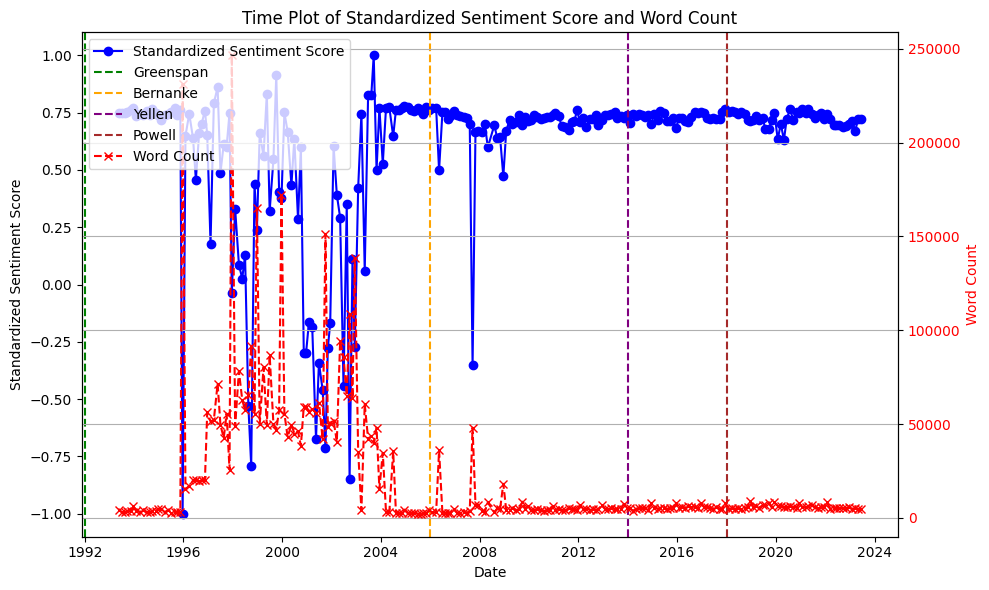

In [995]:
# Ensure that the 'Date' column is in datetime format
dataset_adjusted['Date'] = pd.to_datetime(dataset_adjusted['Date'])

# Sort the DataFrame by 'Date'
dataset_adjusted = dataset_adjusted.sort_values('Date')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting 'Standardized Sentiment Score'
ax.set_xlabel('Date')
ax.set_ylabel('Standardized Sentiment Score')
ax.plot(dataset_adjusted['Date'], dataset_adjusted['Standardized Sentiment Score'], color='blue', marker='o', label='Standardized Sentiment Score')

# Plotting 'Word Count'
ax2 = ax.twinx()
ax2.set_ylabel('Word Count', color='red')
ax2.plot(dataset_adjusted['Date'], dataset_adjusted['Word Count'], color='red', linestyle='dashed', marker='x', label='Word Count')
ax2.tick_params(axis='y', labelcolor='red')

# Adding vertical lines at the specified years
ax.axvline(pd.Timestamp('1992-01-01'), color='green', linestyle='--', label='Greenspan')
ax.axvline(pd.Timestamp('2006-01-01'), color='orange', linestyle='--', label='Bernanke')
ax.axvline(pd.Timestamp('2014-01-01'), color='purple', linestyle='--', label='Yellen')
ax.axvline(pd.Timestamp('2018-01-01'), color='brown', linestyle='--', label='Powell')

# Combine the legends from both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Adding a title and grid
plt.title('Time Plot of Standardized Sentiment Score and Word Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

### Is the decreased sentiment a function of the level of monetary policy?

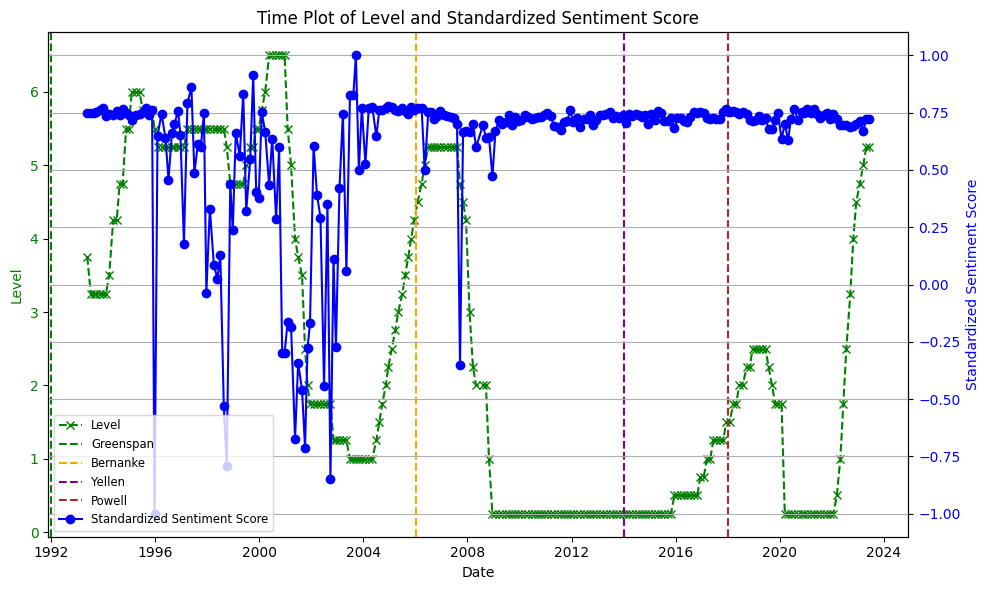

In [996]:
# Ensure that the 'Date' column is in datetime format
dataset_adjusted['Date'] = pd.to_datetime(dataset_adjusted['Date'])

# Sort the DataFrame by 'Date'
dataset_adjusted = dataset_adjusted.sort_values('Date')

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting 'Level' on the left axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Level', color='green')
ax1.plot(dataset_adjusted['Date'], dataset_adjusted['Level'], color='green', linestyle='dashed', marker='x', label='Level')
ax1.tick_params(axis='y', labelcolor='green')

# Creating the second y-axis for 'Standardized Sentiment Score'
ax2 = ax1.twinx()
ax2.set_ylabel('Standardized Sentiment Score', color='blue')
ax2.plot(dataset_adjusted['Date'], dataset_adjusted['Standardized Sentiment Score'], color='blue', marker='o', label='Standardized Sentiment Score')
ax2.tick_params(axis='y', labelcolor='blue')

# Adding vertical lines at the specified years
ax1.axvline(pd.Timestamp('1992-01-01'), color='green', linestyle='--', label='Greenspan')
ax1.axvline(pd.Timestamp('2006-01-01'), color='orange', linestyle='--', label='Bernanke')
ax1.axvline(pd.Timestamp('2014-01-01'), color='purple', linestyle='--', label='Yellen')
ax1.axvline(pd.Timestamp('2018-01-01'), color='brown', linestyle='--', label='Powell')

# Combine the legends from both axes with smaller font size
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='lower left', fontsize='small')

# Adding a title and grid
plt.title('Time Plot of Level and Standardized Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

### Identifying feature importance and features with identified temporal bias

In [997]:
# Get the feature importances from the best model
feature_importances = best_model.feature_importances_

# Get the selected feature indices
selected_indices = np.where(feature_importances > 0)[0]

# Get the selected feature names
selected_features_names = X_train.columns[selected_indices]

# Create a list of tuples containing feature name and importance (absolute value)
feature_importance_tuples = [(feature, abs(importance)) for feature, importance in zip(selected_features_names, feature_importances[selected_indices])]

# Sort the feature importance tuples by importance (absolute value) in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Count the number of selected features
num_selected_features = len(selected_features_names)

# Print the number of selected features
print("Number of Selected Features:", num_selected_features)

# Print the selected feature names and their importance scores (absolute value)
print("Selected Features and Their Importance Scores (Descending Order):")
for feature, importance in feature_importance_tuples:
    print(f"{feature}: {importance}")

Number of Selected Features: 62
Selected Features and Their Importance Scores (Descending Order):
Short-Term Treasury Diff: 0.6416330738996824
decline: 0.05109219078195548
easing: 0.029100270669612006
weaker: 0.026167111389517366
Durable Goods Orders_RollingMean: 0.01866410607430299
Long-Term Treasury Bond Rate: 0.017395636015352954
Negative Frequency: 0.01630529115623634
LEI_RollingMean: 0.015084806574168266
Date: 0.011493348514435365
Short-Term Treasury Bond Rate: 0.009912661560215898
LAG: 0.008354487160955687
LAG_RollingMean: 0.008292614437827469
improve: 0.007996268605929169
Proportion Negative Words: 0.007226120731952265
weakening: 0.006561398618807451
slowly: 0.006520341041727246
Word Count: 0.0062055858329888676
strength: 0.005241249004166635
despite: 0.0050410968821473735
Standardized Sentiment Score: 0.004770820754041653
slowed: 0.004673951017734162
rebound: 0.0046514766001019715
Proportion Positive Words: 0.004546728437876252
CPI: 0.004248242901758812
Treasury Deposits: 0.004

### Do certain Fed Chairmen have naturally larger proportions of negative words per Minute?

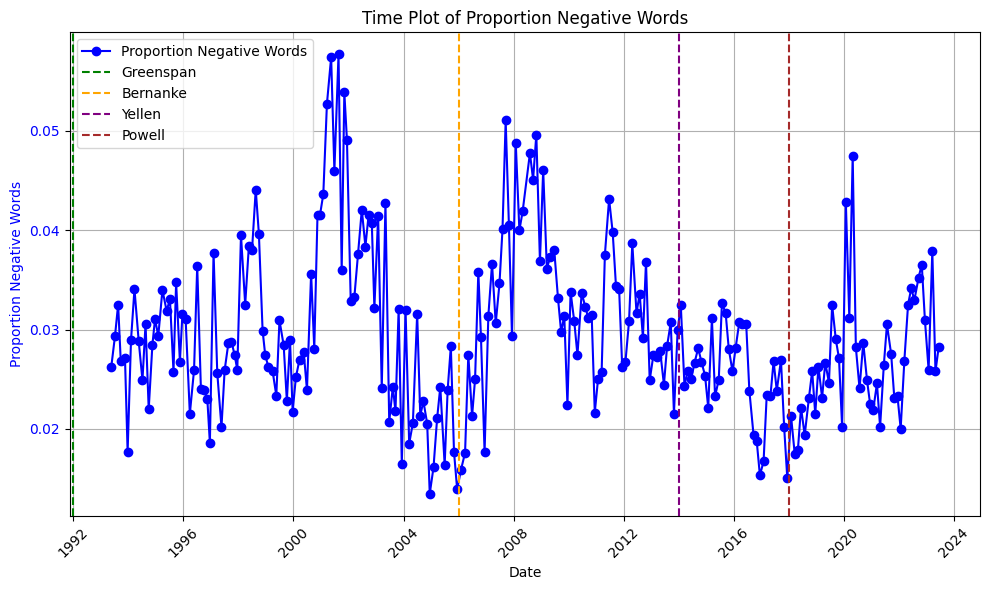

In [998]:
# Ensure that the 'Date' column is in datetime format
dataset_adjusted['Date'] = pd.to_datetime(dataset_adjusted['Date'])

# Sort the DataFrame by 'Date'
dataset_adjusted = dataset_adjusted.sort_values('Date')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Creating the y-axis for 'Proportion Negative Words'
ax.set_xlabel('Date')
ax.set_ylabel('Proportion Negative Words', color='blue')
ax.plot(dataset_adjusted['Date'], dataset_adjusted['Proportion Negative Words'], color='blue', marker='o', label='Proportion Negative Words')
ax.tick_params(axis='y', labelcolor='blue')

# Adding vertical lines at the specified years
ax.axvline(pd.Timestamp('1992-01-01'), color='green', linestyle='--', label='Greenspan')
ax.axvline(pd.Timestamp('2006-01-01'), color='orange', linestyle='--', label='Bernanke')
ax.axvline(pd.Timestamp('2014-01-01'), color='purple', linestyle='--', label='Yellen')
ax.axvline(pd.Timestamp('2018-01-01'), color='brown', linestyle='--', label='Powell')

# Adding a legend
ax.legend(loc='upper left')

# Adding a title and grid
plt.title('Time Plot of Proportion Negative Words')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [999]:
# Filter the dataset for each subset based on the specified date ranges
greenspan_start = pd.Timestamp('1993-05-18')
greenspan_end = pd.Timestamp('2006-01-31')
bernanke_start = pd.Timestamp('2006-02-01')
bernanke_end = pd.Timestamp('2014-01-31')
yellen_start = pd.Timestamp('2014-02-03')
yellen_end = pd.Timestamp('2018-02-03')
powell_start = pd.Timestamp('2018-02-04')

greenspan_pnw = dataset_adjusted[
    (dataset_adjusted['Date'] >= greenspan_start) & (dataset_adjusted['Date'] <= greenspan_end)
]['Proportion Negative Words']

bernanke_pnw = dataset_adjusted[
    (dataset_adjusted['Date'] >= bernanke_start) & (dataset_adjusted['Date'] <= bernanke_end)
]['Proportion Negative Words']

yellen_pnw = dataset_adjusted[
    (dataset_adjusted['Date'] >= yellen_start) & (dataset_adjusted['Date'] <= yellen_end)
]['Proportion Negative Words']

powell_pnw = dataset_adjusted[
    dataset_adjusted['Date'] >= powell_start
]['Proportion Negative Words']

# Print the lengths of each subset
print("Length of Greenspan_PNW subset:", len(greenspan_pnw))
print("Length of Bernanke_PNW subset:", len(bernanke_pnw))
print("Length of Yellen_PNW subset:", len(yellen_pnw))
print("Length of Powell_PNW subset:", len(powell_pnw))

Length of Greenspan_PNW subset: 103
Length of Bernanke_PNW subset: 63
Length of Yellen_PNW subset: 32
Length of Powell_PNW subset: 43


### Analysis of Means

In [1000]:
# Combine all the PNW values into a single array
all_pnw = np.concatenate([greenspan_pnw, bernanke_pnw, yellen_pnw, powell_pnw])

# Create corresponding labels for each group
labels = ['Greenspan'] * len(greenspan_pnw) + ['Bernanke'] * len(bernanke_pnw) + ['Yellen'] * len(yellen_pnw) + ['Powell'] * len(powell_pnw)

# Perform Tukey-Kramer post hoc test
tukey_result = pairwise_tukeyhsd(all_pnw, labels, alpha=0.05)

# Print the Tukey-Kramer test results
print(tukey_result)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
 Bernanke Greenspan  -0.0028 0.1198  -0.006  0.0005  False
 Bernanke    Powell  -0.0055 0.0026 -0.0095 -0.0015   True
 Bernanke    Yellen  -0.0078    0.0 -0.0123 -0.0034   True
Greenspan    Powell  -0.0027 0.2278 -0.0064   0.001  False
Greenspan    Yellen  -0.0051 0.0089 -0.0092 -0.0009   True
   Powell    Yellen  -0.0023 0.5796 -0.0071  0.0024  False
----------------------------------------------------------


### Convert the 'Date' variable back into dates to show how subsets line up to Chair Tenure

In [1001]:
base_date = pd.to_datetime('1993-05-18')

# Convert X_train['Date'] to datetime format
Date_train = base_date + pd.to_timedelta(X_train['Date'], unit='D')

# Convert X_valid['Date'] to datetime format
Date_valid = base_date + pd.to_timedelta(X_valid['Date'], unit='D')

# Convert X_test['Date'] to datetime format
Date_test = base_date + pd.to_timedelta(X_test['Date'], unit='D')

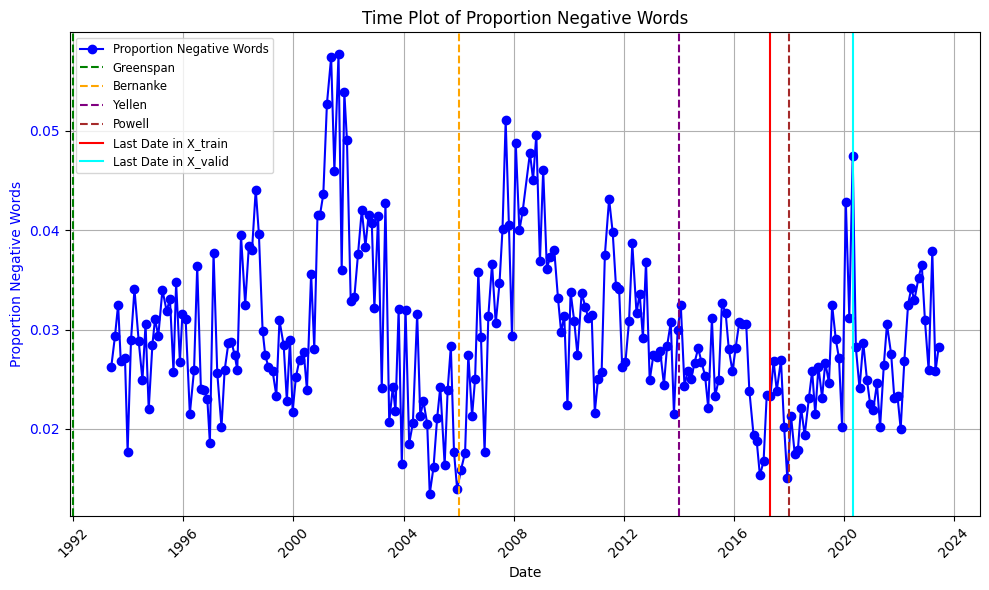

In [1002]:
# Ensure that the 'Date' column is in datetime format
dataset_adjusted['Date'] = pd.to_datetime(dataset_adjusted['Date'])

# Sort the DataFrame by 'Date'
dataset_adjusted = dataset_adjusted.sort_values('Date')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Creating the y-axis for 'Proportion Negative Words'
ax.set_xlabel('Date')
ax.set_ylabel('Proportion Negative Words', color='blue')
ax.plot(dataset_adjusted['Date'], dataset_adjusted['Proportion Negative Words'], color='blue', marker='o', label='Proportion Negative Words')
ax.tick_params(axis='y', labelcolor='blue')

# Adding vertical lines at the specified years
ax.axvline(pd.Timestamp('1992-01-01'), color='green', linestyle='--', label='Greenspan')
ax.axvline(pd.Timestamp('2006-01-01'), color='orange', linestyle='--', label='Bernanke')
ax.axvline(pd.Timestamp('2014-01-01'), color='purple', linestyle='--', label='Yellen')
ax.axvline(pd.Timestamp('2018-01-01'), color='brown', linestyle='--', label='Powell')

# Adding vertical lines for the last 'Date' value in X_train and X_valid
ax.axvline(Date_train.iloc[-1], color='red', linestyle='-', label='Last Date in X_train')
ax.axvline(Date_valid.iloc[-1], color='cyan', linestyle='-', label='Last Date in X_valid')

# Adding a legend with smaller font size
ax.legend(loc='upper left', fontsize='small')

# Adding a title and grid
plt.title('Time Plot of Proportion Negative Words')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [1003]:
# Combine the other three subsets into a single array
other_pnw = np.concatenate([greenspan_pnw, bernanke_pnw, powell_pnw])

# Combine powell_pnw and other_pnw into a single array
all_pnw = np.concatenate([other_pnw, yellen_pnw])

# Create corresponding labels for each group
labels = ['Other'] * len(other_pnw) + ['Yellen'] * len(yellen_pnw)

# Perform Tukey-Kramer post hoc test
tukey_result = pairwise_tukeyhsd(all_pnw, labels, alpha=0.05)

# Print the Tukey-Kramer test results
print(tukey_result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 Other Yellen  -0.0053 0.0005 -0.0083 -0.0023   True
----------------------------------------------------


In [1004]:
# Combine the other three subsets into a single array
other_pnw = np.concatenate([greenspan_pnw, bernanke_pnw, yellen_pnw])

# Combine powell_pnw and other_pnw into a single array
all_pnw = np.concatenate([other_pnw, powell_pnw])

# Create corresponding labels for each group
labels = ['Other'] * len(other_pnw) + ['Powell'] * len(powell_pnw)

# Perform Tukey-Kramer post hoc test
tukey_result = pairwise_tukeyhsd(all_pnw, labels, alpha=0.05)

# Print the Tukey-Kramer test results
print(tukey_result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 Other Powell  -0.0028 0.0433 -0.0055 -0.0001   True
----------------------------------------------------


### Does Log-transforming the Proportion Negative Words variable adjust for the bias?

In [1005]:
# Combine the other three subsets into a single array
other_pnw = np.concatenate([greenspan_pnw, bernanke_pnw, yellen_pnw])

# Convert to log
log_other_pnw = np.log(other_pnw)
log_powell_pnw = np.log(powell_pnw)

# Combine powell_pnw and other_pnw into a single array
log_all_pnw = np.concatenate([log_other_pnw, log_powell_pnw])

# Create corresponding labels for each group
labels = ['Other'] * len(log_other_pnw) + ['Powell'] * len(log_powell_pnw)

# Perform Tukey-Kramer post hoc test
tukey_result = pairwise_tukeyhsd(log_all_pnw, labels, alpha=0.05)

# Print the Tukey-Kramer test results
print(tukey_result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
 Other Powell  -0.0832  0.07 -0.1733 0.0069  False
--------------------------------------------------


In [1006]:
# Combine the other three subsets into a single array
other_pnw = np.concatenate([greenspan_pnw, bernanke_pnw, powell_pnw])

# Convert to log
log_other_pnw = np.log(other_pnw)
log_yellen_pnw = np.log(yellen_pnw)

# Combine yellen_pnw and other_pnw into a single array
log_all_pnw = np.concatenate([log_other_pnw, log_yellen_pnw])

# Create corresponding labels for each group
labels = ['Other'] * len(log_other_pnw) + ['Yellen'] * len(log_yellen_pnw)

# Perform Tukey-Kramer post hoc test
tukey_result = pairwise_tukeyhsd(log_all_pnw, labels, alpha=0.05)

# Print the Tukey-Kramer test results
print(tukey_result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 Other Yellen  -0.1753 0.0006 -0.2752 -0.0754   True
----------------------------------------------------


### Run model again with log-transformed Proportion Negative Words

#### Adjust Proportion of Negative Words

In [1007]:
# Calculate log of 'Proportion Negative Words' for X_train
X_train['log_pnw'] = np.log(X_train['Proportion Negative Words'] + 1)

# Calculate log of 'Proportion Negative Words' for X_valid
X_valid['log_pnw'] = np.log(X_valid['Proportion Negative Words'] + 1)

# Calculate log of 'Proportion Negative Words' for X_test
X_test['log_pnw'] = np.log(X_test['Proportion Negative Words'] + 1)

In [1008]:
X_train['Date'] = train['Date']
base_date = pd.to_datetime('1993-05-18')

# Convert X_train['Date'] to datetime format
X_train['Date'] = base_date + pd.to_timedelta(X_train['Date'], unit='D')

# Filter rows with dates within the specified range
yellen_range_mask = (X_train['Date'] >= yellen_start) & (X_train['Date'] <= yellen_end)

# Add 0.1753 to 'log_pnw' for rows within the Yellen range
X_train.loc[yellen_range_mask, 'log_pnw'] += 0.1753

#### Confirrm that only negative sentiment words have fully negative values, making it easy to alter for bias

In [1015]:
# Find variables with only negative numbers in X_train
negative_only_vars = []
for column in X_train.columns:
    if column != 'Date' and (X_train[column] <= 0).all():
        negative_only_vars.append(column)

print("Variables with only negative numbers:", negative_only_vars)

Variables with only negative numbers: ['caution', 'slowly', 'loss', 'negative', 'deterioration', 'sluggish', 'diminishing', 'slower', 'downturn', 'concerned', 'disappointing', 'deficit', 'tightening', 'decline', 'persist', 'weak', 'slowdown', 'volatile', 'adverse', 'persistence', 'diminished', 'weakened', 'weakness', 'absence', 'slowing', 'persisting', 'downward', 'slowed', 'severe', 'sharply', 'lagged', 'easing', 'difficult', 'slow', 'contraction', 'dropped', 'weaker', 'unemployment', 'weakening', 'declined', 'depressed', 'question', 'volatility', 'declining', 'concern', 'turmoil', 'dissented', 'problem', 'difficulty', 'liquidation', 'cut', 'imbalance']


In [1016]:
# Filter rows with dates within the specified range
yellen_range_mask = (X_train['Date'] >= yellen_start) & (X_train['Date'] <= yellen_end)

# Multiply columns in 'negative_only_vars' by 100.53% for rows within the Yellen range
X_train.loc[yellen_range_mask, negative_only_vars] *= 1.0053

In [1020]:
# Convert 'Date' back to datetime
X_train['Date'] = base_date + pd.to_timedelta(X_train['Date'], unit='D')

# Uncovnert X_train['Date'] back to number of days
X_train['Date'] = (X_train['Date'] - base_date) / pd.to_timedelta(1, unit='D')

# Convert 'Date' back to datetime
X_valid['Date'] = base_date + pd.to_timedelta(X_valid['Date'], unit='D')

# Uncovnert X_valid['Date'] back to number of days
X_valid['Date'] = (X_valid['Date'] - base_date) / pd.to_timedelta(1, unit='D')

# Convert 'Date' back to datetime
X_test['Date'] = base_date + pd.to_timedelta(X_test['Date'], unit='D')

# Uncovnert X_test['Date'] back to number of days
X_test['Date'] = (X_test['Date'] - base_date) / pd.to_timedelta(1, unit='D')

In [1023]:
param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 65, 70],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Create GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model_1, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the model to the training data and find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best model with optimal hyperparameters
rf_model_bias_1 = grid_search.best_estimator_

# Predict y_train_pred on the training set
y_train_pred = rf_model_bias_1.predict(X_train)

# Predict y_valid_pred on the validation set
y_valid_pred = rf_model_bias_1.predict(X_valid)

# Get predictions for the test set
y_test_pred = rf_model_bias_1.predict(X_test)

# Round the predicted values to the nearest possible value
y_train_pred = [round_to_nearest(val, possible_values) for val in y_train_pred]
y_valid_pred = [round_to_nearest(val, possible_values) for val in y_valid_pred]
y_test_pred = [round_to_nearest(val, possible_values) for val in y_test_pred]

# Get the feature importances from the best model
feature_importances = rf_model_bias_1.feature_importances_

# Get the number of features used (non-zero feature importances)
num_features_used = np.sum(feature_importances > 0)

# Print the number of features used in the last iteration
print("Number of Features Used:", num_features_used)

# Extract the random seed from the last element of the random_seeds list
random_seed_used = random_seeds[-1]

# Print the random seed used in the last iteration
print("Random Seed Used:", random_seed_used)

Number of Features Used: 45
Random Seed Used: 1073137954


In [1024]:
# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, best_y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, best_y_valid_pred)

# Calculate Mean Squared Error (MSE) for test set
mse_test = mean_squared_error(y_test, best_y_test_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate Root Mean Squared Error (RMSE) for test set
rmse_test = np.sqrt(mse_test)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, best_y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, best_y_valid_pred)

# Calculate R-squared (R^2) for test set
r2_test = r2_score(y_test, best_y_test_pred)

# Calculate adjusted R-squared for training set
n_train = X_train_ai_3.shape[0]
p_train = X_train_ai_3.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid_ai_3.shape[0]
p_valid = X_valid_ai_3.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate adjusted R-squared for test set
n_test = X_test_ai_3.shape[0]
p_test = X_test_ai_3.shape[1]
adj_r2_test = 1 - ((1 - r2_test) * (n_test - 1) / (n_test - p_test - 1))

# Calculate accuracy for training, validation, and test sets with the threshold
accuracy_train = calculate_accuracy(y_train, best_y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, best_y_valid_pred)
accuracy_test = calculate_accuracy(y_test, best_y_test_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid, mse_test],
    ["RMSE", rmse_train, rmse_valid, rmse_test],
    ["R^2", r2_train, r2_valid, r2_test],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid, adj_r2_test],
    ["Accuracy", accuracy_train, accuracy_valid, accuracy_test],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set", "Test Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+------------+
| Metric       |   Training Set |   Validation Set |   Test Set |
+==============+================+==================+============+
| MSE          |     0.00358073 |        0.0182292 |  0.0520833 |
+--------------+----------------+------------------+------------+
| RMSE         |     0.0598392  |        0.135015  |  0.228218  |
+--------------+----------------+------------------+------------+
| R^2          |     0.910565   |        0.719533  |  0.374185  |
+--------------+----------------+------------------+------------+
| Adjusted R^2 |     0.781      |        1.07168   |  1.16173   |
+--------------+----------------+------------------+------------+
| Accuracy     |     0.942708   |        0.708333  |  0.666667  |
+--------------+----------------+------------------+------------+


In [1071]:
# Get the feature importances from the best model
feature_importances = rf_model_bias_1.feature_importances_

# Get the selected feature indices
selected_indices = np.where(feature_importances > 0)[0]

# Get the selected feature names
selected_features_names = X_train.columns[selected_indices]

# Create a list of tuples containing feature name and importance (absolute value)
feature_importance_tuples = [(feature, abs(importance)) for feature, importance in zip(selected_features_names, feature_importances[selected_indices])]

# Sort the feature importance tuples by importance (absolute value) in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the selected feature names and their importance scores (absolute value)
print("Selected Features and Their Importance Scores (Descending Order):")
for feature, importance in feature_importance_tuples:
    print(f"{feature}: {importance}")

Selected Features and Their Importance Scores (Descending Order):
Short-Term Treasury Diff: 0.6833860295788221
decline: 0.0468731336877101
Long-Term Treasury Bond Rate: 0.03589390474402563
easing: 0.03242385924424116
weaker: 0.023638873093912667
Negative Frequency: 0.015550975826522992
Date: 0.014011233471359057
Durable Goods Orders_RollingMean: 0.011212234651556574
LAG: 0.0096463230264657
Housing Sales: 0.009116696901977282
improve: 0.008342449196664267
LAG_RollingMean: 0.008264860421682932
CPI: 0.006964359398673825
rebound: 0.0069529963060064055
LEI_RollingMean: 0.006732033991008653
Proportion Negative Words: 0.005787351924897509
strength: 0.00558618482055505
problem: 0.004843501030309584
Proportion Positive Words: 0.004840411434971973
Short-Term Treasury Bond Rate: 0.00457058530637225
weakness: 0.0045172773008799755
Word Count: 0.004497937401196858
declined: 0.004423864079500471
slow: 0.004308025576076189
Retail Sales_RollingMean: 0.0041323399144805205
weakening: 0.00340021443582056

In [1095]:
# Extract features with importance greater than the absolute value of 0.15
selected_features_greater_than_0_01 = np.where(feature_importances > 0.01)[0]

selected_features_greater_than_0_01 = X_train.columns[selected_features_greater_than_0_01]

# Create a list of selected features from 'selected_features_greater_than_0_01'
selected_features_greater_than_0_01 = selected_features_greater_than_0_01.tolist()

# Include the 'Difference' variable in the selected features
selected_features_greater_than_0_01.append('Difference')

# Find columns in 'full_dataset' that match the names in 'selected_features_greater_than_0_01'
matching_columns = full_dataset.columns[full_dataset.columns.isin(selected_features_greater_than_0_01)]

# Create a subset of 'full_dataset' with the matching columns
bias_subset = full_dataset[matching_columns]

In [1096]:
selected_features_greater_than_0_01

['Date',
 'Long-Term Treasury Bond Rate',
 'Negative Frequency',
 'Short-Term Treasury Diff',
 'Durable Goods Orders_RollingMean',
 'decline',
 'easing',
 'weaker',
 'Difference']

In [1097]:
# Split into training, validation, and test sets
train_bias, valid_bias = train_test_split(bias_subset, test_size=0.2, shuffle=False)

# Split the combined set into validation and test sets
valid_bias, test_bias = train_test_split(valid_bias, test_size=0.5, shuffle=False)

# Verify the sizes of each set
print("Training set size:", len(train_bias))
print("Validation set size:", len(valid_bias))
print("Test set size:", len(test_bias))

Training set size: 192
Validation set size: 24
Test set size: 24


In [1105]:
# Convert variables to numeric in the train_bias dataset
variables_to_convert = train_bias.columns.drop('Date')
train_bias[variables_to_convert] = train_bias[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the valid_bias dataset
valid_bias[variables_to_convert] = valid_bias[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the test_bias dataset
test_bias[variables_to_convert] = test_bias[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Prepare the data for the model
X_train_bias = train_bias.drop(columns=['Difference'])
y_train_bias = train_bias['Difference']  # Use the 'Difference' variable as the target

X_valid_bias = valid_bias.drop(columns=['Difference'])
y_valid_bias = valid_bias['Difference']  # Use the 'Difference' variable as the target

X_test_bias = test_bias.drop(columns=['Difference'])
y_test_bias = test_bias['Difference']  # Use the 'Difference' variable as the target

In [1106]:
# Find variables with only negative numbers in X_train
negative_only_vars = []
for column in X_train_bias.columns:
    if column != 'Date' and (X_train[column] <= 0).all():
        negative_only_vars.append(column)

print("Variables with only negative numbers:", negative_only_vars)

Variables with only negative numbers: ['decline', 'easing', 'weaker']


In [1109]:
# Filter rows with dates within the specified range
yellen_range_mask = (X_train_bias['Date'] >= yellen_start) & (X_train_bias['Date'] <= yellen_end)

# Multiply columns in 'negative_only_vars' by 100.53% for rows within the Yellen range
X_train_bias.loc[yellen_range_mask, negative_only_vars] *= 1.0053

In [1110]:
# Uncovnert X_train['Date'] back to number of days
X_train_bias['Date'] = (X_train_bias['Date'] - base_date) / pd.to_timedelta(1, unit='D')

In [1111]:
param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 65, 70],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Create GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model_1, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the model to the training data and find the best hyperparameters
grid_search.fit(X_train_bias, y_train)

# Get the best model with optimal hyperparameters
rf_model_bias_2 = grid_search.best_estimator_

# Predict y_train_pred on the training set
y_train_pred = rf_model_bias_2.predict(X_train_bias)

# Predict y_valid_pred on the validation set
y_valid_pred = rf_model_bias_2.predict(X_valid_bias)

# Get predictions for the test set
y_test_pred = rf_model_bias_2.predict(X_test_bias)

# Round the predicted values to the nearest possible value
y_train_pred = [round_to_nearest(val, possible_values) for val in y_train_pred]
y_valid_pred = [round_to_nearest(val, possible_values) for val in y_valid_pred]
y_test_pred = [round_to_nearest(val, possible_values) for val in y_test_pred]

# Get the feature importances from the best model
feature_importances = rf_model_bias_2.feature_importances_

# Get the number of features used (non-zero feature importances)
num_features_used = np.sum(feature_importances > 0)

# Print the number of features used in the last iteration
print("Number of Features Used:", num_features_used)

# Extract the random seed from the last element of the random_seeds list
random_seed_used = random_seeds[-1]

# Print the random seed used in the last iteration
print("Random Seed Used:", random_seed_used)

Number of Features Used: 8
Random Seed Used: 1073137954


In [1112]:
# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, best_y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, best_y_valid_pred)

# Calculate Mean Squared Error (MSE) for test set
mse_test = mean_squared_error(y_test, best_y_test_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate Root Mean Squared Error (RMSE) for test set
rmse_test = np.sqrt(mse_test)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, best_y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, best_y_valid_pred)

# Calculate R-squared (R^2) for test set
r2_test = r2_score(y_test, best_y_test_pred)

# Calculate adjusted R-squared for training set
n_train = X_train_ai_3.shape[0]
p_train = X_train_ai_3.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid_ai_3.shape[0]
p_valid = X_valid_ai_3.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate adjusted R-squared for test set
n_test = X_test_ai_3.shape[0]
p_test = X_test_ai_3.shape[1]
adj_r2_test = 1 - ((1 - r2_test) * (n_test - 1) / (n_test - p_test - 1))

# Calculate accuracy for training, validation, and test sets with the threshold
accuracy_train = calculate_accuracy(y_train, best_y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, best_y_valid_pred)
accuracy_test = calculate_accuracy(y_test, best_y_test_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid, mse_test],
    ["RMSE", rmse_train, rmse_valid, rmse_test],
    ["R^2", r2_train, r2_valid, r2_test],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid, adj_r2_test],
    ["Accuracy", accuracy_train, accuracy_valid, accuracy_test],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set", "Test Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+------------+
| Metric       |   Training Set |   Validation Set |   Test Set |
+==============+================+==================+============+
| MSE          |     0.00358073 |        0.0182292 |  0.0520833 |
+--------------+----------------+------------------+------------+
| RMSE         |     0.0598392  |        0.135015  |  0.228218  |
+--------------+----------------+------------------+------------+
| R^2          |     0.910565   |        0.719533  |  0.374185  |
+--------------+----------------+------------------+------------+
| Adjusted R^2 |     0.781      |        1.07168   |  1.16173   |
+--------------+----------------+------------------+------------+
| Accuracy     |     0.942708   |        0.708333  |  0.666667  |
+--------------+----------------+------------------+------------+


## Model Deployment

In [1135]:
# Split into training, validation, and test sets
train_data, val_test_data = train_test_split(prep_df, test_size=0.2, shuffle=False)

# Split the combined set into validation and test sets
val_data, test_data = train_test_split(val_test_data, test_size=0.5, shuffle=False)

train = train_data
valid = val_data
test = test_data

# Convert variables to numeric in the train dataset
variables_to_convert = train.columns.drop('Date')
train[variables_to_convert] = train[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the valid dataset
valid[variables_to_convert] = valid[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the test dataset
test[variables_to_convert] = test[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Prepare the data for the model
X_train = train.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_train = train['Difference']  # Use the 'Difference' variable as the target

X_valid = valid.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_valid = valid['Difference']  # Use the 'Difference' variable as the target

X_test = test.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_test = test['Difference']  # Use the 'Difference' variable as the target

In [1136]:
# Get predictions for the training set
best_y_train_pred = rf_model_2.predict(X_train)

# Get predictions for the validation set
best_y_valid_pred = rf_model_2.predict(X_valid)

# Get predictions for the test set
best_y_test_pred = rf_model_2.predict(X_test)

# Round the predicted values to the nearest possible value
best_y_train_pred = [round_to_nearest(val, possible_values) for val in best_y_train_pred]
best_y_valid_pred = [round_to_nearest(val, possible_values) for val in best_y_valid_pred]
best_y_test_pred = [round_to_nearest(val, possible_values) for val in best_y_test_pred]

In [1138]:
# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, best_y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, best_y_valid_pred)

# Calculate Mean Squared Error (MSE) for test set
mse_test = mean_squared_error(y_test, best_y_test_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate Root Mean Squared Error (RMSE) for test set
rmse_test = np.sqrt(mse_test)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, best_y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, best_y_valid_pred)

# Calculate R-squared (R^2) for test set
r2_test = r2_score(y_test, best_y_test_pred)

# Calculate adjusted R-squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid.shape[0]
p_valid = X_valid.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate adjusted R-squared for test set
n_test = X_test.shape[0]
p_test = X_test.shape[1]
adj_r2_test = 1 - ((1 - r2_test) * (n_test - 1) / (n_test - p_test - 1))

# Calculate accuracy for training, validation, and test sets with the threshold
accuracy_train = calculate_accuracy(y_train, best_y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, best_y_valid_pred)
accuracy_test = calculate_accuracy(y_test, best_y_test_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid, mse_test],
    ["RMSE", rmse_train, rmse_valid, rmse_test],
    ["R^2", r2_train, r2_valid, r2_test],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid, adj_r2_test],
    ["Accuracy", accuracy_train, accuracy_valid, accuracy_test],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set", "Test Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+------------+
| Metric       |   Training Set |   Validation Set |   Test Set |
+==============+================+==================+============+
| MSE          |     0.00358073 |        0.0182292 |  0.0494792 |
+--------------+----------------+------------------+------------+
| RMSE         |     0.0598392  |        0.135015  |  0.222439  |
+--------------+----------------+------------------+------------+
| R^2          |     0.910565   |        0.719533  |  0.393617  |
+--------------+----------------+------------------+------------+
| Adjusted R^2 |     0.816322   |        1.08601   |  1.18596   |
+--------------+----------------+------------------+------------+
| Accuracy     |     0.942708   |        0.708333  |  0.708333  |
+--------------+----------------+------------------+------------+


In [1139]:
rf_model_2 = RandomForestRegressor()
rf_model_2.fit(X_train, y_train) 

RandomForestRegressor()

In [1141]:
# Specify the full path including the filename for saving
save_path = r'C:\Users\abact\BC-Project\models\Final Model\best_rf_model.pkl'
with open(save_path, 'wb') as file:
    pickle.dump(rf_model_2, file)